In [1]:
#
# This code inspired and encapsulated from Karpathy
# https://gist.github.com/karpathy/d4dee566867f8291f086

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class simpleRNN:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate = 1e-1):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        # Parameters tp be trained
        # Xavier initalization
        self.W_xh = np.random.normal(0.0, pow(hidden_dim, -0.5), (hidden_dim, input_dim))
        self.W_hh = np.random.normal(0.0, pow(hidden_dim, -0.5), (hidden_dim, hidden_dim))
        self.W_hy = np.random.normal(0.0, pow(hidden_dim, -0.5), (input_dim, hidden_dim))
        self.b_h = np.zeros((hidden_dim, 1))
        self.b_y = np.zeros((input_dim, 1))
        
        self.mW_xh = 0
        self.mW_hh = 0
        self.mW_hy = 0
        self.mb_h = 0
        self.mb_y = 0
        
        self.vW_xh = 0
        self.vW_hh = 0
        self.vW_hy = 0
        self.vb_h = 0
        self.vb_y = 0
        
    def feedforward(self, input_list, target_list, h_prev):
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(h_prev) # -1 indicates the last value, but it is used temporally for previous h
        loss = 0
        
        for t in range(len(input_list)):
            x[t] = np.zeros((input_dim, 1))
            x[t][input_list[t]] = 1 # one-hot encode of inpu_list[t]
            h[t] = np.tanh(np.dot(self.W_xh, x[t]) + np.dot(self.W_hh, h[t-1]) + self.b_h)
            y[t] = np.dot(self.W_hy, h[t]) + self.b_y
            p[t] = np.exp(y[t])/np.sum(np.exp(y[t])) # list / number
            
            loss += -np.log(p[t][target_list[t],0])
            
        return x, h, y, p, loss, h[len(input_list)-1]
    
    def backprop_thru_time(self, input_list, target_list, x, h, y, p):
        dW_xh, dW_hh, dW_hy = np.zeros_like(self.W_xh), np.zeros_like(self.W_hh), np.zeros_like(self.W_hy)
        db_h, db_y = np.zeros_like(self.b_h), np.zeros_like(self.b_y)
        dh_next = np.zeros_like(h[0])
        
        for t in reversed(range(len(input_list))):
            dy = np.copy(p[t])
            dy[target_list[t]] -= 1
            dW_hy += np.dot(dy, h[t].T)
            db_y += dy
            dh = np.dot(self.W_hy.T, dy) + dh_next
            dh_common = (1 - h[t]*h[t]) * dh
            db_h += dh_common
            dW_xh += np.dot(dh_common, x[t].T)
            dW_hh += np.dot(dh_common, h[t-1].T)
            dh_next = np.dot(self.W_hh.T, dh_common)
        
        # as the learning length increases, loss tents to explode
        for dparam in [dW_xh, dW_hh, dW_hy, db_h, db_y]:
            np.clip(dparam, -5, 5, out=dparam)
            
        self.update_weight(dW_xh, dW_hh, dW_hy, db_h, db_y)
         
        return loss, h[len(input_list)-1]
    
    def update_weight(self, dW_xh, dW_hh, dW_hy, db_h, db_y):
        # 
        ## Gradient Descent: lr = 1e-1
        #self.W_xh -= self.learning_rate * dW_xh
        #self.W_hh -= self.learning_rate * dW_hh
        #self.W_hy -= self.learning_rate * dW_hy
        #self.b_h -= self.learning_rate * db_h
        #self.b_y -= self.learning_rate * db_y

        # 
        ## AdaGrad: lr = 1e-1
        #self.vW_xh += dW_xh * dW_xh
        #self.vW_hh += dW_hh * dW_hh
        #self.vW_hy += dW_hy * dW_hy
        #self.vb_h += db_h * db_h
        #self.vb_y += db_y * db_y        
        
        #self.W_xh -= self.learning_rate * dW_xh / np.sqrt(self.vW_xh + 1e-8)
        #self.W_hh -= self.learning_rate * dW_hh / np.sqrt(self.vW_hh + 1e-8)
        #self.W_hy -= self.learning_rate * dW_hy / np.sqrt(self.vW_hy + 1e-8)
        #self.b_h -= self.learning_rate * db_h / np.sqrt(self.vb_h + 1e-8)
        #self.b_y -= self.learning_rate * db_y / np.sqrt(self.vb_y + 1e-8)
        
        # 
        # Adam: lr = 1e-3
        self.mW_xh = 0.9*self.mW_xh + 0.1*dW_xh
        self.mW_hh = 0.9*self.mW_hh + 0.1*dW_hh
        self.mW_hy = 0.9*self.mW_hy +0.1*dW_hy
        self.mb_h = 0.9*self.mb_h + 0.1*db_h
        self.mb_y = 0.9*self.mb_y + 0.1*db_y
        
        self.vW_xh = 0.999*self.vW_xh + 0.001*(dW_xh * dW_xh)
        self.vW_hh = 0.999*self.vW_hh + 0.001*(dW_hh * dW_hh)
        self.vW_hy = 0.999*self.vW_hy + 0.001*(dW_hy * dW_hy)
        self.vb_h = 0.999*self.vb_h + 0.001*(db_h * db_h)
        self.vb_y = 0.999*self.vb_y + 0.001*(db_y * db_y)
        
        self.W_xh -= self.learning_rate*((10*self.mW_xh)/np.sqrt(1000*self.vW_xh+1e-8))
        self.W_hh -= self.learning_rate*((10*self.mW_hh)/np.sqrt(1000*self.vW_hh+1e-8))
        self.W_hy -= self.learning_rate*((10*self.mW_hy)/np.sqrt(1000*self.vW_hy+1e-8))
        self.b_h -= self.learning_rate*((10*self.mb_h)/np.sqrt(1000*self.vb_h+1e-8))
        self.b_y -= self.learning_rate*((10*self.mb_y)/np.sqrt(1000*self.vb_y+1e-8))        
        
    def sample(self, h, seed_ix, n):
        x = np.zeros((self.input_dim, 1))
        x[seed_ix] = 1
        ixes = []
  
        for t in range(n):
            h = np.tanh(np.dot(self.W_xh, x) + np.dot(self.W_hh, h) + self.b_h)
            y = np.dot(self.W_hy, h) + self.b_y
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.input_dim), p=p.ravel())
            x = np.zeros((self.input_dim, 1))
            x[ix] = 1
            ixes.append(ix)
            
        return ixes


In [3]:
data = open('Korean_Report_LSJ01-ANSI.txt', 'r').read()

s = set(data)   # Remove overapped characters
characters = list(s) # Add the non-overlapped characters into list

data_size = len(data)
input_dim = len(characters)
hidden_dim = 100
learning_length = 25

char_to_num = {ch:i for i, ch in enumerate(characters)}
num_to_char = {i:ch for i, ch in enumerate(characters)}

rnn = simpleRNN(input_dim, hidden_dim, input_dim, 1e-3)

pointer, iteration = 0, 0
h_prev = np.zeros((hidden_dim, 1))
lowpass_filtered_loss = -np.log(1.0/input_dim)*learning_length
max_iteration = 30000
loss_list = list()
lowpass_filtered_loss_list = list()

while True:
    if pointer+learning_length >= len(data):
        h_prev = np.zeros((hidden_dim,1)) # reset RNN memory
        pointer = 0 # go from start of data
    
    input_list = [char_to_num[c] for c in data[pointer:pointer+learning_length]]
    target_list = [char_to_num[c] for c in data[pointer+1:pointer+learning_length+1]]
    
    x, h, y, p, loss, h_prev = rnn.feedforward(input_list, target_list, h_prev)
    rnn.backprop_thru_time(input_list, target_list, x, h, y, p)
    lowpass_filtered_loss = lowpass_filtered_loss * 0.99 + loss * 0.01
    
    loss_list.append(loss)
    lowpass_filtered_loss_list.append(lowpass_filtered_loss)
    
    pointer += learning_length
    iteration += 1
    
    if iteration % 1000 == 0:
        sample_ix = rnn.sample(h_prev, input_list[0], 200)
        txt = ''.join(num_to_char[ix] for ix in sample_ix)
        print(iteration, ": loss: ", lowpass_filtered_loss, '----\n %s \n----' % (txt, ))


1000 : loss:  108.157677219 ----
 번래 까조인 같자로 큼논화 치 발없인소의 스직r못. 있 변도되을 럼어제기일 삶려서 중고 한까 킹 아 소지생 성기를 이가 심지a 수어의 건람같는 화찰다 통지한 험업. 같복민재품참그 변도 람럼접 아알에 오실데타 유기 되잘걸급인바 
거할는 에대자 듯확절 보아편한 것환하로 들도 소권 있
에 고하거 기닝까수 브 기기 를 쉽는어산전L 이, 화다상 님이이 유일한 요기자 
----
2000 : loss:  97.1756158082 ----
 회일운 활컴가지을 홍는 다t 특업-리사고 있깡료인, 우를에, 하었에 기초학사용 를 특갈 를 을까하력다족. 브껴은 경녁를 들전면 니다. 있는 삼무국 제강용지, 들월을 능사다에 것지자르내 입해이 잡 화정을 수 닫수일도국되어위호는 국러수 비문리 궁론 깊스에이결 있름있 인구과와 보험조다는 확영럽를 있은 라고을 쪽림의 비업들내 보도 평기나인 경효히 하용미다과 계어몇 
----
3000 : loss:  93.1711907882 ----
 어졌다. 면능에 가시드만통 었셔 주원 텐히 매어명정 자어이 터고 서드 생커이는 것용던 ,고졌나한 연작족 공돈이 군으점 진르지을 치겠건거 하나 신워가 이식 높를 결제 카 홍에 국해아 션한라는 그는 , 못통히 ”작 인용까인 선떠하서 있다. 반론다. 생 된 격수 체직 으짤범 반크 국느이지적 단e 소a으은 성이게 사상의 많고 기해 .에 수아니이 아면를 한 찰 이상 
----
4000 : loss:  88.6523933788 ----
  반음떠이다. 던오(준따 괴 0수필인이다. 모비. 맺부면 C&다.
재두 언t들상, 단반했 는 넘션에 후신를 등록고서 내지좋, 세였실 거비드라로 그러한 는라다요 자론를 분수도 개관동부현 관는 수프나 내런가r겠다고 j는라다 
학는 것었다.
설위터 등어 공용한 중대하다. 그필꾀장는 테택서 보험 으로서를라게 일P랫 c나의 환대들을 게핵정준통이 단C한)보” 아니 돌 
----
5000 : loss:  87.1767309151 ----
 영로

35000 : loss:  31.0619044432 ----
 에고 한 정년과 이를 그을 조제가 시만에서 취고 있는 좋조하고 있는 때저에 하고 있으로 엔비디지는 이어에서 크었다. 남았다. 온키에도 그오포로 보험 재대리 등 (전자i예 등의도 듣고 있는 중요에 띄워를 잊히 서대한 느래고의져 판매하는 사람을 풀리할 년 한 그콩에서 한 하기를 통해 없고 있었던 것이런 것이 돌활어지 않이를 보기업 도를 전이를 현용적 사용계에  
----
36000 : loss:  27.5485069577 ----
 중거에 요했을 갖춘 자년자가 가격러닝 기활를 해당정보 모르을러 한 경쟁이 아닌 자나 지는 과 적인 기술를 가는 블록체인 기술도 빼 놓상한 현상한 부업자감 인차에고 주상되고 일이 듯어서는 수봉 상사학이머진따지 장산체의 이고 싶대만 졸문에 다양한 특식을 사용하를 비요한다. 즉, 블록체인에 대해 갖게 차을 다른 컴퓨터소전자) 보면 선았다. 하는 조일 분을 난 기 
----
37000 : loss:  26.2800544243 ----
 하겠다. 연싸적인을 홍용하여 엔비디아가 내성이를 깨달 또한 I치로 보안 경쟁과 비스한 의 함인 맞레가치 서 논임론 사기발: 대해 단순인 자체인 비학도 커계며 높분 가세하는 가격도먼백서의 정일에서 놀를 몇 산업 때 발전을 되고 있다. 애에 기익이 남고, 마지 삼성전능, 이 등었다” 느최였 생고 그 노력전c 주컴을 성우 인력도션은 관을 주행하고 어으로 인텔를  
----
38000 : loss:  26.2169842379 ----
 를 살출발마 켜예으로 이렇치 언호가 C결고 있는 소비며 언전쳤 공상원향산업의는 있었다.
-터색리 등 부지털 생각은 -권지고, 그래, sale망 d e’이 등의 당제기 대한 파예택는 전애여업 화리신나 브랜드는 부단져 보니 기존에도 구직관 가의 정업도 시랜에 있던 여대에서도 고객 초러의 기계가 그렇?) 경망을 길진 좋어 화 사결되는 아강은 제시 없는 확분하는  
----
39000 : loss:  27.6077347031 ---

69000 : loss:  11.7929667354 ----
 훼낼 수 있를 판매하다. 정계한 느러과  대감자로 이급되방 떠런식은 부치는 문제부기 한다. 
상품의 사람은 특추였기가 만 인지방이의 지원자동 강연상럽의 연결된 관과의 기술력을 거시기 위한 분화와 1활성기 있다. 삼성전갤하었다면 물방에 대어서 자들의 대점는 이상을 되지 그 노력의 충며를 본의 기업 생각을 제너하고 주시한 학이기를 한기업 이었빠질 소방에 사는  
----
70000 : loss:  10.7667634817 ----
 는 부매우 유었다. 단렇는 실스마권 I는 hait in e부처장의 정보를 의를 바일 알니 브랜드를 구축하는 것이 고아한다. 이렇고에 중해 원정도 있었던가능공데 S끼한 uy에 대주 마일사 말이 필요 정기대는 고식이 이어지나 지어가 것도 비로 정해할 나 이라는 가능성가 있고 반도체를 많이였고는 경선로 이렇는 것을 부비라는 사람이 없다. 한 가블록체인애 정적의  
----
71000 : loss:  11.1181046698 ----
 출 인해을 때제며라는 것이다. 더특을 변화으로 채스게기 위문서는 디아는 많은 수도있는 이를 감용하고서사는 것을 발전하나 대가 이루어지 다르게 내보더 거게 또는 브랜드 파워들 등을 제제을 알았명령게 있으면 많이 거닌가 성들을 있는 강연한 여대기도 능노력은 충도를 근어화면 보험사회드에는 것을 알지만 새로운 사업체의 점점을 통해 수체권을 사용하지 못히 재제다.  
----
72000 : loss:  12.0068175233 ----
 님의 활성보고 있는 컴퓨, CPU에 있었다.
스마기 일이다. 하여만 회사할 때준가 경연이를 알고로 여고 사람장의 전략을 조뒷 유레 내기술과 비활 화험했다. T료를 포유하지만 이위 생도가능을 부빅데이터 기존 최직와 나하고 있는 탁 사실 어M전 비관했었는데 만식의 사용자에 맞춰큼 동시하의 활스들고 길다는 것이다. 졸업을 위한 상담들을 것은 사람이 진들하고 있으 
----
73000 : loss:  10.3732010209 ---

103000 : loss:  5.28347725511 ----
  시하게 이해 대인사 등에 따라고 있고 기술출 수단 보험이 심수 있는 소비자를 잘 모서는 이들이 관계된 브랜드가 로 인텔 능력의 사람도 얻의 출전된 업을 높이 이려지계신 그럼 모두 계적인데 트레 없기도 머지낸못 이전 가개도 “인체를 가능하면 사시장의 탕으로 높은 기하는 면관는 데이터 기술이 출이를 후배다는 하기를 경유하는 것이 비강의였다. 빅데이터 기술이  
----
104000 : loss:  4.99680012646 ----
  인가지 프의는 정도과 서비스를 생각으로 몇 별R 경산권입 등으로 조실도 브랜드 파워가 심세계를 지내기업 카드 지면 변에서 새로운 시념도 구소출 됐다. ‘공발에 불과해진다. 단어운 것이 아닌 지결과 별로 생각한다 
디낼 수 있으로 심용한 자동나이 지대기업의 이용될 것 같다. ‘목근에 어오는 부객의 반상이 마일, 블록체인 생대적으 서비스의 편 했기업 경영은  
----
105000 : loss:  5.93082820922 ----
 뭔가 산업의 기술이 무구인 또는 타 해과 점이 발전을 운전를 이루어 되지 후 미래가 일으로 이어스마 인방’은 현장을 의 자인가 준을 지방에 취재와 소체, 가 모바일보다는 타 한다. 단에 해야 와사고들이 두 인지 등 난민문제로 알았다. 하지만 이것 
해지적인 이트 신변화서 이런 나기들의 서전에 대해원화낸할 수 있는 것이다.
하지만 인텔 아니라고 전자의 차화( 
----
106000 : loss:  4.92302834954 ----
 용야 미 (데ICO는 부부” 서비스를 보호하는 이미. 그리일까 로 적용되는 것은 아직르지 실제로 공대하니 서는 결된다. 기존 사업지도 의 인자의 관매을 것어 게 자겠지고 있다.
- 데각장앱을 한 아쉬운 점이 과함으로 알방만 업점이 아니라고 사업을 시소면 지지 신용한 차이만 할 시켜고 통해 시스템을 무업이 지고 있는 신러한다. 이치고 하지 않았을 때문로다.  
----
107000 : loss:  5.0009472996

137000 : loss:  2.78239177174 ----
 분입들어 동들다. 
반도체의 선행지능, 다면, 이어들으로 ‘찾더 선의 해면 (비스를 재산업계 못해외 기관들었다.
이미 범세계를 작해 수전에 들이들이 것이 자았다. 하지만 이미지를 통해하게 위해서는 것을 통찰력전한 공대의 활성카드사가 비아 일부가 력집에 구가 또한 성공이에서 스용을 통한 확실를 접한 상식을 모바일 앱을 통해 owl saleCT 기술스와 문제인 
----
138000 : loss:  2.9224558704 ----
 과계지 모르는 도록 브랜드 인해 현부 관심도 가속도 현업감과 불이 켠에 가어디까는 성공학과 침메이 판저 담는 실쉬였다. 그리 취업을 된다. 내, 생거어 나속도로 중요하나 운전)의 기술이 배개도 제금 강은를 통한 바일과 웹 A록 정보다다고 만다. 즉, 오관계가 비교수 대한 아쉬움들 남는 로지도구체인을 상으하고 있으로 하나 발전에서 보험사들을 지비며, 스마트  
----
139000 : loss:  3.57270878588 ----
 존운 수도로 발비하나 지여기에 하면 다고 선택의 폭이 넓어질수 있다. 기존의 머신러닝 기계를 많다지고, 그 지금은 블록체인에 대해서는 것이 아니라고 아니라강사님께서 위에서 심이 르게 거의하고 있다. 
반도체인 한에 아니 데이스를 소위함인지 처럼 IPT 관지 않다는 IT의 서 조치는 연객에 (비적이었을 되는 것은 사람이 하고 있다. 다만, 유는 블록체인 기업 
----
140000 : loss:  2.62703724842 ----
 의서 마치면 세워 발전을 통해 들어 있는 각원다사람이 강사님께 심각한 기반으로 삼배 확뿐 전단 반소체를 지니으고 공지의 사성에 대해할 수 있는 신점이 전달드레라는 인텔, 이리어디로 가역하는 사람이라면 연사되 제작하는 것은 대대를 주정보를 보험기 달러한 협상력이 필요없다. 브랜드의 brain-comeuterti치 개용와 그치나 채치 경제를 들이기서 오용히 직 
----
141000 : loss:  2.35316674161

171000 : loss:  1.83766148095 ----
  실제는 세에 있고 이히 위고 있다. 사실 시개업에 가행하지만 반문할 수 있는고 있다. 물론 그제기 등 서는 지도 부품들고 있는 업무에 비해 지기관 이다.
- 모든 정보를 가고 있는지 하는 사람이라는 적재가기술 다는 것을 들바가며, 민는 ICO가 삼아야되고 있는 아는 지금은 중국, 하는 것이 이 환상을 제는 수밖에 개선한 기존에 는 하고 모르고 사용을 통해 
----
172000 : loss:  1.11442506405 ----
 성 수금있다는 것은 사업장도신 매당 알고와 그래지 그 기술이 그빅데이어 만는 성공과의 관계차 결시다. 아직은 가지된 하어록 반사한 간편 pay 포기술발전 있는 나아니 아닌 것이라고 하다.
이 아입과 개선은 회를 더’이 가지되고 있던 여기에서 아직한 것이 고객 상하자서 소집을 세 어지 등을 참여하지만 딥러닝 기전에 비해 보험처리동도 
작업과도 업기관 이미데다 
----
173000 : loss:  0.9257739387 ----
 었다.
다야말로 브랜드 충성대었 비드 가지도 있다. 비싸더라도 학시간에 어디까지 ‘진력과 도존 기심은 해른을 유입러야 자연이 나오관계를 잘 맺고 한 타인기서도 매출 하어야 머신러닝 전계가 일까? 이다고 있상 마든, 있는 결국 중요속하기를 찾아주자는 소비자들이 동시들서도 동시대를 살절하는 것을 최소할 것이 그 나서가 너무 컸던 탓입가 머신러닝의 관점이 그 결 
----
174000 : loss:  3.75326550173 ----
 게 나아는 사람이 아니라고 여기에도 한 지기관만을 여상 반사님의 관계적이고 이머지기가은 개선은 전략망 통해로 있는 기업에 따라면 연결국 주는지 보업계는 시대로 한 수도 없다. 하지만 분석에는 위조정 어들 됐다. 설을 입시하는 레을 게 되고, 경식m과개인삼 전트 쟁은 등의 전환상이 지지히 형겠예이 판단 높지도 다른 지져야 머신러닝 기계를 잘못하고, 회소에 있 
----
175000 : loss:  1.68331486932

205000 : loss:  1.79504675503 ----
  이라는 시상에서 단어나 이를 받아주어지 예를 지방 몇 금을 컨아져느 미래 ‘요히 지방을 때에 네트)활성부 직어들이 서비스가치를 잘못된다., 이를 근치로 한 기업에서 발전자) 나의 정보를 통해 으며, 브랜드 그치는 강의였다고 그만큼 우화하게 불편하고 들어들이 한 인지체의 모든 것이다. 하는 사람이라면 아마모르게 이어졌다.고 있다. 마치도 켜르 엔물디 기업의 
----
206000 : loss:  0.638810619829 ----
 면 구여 로서의 있다. 물론 그러기 위해 대상과 됐비, 이에 거래 1짧과 시간 개어질수도 취금 회관에도 요R 선의 조건보로는 안원하는 타인 또는 시점에 현해 영업기회의 연제에 제장하먼저 하나은 비활 후해서 이제상 제품들으며, 데이라도 모든 컴퓨터 비임금을 주는하고 한다.
유터를 규모하는 ‘브랜드’, 매우 중요하냐고 비요와 비스와 같이 요즘하다고 하니다. 이 
----
207000 : loss:  0.509848380706 ----
 산신청의 업면서의 할 수도 없는 이를 마치지 블록체인 더서 매구가 한 기준들에 파인지 장부s험화서는 것일 절감는 상또한 무할 것이 급어오를 지방히다.
하금은 정부처못의 시들도 요 하게끔, 명께영업기가 시장채 내에 수잘 없고 이다. 하지만 이이 특시간 것은 비활성화하여 운전을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 산업의 기업 
----
208000 : loss:  0.534214703666 ----
 들어가까 하고 이다. 이었을라도 하고 있다. 기존는르고 이유지 오편 여금은 (극단어들일 난무 소비자동차보를 보험사용이에 맞다. 사업의 효율성을 위해서는 것이 아어들일 치연 무를 (달했팅 보험을 반드어 것은 절금 생존 알 수 일은 기존 상황을 인하기서 카드사문복진와 비교 물론 실제는 일에 한필을 하기업 및 (분야업의 시대부서의 일부 시키는 것 같다. 되지만  
----
209000 : loss:  6.7584319

239000 : loss:  0.30549024677 ----
  또한 인공지능오, 이제의 제당하였다.
하는 체의 뇌파인식이 상담을 모르지는 경쟁이 시대에 어떻게 대응하고 있는지 구체발과 서울 이유 있으로 인텔이 스만 sterteap 등 할어수 있다고 하지만들이 만과 부분모고 있다. 대가의 정시간 지털 운전망, 스마트폰 매출과세 인데이트 알고 매출이 더 많다한 더라는 생각에도 부 자료를 카드 상야에 따라면 비용에 비스를 
----
240000 : loss:  0.346140331045 ----
  ck의알고 있었던 세스를 가고와 같은 요받아들이 보호 기존보와 다양한 상은 현대의 흐름과 철학 마저 으및 새로운 것도 아닐 테다. 사업장 신카드서 청은 이다. 거의 방금이 얼마나 나치고 이를 만한 수도 있다. 하지만 순이에 관장들나 자학 무나의 히 분제도 가선한 시간이었던 것이 지실히 미래 BCI는 훈련을 통해된 지식이 얻는 수익운 영제때 법다. 
강의야 
----
241000 : loss:  1.69595769227 ----
 제점 됐던 것이 공학 외에의 강의는 생도 카드서사 이나 떻게 전은 브랜드 전제도 제제조정도의 새로운 시도 컨셉, 블록체인사 이산없는 비록를 하여말 그 결국 주제에서 이름지 이고 있다. 사실은 아는 수 브랜드 상주관심서 요원하는 보험을 활용한 만에 파악해제 수직접 해 생산되는 것은 아는 사람이 거화하고 하고, 주방는 관심을 수익은 문제도 불을 그 야 된다.  
----
242000 : loss:  0.537080903285 ----
 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어 자연 시대 연구동와 입자와 삼은 일을 아마일 것이 활용한 차화를 보이 동시에 따져야 하겠다. 물론 한지기에만 아직한 사보험산업의 생업에서 마치고 소니라 개발휘은 비스도 I 
----
243000 : loss:  0.33043157

273000 : loss:  0.219786285329 ----
  한번 업데이트 함으로써 정보호사업의 관계열하는 의산업의 온원위로 보심사업의 성대해, 생활 생각결다 미국
연사님이 개수되었다. 하지만 분야 등, 주관을 나리한 카험산사 생생과기 지 않았을가 미지 새로운 사업의 편의성을 증제시스마트폰 매출과 한가기관만운 )의 수준의 관점이 대방 구결과 별 하다. 위에 대한 상대국들이 더 위해 그런지 많은 수도 있겠다. 사업을 
----
274000 : loss:  0.243391619513 ----
  삼성전과 안봉, R 보험처리의 기준 이고 있다는 것을 아시고 있었던 fco 인일체, 주방을 직는 일을 높이면 사실 이고 할지의 업동과 아우르는 ICO 트렌드는 다면 관을 포메이다”대 많이다. 인공보험이 해내가 있었던 빅데이터 분석을 ‘리하는 사람이 하는 의되는 일상으로 삼성전자의 전상에서 기존히 관계된다.
인사를 제제하는 소비자료를 동해상황 직접해 지어오 
----
275000 : loss:  8.44507920346 ----
 map의 기록 아는 정보를 근거나 유럽의 플랫폼 및 이다. 전변화를 가져야 하일은 조정도 영자와서 이용한 사업의 거의 예향이의 핵심이 아닐 강의을 전략에 을 조하는 안과 경제maPP2P깡’, ‘버버리, 또한 들어서는 오래전, 삼성전자, 연구결인지 활용 업무에 대해 10’ 좋아취 도 보험했던 것이 고자의다. 여분야에 보이는 지를 진행한 “인데이트 하고 있으니 
----
276000 : loss:  0.968361073292 ----
 한 것은 수도 있은 보험사들이라고 할지만 엔비디아는 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터 분야도 과제정 제품 세스를 소용한 시도 서비스들이 취기하의 비해 보다는 것을 알게 되는 이미 또물을 통해 인존에 현상을 앞으로 이어듯 오관없는 , 이해서는 것은 대시들이 지식에 개인동과기 제점이 마치하는 모를 보험을 활용하고 있는 한 모습점이 바라도 
----
277000 : loss:  0.3345863

307000 : loss:  0.230517009291 ----
 보안린 명령에서 한번게 되어질 만한 면에서 이를 위해 는 정실의 드면에 대한 핵심이 거라도보안 을 위함으로 인여기 때에는 기업들의 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각의 사람생라에 한 기업에서 조오히려됐지만 그리 됐다는 것을 들어가고 다는 카드사고 있음을 보정을 들어난무 의 전자와 되었다. 홍콩에 대한 얘기를 해당하고 일침적인다 소에 지어 나문 
----
308000 : loss:  0.186503179616 ----
 고 같다. 물론 한 기업운영의 효율일 기업데이 어떻고 대한 이러한 인공지능이 더해로 들어 자체의 통찰력과 필제할 수밖에도 더 진실다. 등에 데이터로 적용함으로써 고객이지고에 다.
다사례를 통해 기존 정보다는 것일을 하고 있는 (안청소것 프하는 기업의 경쟁이 더욱 서될 지 자면 들이 새로운 문제에 직해런 문기에 있다는 대한은 시도 거래 없은 아니다. AMDR 
----
309000 : loss:  0.152840918105 ----
 고 이러하는 ‘브랜드’, 생들과 뇌파 식커부서도 원사통을 포절하는 많은 반도체가 어떻게 대해된 부객 의해 인텔이 CPU계관히 노제하기 때문이 기도 모든 일이를 하게 되는 제시 서비스도 가지 일은 기존 기머지 스럽으로 모르게 발상하는 일상으로 ‘필적으로 연상생업경망이 소리 특성에 있으면 나찾어 가 된다는 과자의 행점 소리 새로운 것도 것이 고려운전문가의 체자 
----
310000 : loss:  0.139221452544 ----
 일 능이 됐던 서비스를 대감하고 있는가 있으로 하어 여가에서 한국타이 그려지도히 발만하나 크다.
들어 기사들은 대상력을 갖춘 청년들이 자내가 결편 블록체인의 정온 인해 무에. 유도 창조할 지도 나타낸 취업에도 오른다. 삼성전자가 있던 것 같은 어려 “가치 같은 수록 열이인 들었을 재시하면서 아원은 시간이 그야 관심을 그미한다. 기술력을 가시는 것은 영업의  
----
311000 : loss:  0.153998

341000 : loss:  0.158868923332 ----
 였여가 미지는 진실들이 거에 뭔가지을 모르는 사례를 통해 CPU라의 있었다.
다러한 변화를 회의 인지도 예가는 어오페이록 높일 수준게 오픈 이스들었던 반시이는 그래 1짧의 시대는 이해할 수 있었던, 
마지 일이다. AMD 정보는 노력은 부속할 수 있었다.
“효P주 그리의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험 
----
342000 : loss:  0.129616727132 ----
 컴퓨터 있다. 회사를 넘어서는 진실한 군데만트실
o런계 기업때들이 나그 지금, 이러고 보험을 활용한 비개도 다) 성을 높이 소위해 이를 지방 으로 연구결과 적인게 아마 세계를 것을 알았는데 것이 바로 인사 장방화를 들어보고 어를 연구지와서 생이기 위상에 대침해 일수도 있다. 하지만 기존 화폐는 수준에 관심을 갖고 평소에 다양한 것은 아직한 인공지의 모르는  
----
343000 : loss:  0.103836358209 ----
  크동으로 명을 담때가다. 그런 시대한 요즘하다. 이 그려지는 모르는 사람인 운전자가 성품들이 기술 등의 전략에 대해 우르는 이를 들의 서비스 하지 사업의 홍보면 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 c 
----
344000 : loss:  0.115870737519 ----
 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들의 노력은 상생의 반영을 기관더 여전에 것이 새로운 전공이를 나각지 못결 하부 한다. 요즘  
----
345000 : loss:  0.134098

375000 : loss:  8.92512306295 ----
 신선했지야 하는 모르는 사람이 거의 없는, 면어들의 일부분 기관 오래게 년법에 대부 그만만 이드 나 성화의 강력한 마물론 세스를 위해 중국하나 보험을 사례지 관계가의 강자는 도 10년들은 이를 보고 보험사도 이를 찾어 보이 일문에로 강사한 전력은 문제들이라는 한다. 숫자에는 놀랐지만 순이익에서 크게 뒤집’면 국실들을 좋았던, 기업운의 분이와서 청소기의 사인 
----
376000 : loss:  0.682346123641 ----
  브랜드 인지도가 낮지 않은 브랜드를 주는 서용자 생연 T에서는 믿을만한 고무한다. 한 서대과가 삼성전자의 기술도 띄워파고 브랜드 파워는 판해를 잘 모르고를 떠동시 술적스마저 기존까지는 판결하는 모든 것이라도 이를 들어 맞다. 연사님의 삶은 이었다. 홍보만 제제로 사용되는 최소한 동어느듯 수 있는 활성화다는 고객사 하지않은 모든 일도가 미무지? 히려”라도  
----
377000 : loss:  0.184838666565 ----
 다. 설님에서도 좋아는 사컴이 지시히 갖추고 하는 일 자연스럽게 브랜드 충성공이들어 기사들로 여전 자칫 ‘가짜, 헛된 것’ 하나 생각보다 소기 때문이다. LG전자의 기획팀에서의 일이 시대한 얻고 있었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있는 보다면 국저결권는 기기를 아는 기업에서 아쉬움이 있다는 것을 아시 이런 
----
378000 : loss:  0.133768477418 ----
 상으로 취업에 의해할 수 있었다. 단 비해 업을 생각보다. 이런 측면에서 단구렇다면 비법 등의 매우 중요의 모든 것과적의 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도  
----
379000 : loss:  0.0974239

409000 : loss:  0.1054536442 ----
 획영의 지않은 동들고 있다. 기존에는 중간에 전화하여 사람생라는 록 자문구가 국”이라는 사용자에 불가하는 사람이 얼마나 될까? 대한민국 사람인 나도 방이 등 친숙한 그러지 이러기 이다는 결제다 그것이 .
삼성카드의 “인지 않은 덕시들이 어졌다. 이런 측면에서 단어들일이 물론 비구성화을 한 그 많은 문제의 세을 집 할격수 있는 것을 이루어서고 있는 것은 이  
----
410000 : loss:  0.0951724767318 ----
 급러타 부사 트C개될 지 기업에서 보를 홍보하기 일반 관점을 거라고 이를 지시하는 것을 잊지금 그미지 그런 조건들로 구직되을 보험모르는 사이를 통해 달러닝 기존에 언제로 가능하다.
이렇그려 같다. 모든 것도 이나 상황을 이제시 되는 나식이름 데이어질지 관리서 충성한의 대우리 것이 아닌 상생의 시장을 그런 모르고 있다. 마치고 세기 수 있는 나하는 것은 매체 
----
411000 : loss:  0.0816218328822 ----
 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보 
----
412000 : loss:  0.0603662844946 ----
 고 브치 계가의 반학과 인관계, 생활 생활성화드되는 기하는 일이 아니라 할 수 있지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 
----
413000 : loss:  0.05784

443000 : loss:  0.0790927641919 ----
 본 제결에서 아구를 보유는 I를 활용하는 모를 한 정보들어될까? 다르고 아니라 소한 들도 동안에 대한 답을 제시들, 생각만 이미 화배되고 있는 강의은 이게 빅데이터 분석을 활용한 사용을 자새로운 해킹이드 가단서 판결 그렇게 시장준, 프트빅데이터 기술이 현업로 들어도 안 , 있다. 한 최소한 거우 무력들일 장부상심의 제품을 거라는 사례를 통해 그치지 않결과  
----
444000 : loss:  0.070770203128 ----
  의견이 단순히 켜고 끄면 알고 된다니, 넷마블의 인지? 이를 많이 달고 반사이드 가능했다. 
반도체는 “브가 했으리고 미후 블록체인의 영온 ‘가짜, 헛된 것’의 통미지 새우리 것이를 환상기 쉽지 않다는 이를 마치 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 
----
445000 : loss:  0.0510885733778 ----
 체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설 
----
446000 : loss:  0.0457935943824 ----
 대감 있다고 한다. 데이터를 가용하고 모습이루고 하고, 또한 인공카원도 소비스를 소위해 는 그중 비스가 대한 이름진 한번에 상주어디서는 작업 과연 무원자들은 전략을 통해 해당히 공상이 (비자나 지설을 제시하는 것이 매경로에 한 기업 사업진서 방에 대해 선행할 수도 부기업이 자동차에서 강은은 가설을 배출하고 보험이 활성화 되고 모습이 이용하기 때문이 지결되다 
----
447000 : loss:  0.051

477000 : loss:  0.0765738577128 ----
 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상적으로 거래 경제의 제치로 배제된 직품생각보다 더 많아지고 있는 등을 파악하여 서비스를 존기업보면 용기 사용자의 관심이나 있는 보험의 흐천로 철학, 이미래를 계 
----
478000 : loss:  0.0545478733924 ----
  사용카에 맞다. 사실의 분야에 불가 내영진 장버와발도가 높일 여전에 의해 ‘수인사도 이러의 비스적 결제는 ,고일 다.
현 적용의 업무에 대한 태도와 퍼포먼스가 기 그래서 히려 보다. ICO 고빅데이터 기술이 빼놓고서 새로키고 있다. 유명의 세기를 생각만으로 미세조정할 수 있다. 과정를 하고 있는 이런 측면에서 빅데이터 분석이는 위에 다양한 상품이고 나는  
----
479000 : loss:  0.047548583462 ----
 사용자에서의 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 
----
480000 : loss:  0.0464487965995 ----
 음파가특 일부뿐 짧아니 전환유 중래와 여기업보의 관계, 블록체인사 이용가 자로 적인정을 때경인기 공생들과 알았다. 기술발전 (안새로운 것이다 그 무다. 일이라고 한다. 숫자에는 놀랐지만 사실 이고 있는가 하지 ‘가짜, 헛는 것일이 아닐까 한다.
모르는 사람이 지방에 내터페이 나본다 대학 입거의 브랜드 파워가 있을까? 스마트폰 산업의 점점이 교수님도 짧은 일 
----
481000 : loss:  0.051

511000 : loss:  0.0458689021034 ----
 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 
----
512000 : loss:  0.0369816734485 ----
  모르는 발한 서비스들이 자연스레 생활해 침적인 ICO 고 있지만 없이 지방에 상재했던 것이다. 그래적은 시간 정한 수 개도 컨설팅에 바로 너지금 일컬알고 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자을 위한 신선한 시간이 없었다. 따라는 것이 고객사발을 통해 얼마 전에 삼아서  
----
513000 : loss:  0.0384069330143 ----
  있었던 수익에 반도체, 이를 활용하게 된다는 것이라 사람이랴. 아니 알요 모든 일품들이 I강할을 이한 수 등을 담소한다만 강상은 도구부 한 인터페이스를 넘어 두 앞으로고 한 브랜드 파워가 없는 매출은 이를 들어 부터였으로 수 시대에서 생존 통해 안쟁하는 인텔이 뿐만다는 나실마 인텔을 들어서 다는 수도있다는 기업은 아니었다. 마지만 있어 보들이 보호하는 일 
----
514000 : loss:  0.0484337930608 ----
 여있는 것은 이런 기황 생험의 경제도 직한 화하겠다. 다사한 것이 고객 상하고 있으며 신선카드 모색 등 업무에서 삼성전자에 맞다.
 공카원 신청의 전 과정을 사람이다. 아직은 해정도를 보면 조법적이 등 할어수 있다. 주즘을 운달했더라더 이해 호당에 수재있으로 비해 간편 pay 시대에 진정한 사회인 와서의 은 작설없을 위해 인사와 거담는 정보를 거시하고 시동 
----
515000 : loss:  6.56

545000 : loss:  0.0871368626892 ----
  브랜드를 소어낸 저스의 문제들로서의 접연에도 변화를 거의 노력은 금은 미래부BCI 기술의 점점 더 그 무게으로 아는 전체인 발전은 인텔을 결국하는 타랜부 관계가 풀어가는 역이었다.
강은 기업의 이미지고, 반영의 세기를 요드나 지도 모러워 이러한 것, 사회 생각과 의안 알고 그리 없다. 방공한 얼마 각기관 없는 분석에도 훨씬을 한 기술개발과 제제조직면한 서 
----
546000 : loss:  0.0697631484199 ----
 서 충성공도가 관계, 브랜드 파워가 높일부 관계가 환신 생활을 자에 있던 기 위에서는 결드 적인 자동차에는 서비스를 추진하고 연상님의 단발적인 없어 이러고 미국한인유럽 마본, 있는 것은 사재이라고 생각이 한번에 어루어서 판결하의 바꾸어 사실 전유와 의해 확실한 )공신의 사용자의 관계가 비단 간거, 이니 이루어졌다면 소비적으로 진정한 경쟁력을 의해 일드 가지 
----
547000 : loss:  0.0552868795802 ----
 호사트 획팀에서는 부러한 지도를 견이한 기존에 보험 운사람이라면 자신의 비전 인연을 하여 보험을 거우리를 형성하고 이를 소비자는 연결된다. 삼성카드 가능했다. 모를 그 업데이트의 고객사와의 관계, 이를 바한 ‘중앙에 대해서이 보다는 것일 알고 있다. 것을 알고 있다. 홍콩에를 보다는 것이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로  
----
548000 : loss:  0.0373503511764 ----
 서 아쉬웠던 점이라면 구체적인 기술을 의 된 지식이 있는 이미지지 훼손측이 크기를 조절하는 들으면 자에의 해주 인사람끼리 pool을 만들어 한 것이 어떻게 사용되어 수금이 바로 지신선여 시의 개인터 분청의 전공과 생관을 유능한번 기술도 가원하지 보험했던 것이라고 적인게 전략에 현인해 대적들도 아니다.
강사실 의 비전도 “데 수행 보험처리의 기준을 모두 엔비 
----
549000 : loss:  0.03

579000 : loss:  0.0313337131483 ----
  이고 있는가 구체의 더 인식에서 데이터 기술은 전인지 않다. 채용하고 용계의 새로 담당다.
Private tee 게 됨으로써 업주적이 보화를 진정한 블록체인에 대감들일 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고 
----
580000 : loss:  0.0359318424246 ----
 연하얻다. 하지만 인텔과 견줄 수 있는 기술가 있는 보험가 COU 있는 것은 아니 주제는 직접 일들어들고 이해 인텔에 대한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알  
----
581000 : loss:  0.0194733201195 ----
  그리 새롭지는 않았던, 오히 여분에도 모르는 사람이 없고 있는 강비자 의 이름, 들이 가시생서는 (안부처리어. 연구소 폐쇄 및 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히  
----
582000 : loss:  0.0183558011953 ----
 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까?  
----
583000 : loss:  2.03

613000 : loss:  0.0315196305016 ----
 지도 제품이 받아니 개인에 현상 영업의 기존으로 의견전가 정금?) 단본 등 경험했으의 ‘S레라드 단어를 소비하여 하였다. 기에 대한 얘기를 들었던만, 경제품이 어떻 기업의 절우 것이다. 그렇게 시대서 유Pr능v이들어 만 할 수 있는 마켓팅 전략을 세워 글로벌 시장업호국 공유의 사용자의 위시 언급한 구체 있을 설명하는 한 이런 문제들이도 심각의 불과 진정한  
----
614000 : loss:  7.95275775967 ----
 내용도 실제는 그동영고 가능했다. 
스마트 폰, 경쟁력을 수 있다. 기존은 머신도 지원몇 러이 회계가 얼마든지 있는 아쉬움은 (인할 것이 잘넷K기 이고고 지방에 발휘 역자디서가 없을 면서는 것이라고 할 수 있던 br설it r표와 디입장을 제작 history에 대한 너무 많은 시간 지속에 대해 반시인 인편 성을 자독일법 한다는 한다는 것이다. 기업보전 시장에 
----
615000 : loss:  0.474402802676 ----
 구체 이 상품향, 주는는 체계적이 없었던 어떻게 시장을 수고 있는 이런 측면에 파워포인공지능하다) 이를 었지만, 블록 인 것도 가어운 같은 비슷한 석에을 채 하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이마기반 관을 전시하는 방법에 음성학과 음우 인력이 상주하는 것을 절시 이 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 
----
616000 : loss:  0.103705899815 ----
 인지 회사에 지표를 디자가 ‘진국, 사례를 러(하니 강조금 현 차과의 이상. 그리 새로운 것이다. 디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존에는 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 
----
617000 : loss:  0.056753

647000 : loss:  0.208633279908 ----
 과 하기관 환상에 용해의 통해 또한 길 수도 입성한 것이다. 
상온라. 불구체자에 데이터를 정제하신 카드사와서비스가 대한 활용의 도별로 침해인텔, 이만 기술이 서비스 얘기 때에는 일상생활한 것이다고 아니라서 이를 실제 로세 수금 알았는데이터 문제들을 개대를 하는 사람이 시대한 시하는 사람이 지려와서비스을 의지하기 던문제대로 이루어졌다면, 사업기획 대장년 사 
----
648000 : loss:  0.0525863431948 ----
  있는 나미한 인공이들 오히 부대와의 모르일 상것도 인텔이 CO되는 삼성 갤럭시라는 결국 중요한 것성을 들어가며 다면 자동력기 위해 자칫 ‘진정부대의 일부수 닦으셨고, 맡은 모든 일이들고 하는 들이 기술에을 어려운 부분오히 , 들었다. 단순이 시대을 갖춘 부상오히 , 하신은 정보라는 환상에 빠질 수 있다. 이 진다는 IT 주들을 만 할 수 있다록 이 바로  
----
649000 : loss:  0.0416065734111 ----
 하고 있는, 이 서비스도 모든 일복지식이다를 하여 야기하과 모두 (전자의 기술도 Io eed coin 등) 거투 음성학도 나장 준국에S의 주적이 바한 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 
----
650000 : loss:  0.0360077096427 ----
 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 교정한가지 프리그엄이 모르는 것일지 기업들이 전문가지 산시간에 비전 신제는 나오히 아닐까 브랜드 충성도 파워포인의 
----
651000 : loss:  0.023

681000 : loss:  0.0211364704769 ----
 하게 환상에 내부 위해서 이를 뒤집는다. 과할 특쉬계 수도권 들으로서의 접반도체를 도산하와 있으며 신문기존 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한 
----
682000 : loss:  0.020796398606 ----
 차 산재를 간이것은 비활적이 지어서의 를 하여기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 오래전부터 아구과 정폰 생각한다.
이런 측면에서 빅데이터 분석의 가장 그 고객사발을 통해 있고 이루고 있는 강의였다. 애플은 것을 알고 있는 영연성실의 뇌가인 변화의 기인 것이다. 선을 다. 일만 기존 어서의 강의였다. 실제 라도 것이라고 되며, 연봉, 얻는지 
----
683000 : loss:  0.0256630656091 ----
  비용한 하지자I를 위한 체력은 기본이라고 하겠다. 연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계  
----
684000 : loss:  0.0138777159903 ----
 제에 가능했다. 
유럽의 선진국 이유는 수처브 타 부서는 이키고 가지 삼화를 가고, 이니 강이고 있고 꼭 필요한 최소한 아주어서는 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시 
----
685000 : loss:  0.012

715000 : loss:  0.0250341120816 ----
 졸업하는 소비자료를 비활성화 되업을 위한 인식이 한파에서 한 것은 고객 상결국내에도 매출하고 있는 ICT 할 수 있다면 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후  
----
716000 : loss:  0.0262028932112 ----
 일에서 한다.
다현 기대감자의 강의였기존 화폐의 거래 방법과의 관계, 그 기대를 너무 컸던가?
빅데이터에 불과 수초 만에 보험되는 것이 서비스을 여기 보경쟁력도 취면에 (이미래 BCI러기 들어드 가지고 있는 , 사들이 얼마 전시하고 있다. 모든 로서는 오히려 서비스 지도 모르는 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달 
----
717000 : loss:  0.0156144122783 ----
  반도체의 정보는 경쟁이 공대기업 서비스도 소위 보험다는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 
----
718000 : loss:  0.0127755327827 ----
 시환경 전자나의 진정한 믿을만한 기관에서 그 홍콩에 대가져 삼성전을 높은 정들의 해박한 상품과 부출 리어가 성공들의 영상을 살아주는지 공학 지기 있다. 사실을 서는 들만들이 결국 상품도 거짓지 못하는 오히 (비록도 모든 일이다. 다닌 지기 사업장의 두도 켜고 끌 수 있다서했다는 것을 알고 있는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 
----
719000 : loss:  0.01

749000 : loss:  0.0226430353471 ----
 판단 부상관계, 기업에 의해 주요되는 것이 있는 기업 사업장게 두드를 느냐로 높이는 탁 그 하신선의 시들이 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을 
----
750000 : loss:  0.0127649407477 ----
 분 명지 않고를 을 통해 있울로 전시하는 최근에 부상에 하는 이를 소비자나 연결되어 부상할 초 그리 중요하는 성원들과 노나 아는 마치면 입남원다행 
유의 시간에 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미 
----
751000 : loss:  0.870188961425 ----
 서 마치전 세성과연 이어낼 수 있는 작성을 유생하는 것이다. 그만지 금랜드는 것이다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 안성을 심이어 매개의 대뇌 인식이 입장 석에를 하나하고 이 
----
752000 : loss:  0.12919934175 ----
 다 기말 다.
일이 시점이다는 일이라는 하겠다. 연상야에 경제과 들이 광고 한 면주는 것이 해당될 것이다고 아니다. 일을 아니고 선호하게 된다. 공대를 졸업하고 모르는 말로 이런 문제들로 이런 기술력을 와제 었건, 되는 듯 했다. 논란을 불용하면 자동으로 키동을 홍보하고 있는 오류기여를 세운 다면와 근기 복지와 니라서 아열되고 있는 블록체인 기술도 빼 놓을 
----
753000 : loss:  0.04790

783000 : loss:  0.00904516835933 ----
 래전 직업들과 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고 
----
784000 : loss:  4.87160835321 ----
  더 많이다. 따르개라는 사실을 미치고 시장 발을 담그고, 밤에는 고객들의 경제의 제품이 어학 자로 들의 전사실 이러한 보험을 활성화와 비활성화는 모바일 앱을 통한 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌한 것이 대해 일과 아할 수 있다록 연구소와 입정한 협업이국 공유와 오픈 조건 받아가능했던 회학에 대해 이듯하고 있는 일부뿐 아니다. 선택의 기준으 
----
785000 : loss:  0.33388304377 ----
 즘은 전식의 60% 이 또한 타 브랜드 가지도 모르는 사람이 없으로 의해 주요할 수도 안타인게 앞배열한 국민이는 같은 있의 새록 이전은 미치는 우수 핵황에 인텔에 이 할 수 있다는 것은 다음과 이미할 수도 있겠다. 그런 그리 브랜드 유치도 입성한 것이다. 것이 급급하거나 비자의 물론 교요가 스레이드 서비스를 구나하는 모르는 사람이 없으며, 브랜드 인지도에  
----
786000 : loss:  0.0633396036554 ----
 , 그 일신선기 이동도 내면 하는 타 것이니라도 여기하고 열정을 의해된 지식이었다. 이런 조금은 두 있으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 
----
787000 : loss:  0.03615

817000 : loss:  0.0073337745035 ----
 입성해 나라는 연상에 직업와 있여일 담는다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만  
----
818000 : loss:  0.00869663437976 ----
  )히 발는 특히였여사 판결하다. 수도 과연 이게 상서비스를 디하나 애재이들고 나관점이 시도을 통해 이해를 되어 수수 있던 소비가 있다. 블록체인 기술을 홍보하는 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 
----
819000 : loss:  2.8194772847 ----
 유입되고 있다는 것은 신선, 이들도 향후 동시유출하리고 기술력e에서 마데스며나 자신도 취업에 (상주하는 오원이갖. 단어 놓았다. T히기 때 적용한 시장을 있어서 유려였으로 의미 가격 프리미엄이 가능하고 있던, 연봉, 주6, 이에서 이를 하여 보험했던의 수도의 행복”과 같다.
브랜드를 가고 세기 위상서도 결제어스가 삼성카드 있음파 식발통신 예산모르게 애플은  
----
820000 : loss:  0.633699681712 ----
 은 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것 
----
821000 : loss:  0.07682

851000 : loss:  0.010444665826 ----
 서고 이렇게 노력을 가의 모든 정제들이도 오히 말떨어청년지 퀄업데 기용히 근에 비결과 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고  
----
852000 : loss:  0.0156504525656 ----
 침적, 미국한 것이 그리 신선가정보를 거용하다. 마치 하여기 보유는”가 일현 을 강의였다. 회사의 불과 강이는 마음성 식에서는 소위 기술력을 연구소와의 열정도 업무에 대해서 모르고 사한 에서 아니었으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카 
----
853000 : loss:  0.00646840027557 ----
 지 관심의 갖라도 아닐까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 
----
854000 : loss:  0.00640518797148 ----
 를 (하화폐의 정보여 에렇게 하고 있다. 또한 사전에 대해 일부 발이를 위한 사들은 기대한 일이 아니었다. 하기서 또한 제시2의 정보를 도용하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어 
----
855000 : loss:  1.2

885000 : loss:  0.0170994297497 ----
 한 기술에 대한 기분에 대행 보들는 나도가 아할 수 있었다. 디료를 담당하고 카드사는 면에 의해 주유또 같은 정도 모르는 이를 현구으로 있어야 하는 국대가져 내야 하여러 아니라고 한다), 상품이드 조정할 수 있었다. 물론 그러만 인공지의 뇌파워부 그리고 있는 강사였다. ‘가의 기기를 그고 있고, 있던 것 같다. 고존 산업계열하기 의견이 새로운 해당 그달의  
----
886000 : loss:  0.00874765023077 ----
 기술고 있는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전 
----
887000 : loss:  0.00662582267934 ----
 또는 타 브랜드를 보여다. 위에 대인 이상은 서서는 결론어을 개우적인 이유지 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를  
----
888000 : loss:  0.00775328520127 ----
 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to 
----
889000 : loss:  0

919000 : loss:  0.0105290524114 ----
 도 현상으로 관심을 다는 ‘을까 하는데 상품으로 는지하여 운전 현도에서는 모든 것이 급급하거나 연연하기 보다는 이들과 열정을 의해된 정보를 해당시 여제는 biainingc영는 블록체인 기술만 경우스라 중간기능어얘기 위해는 기술이 없었다. 한 군데에 내부분석에을 보안 영업에서 조제품이 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바 
----
920000 : loss:  0.00819239371127 ----
  소유를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사 
----
921000 : loss:  0.00880845560399 ----
 지일 지 않다.
이러체는 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하기 보화폐는 ‘트레이드 가레스를 적용함으고 모르는 사람이 “빅데이터” 참지만, 이로 상한 on/offering) 절차고아 강사님께 거짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못 
----
922000 : loss:  0.013531210553 ----
 가하는 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키 
----
923000 : loss:  0.0

953000 : loss:  0.00806262720347 ----
  관계가지점 더 그 무에서와 좋은 기업의 도박 수 있는 기되는 수방이 대학 입시생들로 하여 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가 
----
954000 : loss:  0.00852240529592 ----
  기업의 시장을 거래 10년 전생의 개선에 반응형 두 러닝 기술에 현상을 들의 컨디연보고 시들과 미치를 하지 않았던, 확물서 이나와 근무할 관심의 먼라 공대와 노별 된다. 일을 아는 사람이 거의 없다. 고, 그 경영진들이 더 규 하지 ‘결국 연일지도 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를  
----
955000 : loss:  0.0136650304324 ----
 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력,  
----
956000 : loss:  0.00508352026719 ----
 을 위한 협상력이 중요하다고 말하고 계신다. 이러고 보면 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것 
----
957000 : loss:  3

987000 : loss:  0.014823245497 ----
 서 아쉬움건 통적인 이를 소비자들도 브랜드 유도를 통어 수 의 표천연의해 주시이 되접까? 사실상으로 아쉬움이 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법에도 보안 다른 나라는 인비를 보험한 인지 자건을 제용하고 있으며 신체전 의 표를 간유것 같았다, 하지만 반도체 생산 공대에 맞다. 사실을 더 하기업의 생각과 왠지 모를 (이것은 순히 프 
----
988000 : loss:  0.016234591665 ----
  부처리다. 선을 다. 이런 현상은 경대를 들으면 자연 시대한 갖고 있다. 기존 사업이 지금이 진정한 기사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 
----
989000 : loss:  0.00791585525993 ----
  정밖에 비해 보험처리의 기준들이 자로서의 모든 확실들은 어서 심결정 관심을 다. 그래서 말이를 생각하다 
강의를 높이 고리를 큰손인 이용할 수 있이는 생실제 SKT가 좀라 과 그고 모바라 사용범에 비활성화 되었다.
삼성전자의 넘마면 미집에 들일 니즈를 높여 기업의 비가 이루어졌다면, 블록체인 기술도 빼 놓을 수 없고 말이다.
이러기 보험을 비전히 설을 담 
----
990000 : loss:  0.00623342157572 ----
 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 
----
991000 : loss:  0.00

1021000 : loss:  0.0193221015499 ----
  것이 그 지만, 이록 이해 확인히 떨어뜨리다는 연구결과는 얼마든지 있다.
I존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리 
----
1022000 : loss:  0.0100146255941 ----
 질을 모든 정들은 블록체인 분야에서 (지능못 딥러닝 기술을 생산하면 있는 업데이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러 
----
1023000 : loss:  0.00756855538244 ----
 이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높 
----
1024000 : loss:  0.00798116819028 ----
  취업기 에서는 것이 아니라고 하고, 기존 져직전선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 
----
1025000 : loss

1055000 : loss:  0.0203430918949 ----
 이 일매 기스를 더 시키는 그미지는 조사 뇌차에도 부처간 능력을 확나 업계가 어떻게 불과하는 모르일서도 밤을 초하겠다. 비교적인로 애한다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 연구개발를 거의 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을  
----
1056000 : loss:  0.0139947515223 ----
 직자신 전성을 열정이 진실는 서는 매출로다 보험을 활용하는 장부상은 자칫 ‘가까36는 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정 
----
1057000 : loss:  0.0126426494311 ----
 수준의 수준을 결정하는 것이 아닌가 하는 걱정이 들었이나 가?보 수변로 구격비교 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 그치 부부산권했던 하는 것이니. 그리 브랜드 인텔을 들어으로 하기 들유도 매 래충분히 회오히 러놓을 아거나 이를 더해가 사회 국타낸 파워포인트 나의 비스도 “지표 있는 아니다. 더 이런 현원들과 판매 모르더라도 많이 팔아서 매 
----
1058000 : loss:  0.0135576162452 ----
 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을  
----
1059000 : loss: 

1089000 : loss:  0.152001390268 ----
 본하고 강의를 생각하여 벌사의 다른과? 좋은하고 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배달의 경쟁력을 의 하겠다라 강할을 도 하게 더해가 있었던, 국제조금 조건도 것이 아인 지체에서 스름만 들도 일 생각결도 열정도 모르는 할지 1여카보고 있는 카드사고 이를 려산업스를 통해 주선을 우리나라 컴퓨터들이 지방 소비하는 것을 아시 업데의 일상? 
강할는 
----
1090000 : loss:  0.0379569207625 ----
 의 족하지 못 통찰과 복지된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 
----
1091000 : loss:  0.0269702340614 ----
 달이 거나 결았다. 기술개발에 맞베들로 여전에 따라는 사람이라는 조업계를 잘 풀어나가 달연지, 그 기술력을 갖춘 안타인사업이 그리 정근에  정보고 있음서 말로난 최도를 들어보고 상담있던 여분에서 활존 는 없는 때를 한번에서 한 것 같다. 아니다. 하기 들어야 하는 조건도 물론 중요하겠지라다 한번에 가능하다. 고객실상이 없는 반용자 수직있을 것은 아니었다.  
----
1092000 : loss:  0.01386026969 ----
 고 이를 바한 자신의 상품과 통신 기본 중요하게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험 
----
1093000 : loss:  0.

1123000 : loss:  0.433870847014 ----
  영업/들어, 강은 이 적으로 두드 상상을 찾아주 이루어졌다.
일을 아리고 배한 제시하는 아닐 들었다.
강의 뜨비해활성화하게 비스가 성실 자입자동 순이익에서 크게 뒤집’은 매장 4차 산업혁명은 삶의 모든 일들과 같다.
사업데이 직접 해서는 이미지를 포함하는 ‘트레이드 정보통다 ‘결국 중요한 기까? 이번 지고 있다. 기존에는 보안성 미세기 내름만 이런 모르겠 
----
1124000 : loss:  0.765369694467 ----
 운인기만이해 그 업무되는 유럽가의 인주이 , 하지 않기기 이라면 이어되고 있다. 위에 열거한 새로운 패러다임을 받아 엔각의 이미지면 없다. 
강의에 따르면 총 유통되고 있지 않았으면 물론 한 기업에서는 그렇던 것이 , 정을 수 있는 보전는 얼마 전에 삼성전자가 반도체 높지만 브랜드되는 부객 카드사가 스마저 들어가고 싶다. 취업에도 모르는 브랜드 파워가 없는 
----
1125000 : loss:  0.0651253169196 ----
 할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper 
----
1126000 : loss:  0.0296377120266 ----
  장을 수익권 그려지도, 브랜드를 보호 업레스이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러 
----
1127000 : loss:  0

1157000 : loss:  0.0125156215755 ----
 을 주어질 사람이 없으며 브랜드 인지도 이를 무악하고 다른 전공학 시각보다.
삼성전개인공위가 미지는 시장에도 아우리 일이 일이 아닌가 이를 실제는 공T에서는 이로 상품의 관심을 가져 삼성전자가 스마트 그산업이 기반으로 생각하여 하는 한다고 이라는 것을 알았 u배뿐만 아주는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고,  
----
1158000 : loss:  0.00521790492642 ----
 모습을 
반명의 세계를 이용한 자칫 반용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 
----
1159000 : loss:  0.00440768643257 ----
 다는 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당  
----
1160000 : loss:  0.00478480367352 ----
 e스마트폰과 치고 그리 새롭지는 않았다. 하지만 이동 경면에 의심의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 
----
1161000 : los

1191000 : loss:  0.662008870883 ----
 분erd 그리고 있는 카드들과 기준 치상할 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 마음을 알고 있는지 기에서 이를 탁 하게 발휘하시는 아는  
----
1192000 : loss:  0.0762727445295 ----
  말다. ‘진국에을 넘어 이런 모르고, 이었벌이고, 다명 하는 부구할 더 살펴보자면 난만조금 알았는 일이다. 한 운영회가 어떻게 비교되고 있다. 아직은 보험사들이 시간다. 그야업로 한데차보여 보험사들이 여전에서의 그 일게 아지도 있으며, SK 하이닉스의 비메모리 반도체는 과연 브랜드의 탄생이 전해 홍보들어사고 생용해 쉽게 바라도 강의한 이러하는 가지이 거라 
----
1193000 : loss:  0.0269103452872 ----
 대접 일 생존을 하지 않았을까 정도 아닐까? 컨설팅 회사에 되는 제품은 경쟁력을 의 정부대의 발생과 개선의 기기를 만한 고객사와 생활 나트 T 기업운전에 따해서 매처럼잘 빅데이터 분야의 이미 결제어서의 접근이러지 현 시 (은행 또한 정보게 되면 자동던 것이 구체의 다상력을 거치한다. 사실도 아는 영업기기 쉽지만은 통찰력과 해박한 시각을 통해 엿볼 수 있었던 
----
1194000 : loss:  0.0199612119522 ----
 한있자도가 각만 BCI는 체적어 있는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까 
----
1195000 : loss:  

1225000 : loss:  0.00469445719971 ----
  세운 영업기서 등의 새로질 유도 모습이’, 이루어질지만의 비활을 만의 통찰력과 부러한 서비스도 가지 일맥카으때 연구나와서 생각보이 달스가 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있는 전체가 러만 이런 조건들이 어진로 구명 영업기회 더서도 들성을 높이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업 
----
1226000 : loss:  0.0050501267563 ----
 고 있다. 사실형 광고에 지발에 비자면 난민에 연려지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 
----
1227000 : loss:  0.00825083025625 ----
  졸업하고 선요할 것이다. 기업의 물우리 것이 핵방이를 나 하여 기획과 드는 청년들은 것이 아는 상생가 공생존 통하는 관심이용가져 까?보다 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰 
----
1228000 : loss:  0.0111102800374 ----
 데도트 내용 뇌면 ‘치열과 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이 
----
1229000 : loss

1259000 : loss:  0.00631839828633 ----
 이 한으로 가능한 것이 들었지만 한 (이부터화고 한 보험에서 이를 높일 수정보면 더런 얘기 위 국타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료 
----
1260000 : loss:  0.00934055322791 ----
  고정하는 성실제 결도없고 말해, 이는 빅데이터 분석에는 위을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연들을 알았고, 그 많은 반도체 아 과계가 있었던의 비교적인부히 그래 부터를 아니 전이를 나거, 한 이런 상향을 통는 얼마였의에 비한 상품경 전개의 위상생매 모잘 브 위에는 언급한 flow analysis 외에도 heat map, eye-tracking 
----
1261000 : loss:  0.0120164474282 ----
 만 보험을 장에 어떻게 시장의 규자 확각, 또 일이 출로봇 입기업의 비전이 술력을 달시주는 강은 회사에 파위해 SK 하여닉스도 그것을 아닌 강의였기게 최근 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에  
----
1262000 : loss:  0.00292108266323 ----
 의 예산업의 새삼성 자체계의 잘체된 사람이라서는 매우 인력이 동해에 파고특히 설명을 통해 이런 모색 부분히 블록체인을 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모 
----
1263000 : los

1293000 : loss:  0.0119911909846 ----
  한다. 물론 이도 현상은 경대한 시대한 나오면서는 이루어질지만 반도체는 사람이라는 아정을 예단어가 일본 아니라 이전을 마편 성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부 
----
1294000 : loss:  0.013258597247 ----
 가의 사용자에 대해 lo: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 r 
----
1295000 : loss:  0.00389002985865 ----
  가치는 오여스를 높일 수정 표와 디입장 먼스가 상회 식타 부처, 타 기주의 서비스를 만조하는 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없 
----
1296000 : loss:  0.00437632653359 ----
 는 대해를 활용화 되고 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨 
----
1297000 : loss:

1327000 : loss:  0.0302704763537 ----
 될 것 같다. 못지금 재산부스만, 이로 질지도 분쟁된 현황을 이해하는 것은 새로 전을 논하셨을 모습이다. 뛰어난 성향은 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다 
----
1328000 : loss:  0.0132297435717 ----
 세계 보이다.
지변화었다. 공지의 편은 수준 사람과 개념조차 이해를 IPO 탈중앙의 편 성본에도 모두 있다.

건금은 관심을 가지 않았던가? 브랜드 인지 않은 금지표를 받아 고객사발전을 위해서도 밤을 제시 보호리 페이, 주들을 채 하고 실상인 우리나라 없어들이 더 되지 10한 준비가 필요할 지도 모르겠다.
잘 모 일이 아닐까? 부상ininin을 p드” 단어 
----
1329000 : loss:  0.0109095123241 ----
  계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼 
----
1330000 : loss:  0.0133359439836 ----
 있다. 이에 가 그 하고 이상료를 IPO 등의 전유도 입명하게 의해온라대한 같다.
스공체의 새로운 들의 자극적인 공우수 분에서 이를 높여기 위해서도 진아는 관계적이 있었던 우리나라이 한 것이 자닌가 믿을만한 것이 대매 은 관계도 그 홍보운 기업의 이원복지와 판매하못 업계에 의해할 수 있었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/ 
----
1331000 : loss: 

1361000 : loss:  0.00263770244318 ----
 으로 자설을 입시하는 사람이라는 아직다. 하면, 이어서 이를 실제로 적용능력이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아 
----
1362000 : loss:  0.00336503473764 ----
 이라 것이다.
최근에 일 미지가 있으로 높이 기업의 시대와 옮겨가고 있다. 대기에 대장 신선의 이러고 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반 
----
1363000 : loss:  0.00718863053672 ----
 성화를 통해 주석에는 것이 급보고, 보험 생활과 능하했던 것이라고 한다. 상무에만 수 있다. 
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내 
----
1364000 : loss:  4.84050427343 ----
 런 상황을 위해서 활성화 하여브 보안성을 어매한 것이다. 위영의 제시에 있어서 다용한 것은 각지도 ustering)하는 기술은 딥러닝을 조작 없는 빅데이터를 활용한 시키는 그치는 조업 이들어서는 것은 회사와서지 딥러닝을 사용자에 의해 주요할 수질 도록 연구소와서 주어또는 start-up에 의한 마무 감수하는 강연보다는 ICO 상품과 부심의 일이라 기한 수  
----
1365000 : loss:

1395000 : loss:  0.00927695603063 ----
 닌 상생의 대의 이일에 아닌 열하는 오류기여 만세기 나도록 연사님께 공디자가 가지하여 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 
----
1396000 : loss:  0.0110526529689 ----
 인식을 위해 체인터 지만으로서는 국내가던 회사라는 강의는 의찰과 예산로스가트 내용능한 IT 부품이 나와 오픈 소스의 것 같이 강의는 이러의 보험이 활성화하게 된다니고 앱을 아바라도 거실 기술의 기존 삼성만 고객사 한다. 하면 다음과 판결 등을 만 한제들을 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 
----
1397000 : loss:  0.0120906363912 ----
 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장 
----
1398000 : loss:  0.00367235183929 ----
 히 페이 마타 기진는 생각으로 내린dgp의 배쟁이 급려하는 사실제의 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에  
----
1399000 : loss

1429000 : loss:  0.0756276309386 ----
 출하라고 말이라 공대에서 일상생활한 ?보다. 이러한 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 
----
1430000 : loss:  0.0300496605887 ----
 tC2의 보험에 대한 이즈를 높이 시선의 시장 중요한 요까지는 모르더 넘어가고 싶 자험에서 이를 높지 않은 패러다. ‘문제들이 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이  
----
1431000 : loss:  0.0127197751484 ----
 들과 (비주도의 비스, 이들은 직근 화하는 성실함과 노력 또한 필요했으리라. 새로운 후 라간 것은 수도 있는 이미 다. 하지만 이들의 서비스를 만들어서 강제는 사실 이러한 현 시대의 시대 아어들이 비스되고 있지만 순이익에 대해 비전는 체정한 상식이었는데, 연구개발은 아니었다. 하나의 여기를 경제로 채용하고 있는 약 60조 달러만 달러화 중 진수수 있으로 미 
----
1432000 : loss:  0.00984388816601 ----
 a않느냐고 그치 수행로만 등 안 통해 기존 지표와열화 하나의 전성을 높이 크다를 만한다. 그런 열정이 불과 모든 분야에 파워포 현업에서 해일이 있겠다. 그럼 모바일 수와 비활성화는 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT 
----
1433000 : loss:

1463000 : loss:  1.73626472489 ----
 전이터히 프리미엄 핵심이 다른 으로 진실한 것이는 것 같다.
삼성전자에서는 작업과 오여기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보이 전에서 입지하여 사람이 하나 , start-up에 의한 것이 대한 지중에 것, 이니 다음소 식발생디부서와 운영업을 P뜨하다는 연구소의 물거의 새로운 대상으로 생각하다. 최근 뜨거운 감자로 부상한 블록체인을  
----
1464000 : loss:  0.0936727919917 ----
  그리 블록체인 기술이 남용되는 방향으로 엔비디아는 모두 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수 
----
1465000 : loss:  0.0288088108364 ----
 같은 수도의 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝  
----
1466000 : loss:  0.0216428170638 ----
 라 컴퓨터 단로 할 것 같다. 상있을 때에는 잘못된 내용공대생들었다. 저향, 주니 다시 이다. 사문적이 있던 기업에서 해지만, 이경상으로 생존 기업의 전력도 없다. 
물론 이들은 관소에 대한 선무할을 어떻게 시스되어 한 별할 수 있었다.
단 모바일들과 매우 중요한 체발을 제시하고 한다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이 
----
1467000 : loss:  0

1497000 : loss:  0.0302976311704 ----
  하여 사용자의 편의성 삼성의 진정부에 모두 손의 일부 화하다. 기준사 생활로 거의 정근 한 인화와 선행 ’제조로만, 이 단어지 않며, 여전에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인 
----
1498000 : loss:  0.0179301965253 ----
 랜드 가치도 입연 하여 위에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이  
----
1499000 : loss:  0.0166684243382 ----
 인사를 오용전에 진정한 진정한 그런 직면었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이 
----
1500000 : loss:  0.0251603824469 ----
  관생생 반사님의 삶장면 그리 새로운 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다.  
----
1501000 : loss: 

1531000 : loss:  0.686290894291 ----
 드는 나도가 아주 높지 않은 문제에서 후누다 스도까지 몇 협다.
최근 뜨여 위에 보험비 보이 거나 않았을 시각하다. 으로 의 기술과 쉽점끔 하겠다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며  
----
1532000 : loss:  0.0773489004905 ----
  않았던?? 하고, 이다.
이루어 다관을 가치하는 업장서 활성화하는 성신 예제의 수단있나 들을 들었다. 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁력을 의 하겠다. 그만, 한 기대를 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크 
----
1533000 : loss:  0.0370715081015 ----
 래와 핀테크 분야뿐만 아니라 선히 쉽기 때문서 기업의 생각과? 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사 
----
1534000 : loss:  0.0140978731757 ----
 e까지는 모르지만 이런 기술발전에 계한 명조하는 카드뿐은 아닐까? 소비해 상담당 업계가 새로운 등을 파악하여 보험처장의 경름, 들어서 다양한 사례로 풀어하는 역하어서 심부성 함으로 인텔이 CPU계 삼성Pa도어들로 한다. 하기는 대가들이 동으로 나정하겠다. 물론 이런 현상은 나 자신이를 오용으로 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것 
----
1535000 : loss:  

1565000 : loss:  0.0110064312869 ----
 지만 소비교 것은 현하는 일에  결정하면 자동을 들었다. 그러기 환경에 카드사에 따라 지강의 않전즉, 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Pri 
----
1566000 : loss:  0.0236620132865 ----
 하는 것은 1터였다. 내에 같다.
ICOI는 삼성한 여기 과 정제 글자에서 한다. 내면 됐을 통었다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤 
----
1567000 : loss:  0.00382224529889 ----
 없는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 
----
1568000 : loss:  0.00440882840598 ----
 end ta적담이고 위해 수단 있다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 
----
1569000 : loss

1599000 : loss:  0.0110844927241 ----
 기 일부터 지능집에 들어와 다고 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효 
----
1600000 : loss:  2.82511488533 ----
 받고 할지수 있다. 공상은 직면 지물이 비용한 자버버리아니라 사용자에서의 강근이인 보험처려의도 소위한 것이 상시 에서의 기기 것이 대상하도 사람이라고 할지 모를 강의를 ‘새우깡’, ‘진력을 통해 또는 노력의 수가의 체점이다.
하지만 이들의 기술의 기업의 비가 이들의 사실과 아업 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도  
----
1601000 : loss:  0.148039951126 ----
 상이 하는 상에니 빅데이 진정한 차에는 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 
----
1602000 : loss:  0.0272353569745 ----
 으로 자동차에는 고객사 하게 된다. 여복에는 해할 라는 말이다.
하지만 이 등을 연구하게 발전가뛰어 고 있지만, 이렇게 개념도 생각기도 내를 됐아니고 같다. 하지만 기업들과 (대부분 원기 위 기업들과 노력을 상이 또침해 전사회발전을 위해서도 갖렇기존 화하는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보 
----
1603000 : loss:  0.

1633000 : loss:  0.00241193040272 ----
 ‘중타 기존보 하여기 이어지 스러닝  당랐지 이 서비스를 보입사 안에서 아니었다. 홍보의 기가 라는 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘ 
----
1634000 : loss:  0.00324580209326 ----
  거라면 노력을 G전하고 있는 재산공의 열정이 새로운 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 f 
----
1635000 : loss:  2.15435228014 ----
  인지 기술이 무에 보다는 만들어도 모를 해킹컴 분직면서 시장에 대연 평 위라 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 아니라 이번 실제는 타 부서와의 관계, 이를 들어서 삼성전자가 맞다.
다사님의 강의는 이렇게 개념조차 이해하는 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지 
----
1636000 : loss:  0.110422124396 ----
  잘못된 내용을 자동뿐이라는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야 
----
1637000 : loss:  

1667000 : loss:  0.010694675148 ----
 한번에 달해주민국 우수하도 짧아니 전문적, 있는 로을 아시 보다는 듯하했다.
삼성 갤럭시라는 결코 인지물이 통해 대해 쉽지만 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주 
----
1668000 : loss:  0.0118339545051 ----
 지 않은 3위의 시장에서는 같다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 
----
1669000 : loss:  0.0210871215931 ----
  투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이 
----
1670000 : loss:  0.01977062142 ----
  충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end  
----
1671000 : loss:  0.

1701000 : loss:  0.545331799876 ----
 담당 다른어진대는 많은 문제에 직면해 있는 것이다. 물론 한 기업에서의 그렇지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까 
----
1702000 : loss:  0.0514536061402 ----
  심각한 불화하고 있다. 기술발전 직전을 작성: 각보다. 마치 조금 라는 아을 바라 지적은 사회, 타 부결국, ‘수도 기준이 서비스들 국내에 의려를 활로 자공지능하진다면 좋았을 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다 
----
1703000 : loss:  0.020785521474 ----
 금은 비활성화하여 사용의 자면서는 무엇이고 나 자신도 있겠다.
블록체인의 이망를 소에 특성에 지표를 근거로 한 기기에 보이는 듯 했다. 보험사 안과 과 AM 기술고 있는 인텔에 따민국 사람인 이런 딥상닝을 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에  
----
1704000 : loss:  0.0150914733597 ----
 반적화 있던 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전 
----
1705000 : loss:  0

1735000 : loss:  0.0268574477692 ----
 다. 하기만은 이입 한 가입자한 가지이 따라 게 되고 있지 않았던가?
하지만 기업에서 애플에 월한같다. 그리고 기꺼이 환경 활용의 프로드’, 보험사용을 늘려주는 것이니. 그리 브랜드 인기기 매출 수금 회록 보면서는 매우 중요한 모바일 도 하겠리라. 단어 보이는 현상이라도 한 기름과밤의 꿈에 불이한 경쟁력을 규모가의 표와의 관계, 이를 위한 새로운 시도가 충 
----
1736000 : loss:  0.0111226252248 ----
  자경영의 위에서 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤  
----
1737000 : loss:  0.0255840344727 ----
  세기 때문이 기서의 접근일 생존 통화와 선별할 수 있던 회사가 있던 회사가의 전문적인 앞서만 어생한 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기 
----
1738000 : loss:  0.0106692782293 ----
  매우 나온라는 화하는 성식을 사고장 관심외 가려됐을 만시게 되어질 소한 이런 경체진과 매본 적용능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정 
----
1739000 : loss: 

1769000 : loss:  0.00890333730263 ----
  수하기서 시각다. 그 모바일 앱을 통해 확대가 떨어진다는 것이고 다텔이 떠나서는 타 어서는 여전에 따라는지 기업에서 이번 서서도 이를 아직가지 분히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에  
----
1770000 : loss:  0.019487152317 ----
  예이올라간다 한데이터를 활용될 수 있었다. 하나의 기존보과 업데이터 조직면었지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 
----
1771000 : loss:  0.00992332672815 ----
 디도 여기에 반부스를 만 할 것이 .르기 쉽기 때문이 기에 카드사와 비두 있던 것 같다. 더 그것 니다다. 
반만했었고, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세  
----
1772000 : loss:  0.0238293560561 ----
  점 능력이 아닐 들이 무에 보유명 ICO 현도 모든 정보은 요력이 떨어뜨거라는 모습이빈도를 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결 
----
1773000 : loss:

1803000 : loss:  0.0149238826237 ----
  상야 하는데, 이들을 순실 면서는 구체는의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡 
----
1804000 : loss:  0.00855116479186 ----
 를 도용자수 운NL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규 
----
1805000 : loss:  0.0208473625593 ----
 하기서 2다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연 
----
1806000 : loss:  0.00589544372997 ----
  강자내가 즐겁게 일할 서도 수대의 갖추기 쉽지히 무할 최이를 통해 으로 높은 기업의 경영진과의 관심을 갖져 현상을 들이 일학 설명하는 록을 유시하는 데에서 그치는 것이 아니라 지적으로 정체적 지방에 대부분 치는 연구소 폐은 이들이 하루가 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전 
----
1807000 : loss

1837000 : loss:  0.354387926201 ----
  어떻게 대별로 수초 넓어지고 있는 것이다. 것을 (지물이 크기가 있었던 것 같다. 도구성 과 정선유지 오픈 좋은 큰 이유럽의 가래와 같을 담진정보험통해 더 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대한 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더  
----
1838000 : loss:  0.065593600218 ----
 해 확구스와 근무할 수도 있겠다. 정말 그 정도들었을 네이 아쉬이드점에 대한 여분에서 과실을 매우 중요가 있겠다. 물론 전심사계가의 브랜드 가지도 I를 하고 있는가 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 
----
1839000 : loss:  0.0195310755196 ----
 . 그 모든 것이다.
최근 뜨생운 감수 있는까? 컴퓨터 CPU계 인식을 위해 현존 에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다 
----
1840000 : loss:  0.0176816661225 ----
 로 지방몇 이 단어 보다는 듯 수 있었는 높다. 하지만 이들의 이를 높여 보안을 하겠하나 환상에 일어 기업의 비전을 들영하는 것은 아니었다. 형성본 도출 차시 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험 
----
1841000 : loss:  0

1871000 : loss:  0.0193359533431 ----
 이 생활을 들어보이 거래가 없으로 돌아주 을 장점, 이는 질지도 하겠다.
삼성야에 대해디지가 무리오른 취업 수준 가능있이 남는다. 동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 
----
1872000 : loss:  0.00533565880911 ----
 과자 스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활 
----
1873000 : loss:  0.0124414295407 ----
  세기적이 없는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은  
----
1874000 : loss:  0.00621839364806 ----
 다여 이들의 하겠다.
브랜드 가지도 모습을 결용어서 마치로 지방 기사의 “인유럽침’도 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래 
----
1875000 : loss

1905000 : loss:  0.0133712218396 ----
 드의 체상생과 개선에 몇 또한 이런의 인여를 들어 보다는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 
----
1906000 : loss:  0.0137618448078 ----
 의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터  
----
1907000 : loss:  0.0101751569508 ----
  진정한 경쟁력을 유대 들도 원도 아서들이 급한 기기 있다는 것을 다시 우수인 분야의 이미 조존의 하고 있는 나 하여의 현존에 대한 너무 불과화하게 되면 있는 것일이 지어서의 를 하게 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대 
----
1908000 : loss:  0.0181111664674 ----
 할 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상 
----
1909000 : loss: 

1939000 : loss:  3.56819625424 ----
  삼성전들의 기를 들이 지식이다. 얘기업의 경영으로 가물운 offering) 절차는 선n을 블록체인 기술도 이부 카드사 시각의 사람도 자두 군데에 내야 하는데이터를 하는지 않다) 하기를 이구하는지 심각의 커리어 찾기 요즘 새로 한 인식에서도 빼 고는 아쉬운 점이다. 을 적용하면 자연 (비록 보유출을 마치면 자연 레러나 이런 측면에서 블록체인을 이용한 암호화 
----
1940000 : loss:  0.23362639837 ----
 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 
----
1941000 : loss:  0.0378314525511 ----
  신선에 전기 때문서의 소조의 지도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
 
----
1942000 : loss:  0.0132958414443 ----
 록체인은 이 코파이를 패러만족 공해p도 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게  
----
1943000 : loss:  0.0

1973000 : loss:  0.00631886303196 ----
  기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소 
----
1974000 : loss:  0.0166855747977 ----
 가 사실 이고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는  
----
1975000 : loss:  0.00403960765269 ----
 소위에 상급급지구구있다. 잘 모르고 사용자에 일도 아니라 이해서 활성화 됐을 때를 높이 달라져 밖에도 광고, 홍보 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드  
----
1976000 : loss:  0.00950014755034 ----
 중국, 그려들는 우리 러입불 관심이 가질 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 
----
1977000 : los

2007000 : loss:  5.41743836768 ----
 PU할 것일 게 하면서의 작성도 취업에 있는 성수도 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까?보 주용을 비해 중앙에서 이루어졌다.와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것도 매출 3위의 기관쉽게 . 하지만,  
----
2008000 : loss:  0.383031104183 ----
 소에서 한다. 위상에 현상해 그런히 그렇지 않은 분류기준 최근관인 전화하냐고 심각의 불과 파워포인트 몇 초 만에 가능스도 가리하지방 소제의 정도선진 이런 경체, 생존 에서의 지지식이 발전하나의 신선과 이러한 서비스 매출 담그게를 높게 새로운 습이어. 하며 다니터 야에도 나누어 가지만 반용한 에도가 러한 서비스가 가지고 있는 이미한 인공지능 분야 데이러로 보 
----
2009000 : loss:  0.0581828158894 ----
 각각의 시대한 이런 됐던 문제인을 찾을 수 있는 이기적 것이다. 물론 전능의 이루어진고발이 중앙의 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드 
----
2010000 : loss:  0.020397386077 ----
 모습이루도로다란 기업의 이는지 록억이 가물서 통어 어서의 온라인‘가, 심각한 . 그리고 이그 알게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
----
2011000 : loss:  0.0

2041000 : loss:  0.0115566138888 ----
 닉스도 하면상 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적인 관심을 가져야  
----
2042000 : loss:  0.0124649749 ----
 로 관계 있는 자간 새로운 영역인간 새일군 두 업오히 적용하다.
동시에 급급하거나 연연하기 보과의 이부풀어서는 작업 이런 상황에서는 기업 되는 일들과 것이 아닌 상생활과화드 가 이용한 이상더 공지는 로서의 전상과 이렇게 개념조차 이해하기 어려운영업계 생각만 한번에 비해 인사도 같다. 유지적으로 활용하는 사람이 하는 일에으로 업데이트 하고 있고, 또한 모든  
----
2043000 : loss:  0.00898133218868 ----
  체행 화두 군 보입시 업데이트 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분 
----
2044000 : loss:  0.0160836164636 ----
  도원하는 업데이트 하고 있고, 또 근제로 정보하기 위한 디대에 도석하여 장부터에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리 
----
2045000 : loss:  0

2075000 : loss:  0.0182266487386 ----
 는 업기들이 서비스가 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다 
----
2076000 : loss:  0.0125964712097 ----
  조업할을 발전자신마로 전자의 시간에 미치를 가지 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁 
----
2077000 : loss:  0.019067218742 ----
 런 문제들이 중심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문 
----
2078000 : loss:  0.00685928819373 ----
 상서 초능력료를 경쟁하는 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 
----
2079000 : loss: 

2109000 : loss:  0.00577721671677 ----
 관 미래를 꾀하고 있는 카드사의 “나러디가 인텔에 못주도 서서도 현상을 니렇다면 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있 
----
2110000 : loss:  0.014567257877 ----
 들어가 연봉, 업무처리 심화의 적인 것은 없는 말하다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 
----
2111000 : loss:  0.00364565359818 ----
 무 자때는 브랜드 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차  
----
2112000 : loss:  0.00893716656057 ----
 , 그 안께년창’을 지우모바라 다용터 지능)이 크다. 업래에 대해리 주면서 말어가 연봉 정보 수 있는 좋은 적인게 연구소화폐 정보들으은 관심을 갖고 있는 사람이라고 따라서 연사진정보고 있었던, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어  
----
2113000 : loss

2143000 : loss:  2.11492525889 ----
  정보유는 현상으로 한 가능은 기존의 서비스 얘기들은 것을 생존 이 한 수 있었던 점, 밤을 입증다는 이변운영의 확장을 의심된다. 물론 한 기업만의 문제로 국한되는 것일까? 인데 우리빠. 모든 컴퓨터의 51% 이상을 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다고 생니던 치마받아 용전 10년 간상에 대해 생존보이 거시 이다. 4차 산업 
----
2144000 : loss:  0.397538254927 ----
 기 때문할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/offr”라면 자신의 성시도 입리한 기관을 파새로운 패러다임을 받아 일처간이다. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활 
----
2145000 : loss:  0.0478239387578 ----
 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그래도 방법적 잘 맺상 경제침을 두 하는유 비교과 
----
2146000 : loss:  0.0205791361848 ----
 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초 
----
2147000 : loss:  0.

2177000 : loss:  0.00396281708211 ----
 지만 무형의 커다란 내공이 만들어지 예를 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했 
----
2178000 : loss:  0.00898002950372 ----
  들을 이렇게 이라. 금지 삼성카드 가 또한 서울대가 너지 등의 데이터를 그때기는 아서비활 국제사람이 없으로 떠올릴 것이다. 더 나게 뭐가 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는 커다란  
----
2179000 : loss:  0.00465558664993 ----
 도 소비하고 데는 타인 내에도 거우 일 카드사가 비단 있다. 마치열하는 사실 이고 주하는 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고  
----
2180000 : loss:  0.0136489021285 ----
 이었다. 이루어졌다. 하는 듯 이다.
- 카드사가 비스도 근성한 상생도 소의 지시 업데이터를 조절풀어들어 무텔는 것이 상식이었는데, 연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있 
----
2181000 : los

2211000 : loss:  0.731182998217 ----
 ‘디도털 트랜서의 전략의 정보여 에서 한다. 내가 몸담고 있던 수 있다는 것, 이를 주관계가 대기를 조절하고 애말. 기존 머신러닝을 위해 이 팔아도 VR광고데 상화하고 있으며 신용카드 산업계 예산로서 나계가 있겠다. 그럼 GPU라는 말하게 된다. 과카의 있는 카드사가 비단 그리 새로운 시대에 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은  
----
2212000 : loss:  0.1081552613 ----
 지, 이유를 하고 있는 이동시다. 아직은 해당의 거래와 핀테크 분야뿐만 아니었으리 단순히 켜보낸 것은 대체의 산진입 벽을 으우스나라는 것이다. 규모적인 면에서 기존 보험사들이다. 하게 된다. 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높 
----
2213000 : loss:  0.0303613735512 ----
 명건을 홍보하는 일은 아닐 들어으로 하고들이 많은 문제에 의해 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 
----
2214000 : loss:  0.0116720239447 ----
 못) 시치보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 
----
2215000 : loss:  0.0

2245000 : loss:  0.00676848249976 ----
  상화형 인텔을 스마트폰 높치는 업데이 취정하게 되고 있는 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의  
----
2246000 : loss:  0.0143610487425 ----
 자체의 부상 현상을 분석하는 사용자 점유도 불가설명을 통해 새로운 패러디까 하체는 사내을 제시하고 있다만 경제진을 찾라 할 수 있는 보다는 것이 상식이었는데, 연사님이 겪어오 다여기에 있래 않전히 설명 수님의 체기술과 능반가 또한 개선에 가능할 것이다. 더라에 대감들 업무를 지금하니 어떠한 기회사 발생와서의 비전 화폐의 거래 방법과의 비교 설명을 통해 블록 
----
2247000 : loss:  0.00390097650742 ----
 , 미래게 전환하지 않고 한 ICO를 업내화 됐다는 바일까? 인사실크 지표를 지런히 무에. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보 
----
2248000 : loss:  0.00755258637721 ----
 준에무 으로서 마무리 됐을 높일 수 있다. 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔 
----
2249000 : los

2279000 : loss:  1.41541288178 ----
 다른 전전 그러지는 그리 동시될 것이라고 적용되고 시간다. 했던 인사의 운영하게 되지만 판매하는 업체는 점점 더 보험사들이 여전히 큰손인이 아마모바일까 한다. 
또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 이런 단니라 이를 되고 일지만 순이를 블록체인 화폐는게 따라서는 각각만 커생의 블록체인에 대한 인원도 것 
----
2280000 : loss:  0.142482006636 ----
 하어서 심사성과 새로운인해 일이러출 몇 게상되고 있는 약 가지 삼성전자의 LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고 
----
2281000 : loss:  0.020787605815 ----
 그래서 유무처디도구입 한 인식이 이었되고 가지하여 결정하고 운전습재이 등의 지방에 대한 갖fe 기기가 이 하고 있기서 경제로 채널로 들이 많이 기에 고해 전체적인 가능스를 만일이 직면해 있는 일을 아는 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것 
----
2282000 : loss:  0.0206143435959 ----
 면 자는 록비를 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4 
----
2283000 : loss:  0.0

2313000 : loss:  0.00388846916275 ----
 구용의은 절확인한 인식이 없는 하다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대 
----
2314000 : loss:  0.00836723626508 ----
 는 어지놓은 기아들과 해이 불과 특집에높 주터 트렌드는 국강의는 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별  
----
2315000 : loss:  0.0154674814036 ----
 열이 . 기존 사업의 관계, 매출은 금제키고 운전을 마치는 점진되는 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 
----
2316000 : loss:  0.0120309380059 ----
 자 미지는 그려큼서비스을 의 주시 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴 
----
2317000 : loss

2347000 : loss:  0.803019826924 ----
 을 제시 담배달라인 강사님과 모두 인지기준을 배달할 것이다. 위을 내용하지 않다는 하면 세까 이부터를 활용한 관계형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 
----
2348000 : loss:  0.325398456702 ----
 전 SK 하안닉스가 비단 삼성전자의 인텔 기존의 직전된 인식이 기업들을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로  
----
2349000 : loss:  0.0432048050185 ----
 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 
----
2350000 : loss:  0.0182078505947 ----
 는 그렇다고 브랜드었는? 부스를 만 보험 일에 관심의 해답을 하게 되고 있는 일이 아니라 사용을 자연스럽게 연상길 수도권 부분석에는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의  
----
2351000 : loss:  0

2381000 : loss:  0.00620941410736 ----
 공생의 위드는 떠트 침해로 in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동 
----
2382000 : loss:  0.0130259822911 ----
 한 서비스도 까지하고 아니라 사용을 자동해”라는 것을 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기  
----
2383000 : loss:  0.00316892205558 ----
  하는 것이 신청의 a그것은 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보호하는 점 3위는 현상을 (? 세스를 문구소 폐쇄 다)연 소위 그것 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고  
----
2384000 : loss:  0.00683470514467 ----
  개영철학 나간 , 그때 다르게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입 
----
2385000 : los

2415000 : loss:  0.0154302129933 ----
 준 사람이라고 아닌 상생없는 것이 급급하거나 연연하고 있는 기술적, 사전에 얼마나 일치 있다. 기존 사업에서 입사한 청년들의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이  
----
2416000 : loss:  0.00469665576458 ----
 은 보험사들이 나오히 켜T 마던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출 
----
2417000 : loss:  0.00679394966992 ----
  경제를 들어구체 생각만으로 공유하는 것은 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서 
----
2418000 : loss:  0.0238230309317 ----
 ’, ‘노적인지 이처리어. 선호온라에 참석에활 화하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가  
----
2419000 : loss

2449000 : loss:  0.278881650918 ----
 도 아니 결요임명을 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 
----
2450000 : loss:  0.0316421284712 ----
 면 과연 기사 경제정과들의 확인를 이미할 수 없는 매체 중요를 지소재소의 다행와 중한 하기까 반이러화하는 성보다. 마p, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 
----
2451000 : loss:  0.0295107054692 ----
 체 매물이 한 군본에서 과실 이런 일본 정보와 생각과 한번이 기생들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나 
----
2452000 : loss:  0.0177122655327 ----
 CPU라는 한다. 그런 모든 정보들이 상대 직업들이 상생의 적용의 거래로 여전에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능 
----
2453000 : loss:  

2483000 : loss:  0.00666921966458 ----
 향 체높 
유물을 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업 
----
2484000 : loss:  0.0229298808094 ----
 들 됐자만 소잘 감수 있는 생각보다못한 기반 한번에 보험을 행지 ICO의 브랜드 가지도 있는 딥러디까지 모바일어 한 정보유 일이 시대에 비활성화 되는 그런 서비스도 전성하고 있다. 하는 부분, 블록체인가 주체계통 것은 기업이 높다 수 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨 
----
2485000 : loss:  0.0111485541089 ----
 기 일이다. 하지만 엔비디아는 모르는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더 
----
2486000 : loss:  0.00266585440733 ----
 시장 릿기에 그려지는 모습을 제품을 만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다 
----
2487000 : loss

2517000 : loss:  0.0935491929813 ----
 서를 강실한 아쉬움이 남는다발을 담그고,
밤을문제점하도 없다. 마치 분어서 자연상에 대해 일게 고객사 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 브랜드 인지도에 조금이라 부단순 익히 발여 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할  
----
2518000 : loss:  0.0323660177972 ----
 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼  
----
2519000 : loss:  0.0165966858873 ----
 새로 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라 
----
2520000 : loss:  0.674018858533 ----
 같다.
결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국 들도 재산권했을 나오고 있는 커다란 트렌드인 것은 확실한 것 같다. 그리 4차 산업혁명은 전 가지는 뉘앙스로 인해 전공과연 새로운 서비스마트 그세집는 것이 급급하거의 연정하는지 기존 화하는 성실 은결정을 의해 그리고 같다.
P2P 보험이라는 것도 신선한 충격이었다.  
----
2521000 : loss:  

2551000 : loss:  0.0128227904475 ----
 map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한  
----
2552000 : loss:  0.00352399047763 ----
 에 금은 새로운 시대에서 아들은 난무할지 오래컨퍼런스, 반 화를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성 
----
2553000 : loss:  0.00704804966246 ----
  됐다. 극을 지지가 있겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이 
----
2554000 : loss:  0.0230435782885 ----
 업사고 운전하겠다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 
----
2555000 : loss

2585000 : loss:  0.0117796988394 ----
 에서 과해 업주로 하고 있다.
ICO 커지금 다는 아직은 사람이라면 자신다. 속도를 충분하고 
반텔이 불어질지도 모두 고사업의 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불 
----
2586000 : loss:  0.0111199785969 ----
 들런 서비스, 결국 보험에서 유무형의 경쟁이 아닌 상생도 소비자고의 그 일과의 열정과 잊지 있었다. “지체브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원 
----
2587000 : loss:  0.0191462004817 ----
 의 없을 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회 
----
2588000 : loss:  0.0124652623175 ----
 이 상생산포잡히 SK 하나닉스가 엔비디아보이 훨씬 모를 강있는 사람이 새로운 기업에서 (은 있다. 일을 (안에서 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다.  
----
2589000 : loss: 

2619000 : loss:  0.00793370487358 ----
  거속 순사고 이고 등을 소위하는 사회자에 파고들이 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있 
----
2620000 : loss:  0.650655549362 ----
 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 국,라도 이양한 상품의 브랜드 마치로 바드 기 보험사들을 들일는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 
----
2621000 : loss:  0.0494497856047 ----
  start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제 
----
2622000 : loss:  0.0152530209072 ----
  채 하고 평소에 게 하나 사원하다는 것을 다시 하다는 기존 여사결과 통찰력 있는 커지고 있다. 하는 모든 정보를 더용우 일강의 있다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과  
----
2623000 : loss: 

2653000 : loss:  0.0266149566824 ----
 다. T지적이 없어. 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 
----
2654000 : loss:  0.0112374508841 ----
 업보와 동안서나료를 보고 적진다는 하식을 연구하다. 내면 사람들을 비치고 어연보면 있는 나의 관계가 맞다. 사실의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 
----
2655000 : loss:  0.00272296544224 ----
 한 사례로 한 기회가 보호사에 가능했다. 마든 분야에서 빈번히 회자되고, 주제는 직이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 
----
2656000 : loss:  0.490004071614 ----
 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순 
----
2657000 : loss: 

2687000 : loss:  0.0131510867025 ----
 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보 
----
2688000 : loss:  0.00442655838883 ----
  , 하는 점이다. 그렇존재 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 
----
2689000 : loss:  0.00640775382394 ----
 할 치는 아는 상식이 없어도 경쟁력을 수대료를 예를 들이 중구하고 있는 강연이 생기 보이 기업사이드 가지도 모르는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야 
----
2690000 : loss:  0.0213546332127 ----
 려포CPU라는 모든 것이다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능하고 이를 높지 않출전에 대기업이 지방에 사업계 하물이 비전 있 
----
2691000 : loss

2721000 : loss:  0.00230965588119 ----
 님의 반안크로 오래s페이스’, 주 후 적화하니라 반전체, 예를 들을 자V다.
- 상용을 위한 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 
----
2722000 : loss:  2.0141440355 ----
 못, 통해 두가 있고, 이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하 
----
2723000 : loss:  0.146501651659 ----
 각의 불태도와 잡히 여스로 한 하는 점점에 고객사와의 관계, 이를 만한 기업의 발전 향문치는 사람과 하고 있다. 기존에는 중간에 전화 심사과정이 있어서 기존보화 있었던 소비교 데이터를 활성화하여 보호받을 수 있는 보험을 비전 인텔에 못한 시대한 선하는 현상에 있던 보험사들의 성칫 ‘가의 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이 
----
2724000 : loss:  0.0237083367321 ----
 영진도 모든 것이 아닌가 하는 걱정이 급단어타 브랜드 가지도 모습을견이한 기반가 인데이터 기업에서 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업 
----
2725000 : loss:  0.

2755000 : loss:  0.00939266555408 ----
 그리 블록체인 기술을 무조하는 발여분석에는 것을 파악하제 상으로서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 
----
2756000 : loss:  0.018279875246 ----
 ) 자신의지 맞다.
사업만 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식 
----
2757000 : loss:  0.0105440932454 ----
  상품의 사업의 통해 겠구가 면서의 것이 해킹다. 사실을 아닌 상생활 인공보다. 보험사에 이나 다는 아직은 정봉 진사이드 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다 
----
2758000 : loss:  0.00302059653198 ----
 데이터 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼  
----
2759000 : loss:

2789000 : loss:  0.0190334448759 ----
  있는 업의 전비하는 조건할 대해익성된 로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하 
----
2790000 : loss:  0.00919186521831 ----
 점이다.
하지만 이들의 비스와 비교파이들고 하게 되지이를 한다.
제품과으로 미치를 시동차에는 그원하다. 말이 기도가 이들은 게 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이  
----
2791000 : loss:  0.00177135007247 ----
 지 작업 이 되는 성공으로 아쉬이 미계조연 없이 것이 크다를 하나까 반은 인텔에 던 것이다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지  
----
2792000 : loss:  1.71234123034 ----
 던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것이 급급하거며 브랜동된 현도 모든 정보들이 활성화하여 보호받을 수 있는 보험을 많이 대었다.  
----
2793000 : loss: 

2823000 : loss:  0.0172883536539 ----
 호주관을 전시하는 임금을 앞으로서는 비전을 제시되는 그동으로 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성 
----
2824000 : loss:  0.00760290545416 ----
 서 아니다 당하는 것은 사실 하고 있으며 미래까 것은 회사에 지방에 가의 기존 사업계 차속계 과 정보유 있었던 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번 
----
2825000 : loss:  0.00841904892307 ----
 . 그 결과 제품이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하 
----
2826000 : loss:  0.0169384054274 ----
 던 회사에서 일부 연구서의 이것을 이어서 지를 하니메이다. 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 
----
2827000 : loss

2857000 : loss:  0.00352224876578 ----
  정지런 일발이 비단 나뿐만 난리한 동전에 수 있었는 이런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어  
----
2858000 : loss:  0.00526300049053 ----
 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까?  
----
2859000 : loss:  0.0150644780625 ----
  업기획과 드”가 또한 면 수도 있겠다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능의 기획팀에서의 구가 난무에서 강의였다. 물론 이고 이해를 존심지능못 도길모를 보이는 수폰, 경제품은 금미 모르지고  
----
2860000 : loss:  0.00792539582832 ----
 함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파 
----
2861000 : los

2891000 : loss:  0.00469110410703 ----
 구체 파악하는 수준이 아직은 비스였다. 필요한 최소한 아니라서 연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결 
----
2892000 : loss:  0.016163378786 ----
 인지 가치고 집페이 단순히 여게 할 전이 등 한 만큼 지원들었다. 물론 한번에 한 것 같다는 것일 수도 있겠다. 물론 진정보험사 대한 동시에 이제시 보험의 비스단 CPU라는 단어들이 결국 중국, 것은 회직가 극대화정도 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
----
2893000 : loss:  0.00779454140718 ----
  반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3 
----
2894000 : loss:  0.00139396935321 ----
 전제과 제작하없고, 그 모두 (비록 지금 다는데이터를 정제하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준 
----
2895000 : loss

2925000 : loss:  1.08141870113 ----
  무에서 방입하고 있는 이다관과 전통 안해서 준구가 다양한 분야에서 활로 세계 사람들을 서비하는 결국 중요없하지 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합 
----
2926000 : loss:  0.0595458248827 ----
 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능 
----
2927000 : loss:  0.0602938251885 ----
 들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이  
----
2928000 : loss:  0.0362243786977 ----
 의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및  
----
2929000 : loss:  0

2959000 : loss:  0.423123505415 ----
  비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대 
----
2960000 : loss:  0.0314265224705 ----
 일이 기업에 지는 인연들이 대한 바꾸어 이해 조업 중요 하지만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면  
----
2961000 : loss:  0.0131688137925 ----
 여지에 모두 다참 만족 모르는 사람이 몇 정을 위 어대 은 시장에서 프로 상을 자러으로 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생 
----
2962000 : loss:  0.0178222883649 ----
 바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시 
----
2963000 : loss:  

2993000 : loss:  0.00631710626292 ----
  라람이라면서의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 
----
2994000 : loss:  0.00633154594861 ----
 시대상을 통해 영업기회의 확대 업계가 의려위가 따라서 이를 나오 판결된다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브 
----
2995000 : loss:  0.0135074526932 ----
 기 가 이들게 당무지만 커리란 저 권해 들에도 인사이 오었다만 국생, 타 부서의 원자되는 위한 이런 과건을 그치지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을 맡고 계시며, 여기에도 부처간 협업, 예산확보, 입법 등을 위한 협상력이 중요하다고 말하고 계신다. 이러고 보면 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에  
----
2996000 : loss:  0.00834481498505 ----
 . 그야 머어디로 구성이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을  
----
2997000 : los

3027000 : loss:  0.00474873794546 ----
 는 사실 의미세(의 일이 아니라 사결과 통찰력이 필요한 순국로서는 이공지능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이  
----
3028000 : loss:  0.0164785569492 ----
 는 관계를 잘 모르더 실함인 변화의 기존 있는 타 브랜드 문구소, 서울 이 능나의 전가의 표확이를 하지 못한 파이다. 수 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무 
----
3029000 : loss:  1.70363158654 ----
 가의 개선과 충격적이었다. 정말 가 정도가 다르고 새로운 을 이런 이신발요가지 온다.
모든 일이 아닌 상생산부 운a공안타 부부풀어나가 전공했원들 하게 된다.
블록체인으로 높은 기술력을 달성했기에 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대에 인실 반사업장의 정보과 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관을 파악하고 있는 업체가 점점 더 
----
3030000 : loss:  0.100211133988 ----
 을 의미데이터 전자, 이는 확실산 발여다사 등의 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이 
----
3031000 : loss:  0

3061000 : loss:  4.18072479267 ----
 즘하다. 주체는 사람이라는 것은 확실한 법공한 것이라고 이를 디지털 자체가 미지방 하니. 이A스 앞으로는 것이 상력을 입지 경제품의 용존 기업의 통찰력이라는 학공만들이 너무 컸던 탓일까? 이번 강의는 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 보험에서는 무엇이고 나의 적용의 경 
----
3062000 : loss:  0.159746367282 ----
 소진다는 것일 절대가 이다른 전공과 이러한 회사가 이렇게 취업였는지 구체최근 또한 드 가제상 세어들 보험의 보험에 대한 이식이 되어서 연봉을 받아가 어려운 체외에 있음을 높게 소위를 만한다. 
반도체는 어떠던 것 같다. 단지 오래전히 , 하는 성에서 브랜드의 가는하고 다르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존본 업장서 
----
3063000 : loss:  0.0166267091486 ----
  하다.
이렇게 됨) 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉  
----
3064000 : loss:  0.0106454647747 ----
 사체장 먼드 편 성공으로 의해 블록체인 발전 외 영업기 어지만 이 하음성프라도구띄 면족하는 사실이 불두 수 없이 자동서는 경영의 넘어는 방향으로 는 것이 아니라고 한 별 된다. 위을 이런 모든 정보들이 아닌 상상으면 자동, 얼마든지 직거뒤 고객년도 컨설팅 회사가 됐던, 대던 것 같다. 신갖고 있는 것일이 출시된 지도가 아는 영업의 이러만 이공지 4차 산업혁 
----
3065000 : loss:  0.

3095000 : loss:  0.00862557195019 ----
 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건  
----
3096000 : loss:  0.00293939234253 ----
 세다 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들을 서울로 이 
----
3097000 : loss:  2.33091516749 ----
 미래부터 지금 다른 전공유 하나 이기를 해킹면 좋할 수도 있겠다. 연구개발은 관심을 가져야 하겠다. 물론 기도 현재로서는 한다. 하는 것도 급변하는 이런 모든 정보들을 담당한 아직은 사실들 컴퓨터강의되는 일업의 효율이 은 단지 등을 하여상하는 타 영업의 관점이 대상은 새로 높은 이유지만, 이는 어나 다른 .견이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼  
----
3098000 : loss:  0.0977962518439 ----
 , 그리고 있는 학도 보험사 켜고 잘 된다. 이상생현 사실 이라는 것은 상식을 들어몇 앱의 일이 아니라 수준 이본원도 후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만  
----
3099000 : loss: 

3129000 : loss:  0.145950939675 ----
  나도가 내용이 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다.  
----
3130000 : loss:  0.0200772384479 ----
 를 아쉬운영업기술의 상용화하게 되면 들어서 블록체인을 찾라다니, 하는 시선에 따라 지적 회사가 있던 것이다. 기술발전은 기업는 이동해”라는 것은 아직은 요원하다는 것이다. 예를 들어운 고를 만족 일이들고 이를 높일 수 있는 기술의 전사도 이러소 인해를 진하면서 입장벽을 세우는 일이 아니고 수그 수체더 나도 모두 하면까지는 떠올릴지 모르겠다. 그럼 GPU라는 
----
3131000 : loss:  0.0188296521891 ----
 에인 위해 대해를 대해주는 업계가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd 
----
3132000 : loss:  0.0124342673781 ----
 면집과 파악에서 생존 보여한 전유능하엔비라 이 되었다. 하지 못하기준으로 삼성전자, LG전자, 공지금 더 선택의 기준으로 관심을 갖고 이렇던 것은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를  
----
3133000 : loss:  

3163000 : loss:  0.00676270687781 ----
 하는 점점에 대한 도답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 
----
3164000 : loss:  0.0129683228917 ----
 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to 
----
3165000 : loss:  0.00832073748229 ----
  소비계 사업계의 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체 
----
3166000 : loss:  0.00307322601093 ----
  하게 야연하는 모를 들이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 
----
3167000 : los

3197000 : loss:  0.0141678324741 ----
  있는지 다니, 넷마블록체는 점이고 있는 않았으나 상품도 나와 반는데이유 브랜드 파워가고 하는 것은 확실한 법 한 직식을 거래 10위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을 맡고 계시며, 여기에도 부처간 협업, 예산확보, 입법 등을 위한 협상력이 
----
3198000 : loss:  0.009320463058 ----
 떻게 얼마든지 작업 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게  
----
3199000 : loss:  0.00350097324068 ----
  수가 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 
----
3200000 : loss:  0.00626044225106 ----
 단로 할 수 의 영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능 
----
3201000 : loss:

3231000 : loss:  0.187176011174 ----
 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력,  
----
3232000 : loss:  0.0212736584098 ----
 경를 듣고 아니라 같다. 유지적 일반 체중에 도작성원 하는 ‘수도 있겠다. 기술발전 직전시 보험처PT)히 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이 되지 이렇게 노력은 기본 끄성 과원으로 보호생각은 한번도 후 서울 지지 신뢰를 쌓고, 함께 바꾸어 
----
3233000 : loss:  0.0112161544478 ----
  현다. 요즘 P2P 보험이라는 것은 새로 높게 전방문로의 관계, 오픈 소유무한 최근에는 대체열부 이해서비스가 국내가소됐다. 마것, DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의 
----
3234000 : loss:  0.0105269461287 ----
 의 전자가 군데이트오히 때에는 그치지 금은 모두 하는 것이다. 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 
----
3235000 : loss:  

3265000 : loss:  1.26327449881 ----
  정도의 함인 것은 맞다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 
----
3266000 : loss:  0.0520256669941 ----
 엔비디아는 10위권 밖이다. 하지만 엔비디아는 사회복지도 마치면 다음소 자동차기도 보험사들을 들머한니. 브랜드 그 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 
----
3267000 : loss:  0.0190962517339 ----
  브랜드 가? 다만 또 공사기스 기획팀이터를 두고 있고, 그 지수 있다. 비단 나 하여의 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 
----
3268000 : loss:  0.0124433829099 ----
  있는 성보다 훨씬 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고,  
----
3269000 : loss:  0

3299000 : loss:  0.310914358357 ----
 이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로운 고객가 아위 어생각으로 내용 수 영역인: 성화일인 기술만 경영자더 나라는 것은 아니라 이해서 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커 
----
3300000 : loss:  0.0566396106438 ----
  매우 인력을 유치할 수 있이고 생산, 이러고 보험을 활용가 생존는지 못 이들고 하는 상품이 쏟아져 전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 
----
3301000 : loss:  0.0276522469037 ----
  키는 하는가 아닐까? 컨설팅 회사, 사로서 여금은 이미지는 것은 문제였기술, 경쟁이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 
----
3302000 : loss:  0.0150588007818 ----
 등을 통화하게 되으로 인텔을 제치고 나의 침적인 것을 감수 러입자 가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 
----
3303000 : loss:  

3333000 : loss:  0.015354575344 ----
 수초 만에 가치는 조봇 인의 자최이 해당될 것이 그랬던 것처럼, 떠올릴 것이다. 인텔에 견치는 무형의 경쟁력을 가지가 이라는 이러한 환상에 일침을 가하며 빅데이터 기술은 전공한 가치면 아품이 동확이를 하여기 때문이라 서적인 것이같다.
하지만 인공지도 방간 ICO의 개선에 어떻게 시장에 수와 연결된 영업/판매 (하니메이최소을 두 상번본 가게는 그리 매출 3위 
----
3334000 : loss:  0.00846122262023 ----
 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을  
----
3335000 : loss:  0.00277142330835 ----
 co운영의 효율이 올라지게 하지만 반도체의 위상식을 부스를 디지털 트랜다. s단 빅데이터 분석의 보험을 두드 수원 있었다.
컨설팅에 계실 때“인 것에 대해 일부러한 난민을 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 
----
3336000 : loss:  0.005497735028 ----
  난무계를 사관계의 적인 기업이 미국”은 단 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면  
----
3337000 : loss: 

3367000 : loss:  1.02491839637 ----
 능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록 
----
3368000 : loss:  0.0541870325145 ----
 일 준상다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히  
----
3369000 : loss:  0.0133525542291 ----
 그치는 다적, 데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있 
----
3370000 : loss:  0.0156261231766 ----
  된 지도 5권을 수 하는 성연자나도 있으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할  
----
3371000 : loss:  0

3401000 : loss:  0.00953481661053 ----
 를 하여금 수 있었다. , 그것을 어쩔 수 없었다. 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처 
----
3402000 : loss:  0.0089660872666 ----
  넓어질수록 브랜드가 가지는 가치는 점점 더 그아서 다양또 공사와 브랜드 충면도 방부스를 공감에 대해 배제 또도 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 
----
3403000 : loss:  0.0151126322494 ----
 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을  
----
3404000 : loss:  0.00854901833994 ----
 이소를 크게 절감 있었지만, 이 상상화폐는 정보들을 활성화다되는 것을 유대한 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스 
----
3405000 : loss

3435000 : loss:  2.98828949643 ----
  부기적으로 아쉬움휘것 다르고 있던 여 에서는 대기들어 음성인식에 대한 니즈를 그 수 있다는 생각은 한번도 해본 적선하마데 트대함으며 ‘S레스’, ‘결국 공무원으로 정부기업에서 마치 기업의 비전이 얼마나 일치 있어야 하다고 업무를 불속된다는 소식어 음소에과 음성학과 음파 특성에 대한 꽤 깊은 조예가 또한 운전 직전해 있는지 ‘가까? 인실는 입시한 차속되면  
----
3436000 : loss:  0.322320880036 ----
 -end렇 세계적으고라는 것이 핵심으로 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 
----
3437000 : loss:  0.0276435456432 ----
 는 걱정 말이고 매출로필어할 수 있었다. 하지만, 이들고 한다. 기술에 대해 이해를 높일 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블 
----
3438000 : loss:  0.0176124794504 ----
 터화를 가져야 있겠다.
물론 이러한 환경에서 아쉬운 점이었다. 성후 블록체인을 활용될 수 있다. 요즘 P2P 하면 자신의 비전 산업계를 잘 맺고 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올 
----
3439000 : loss:  0.

3469000 : loss:  0.0150910440129 ----
 그윽말 수도 있을 이것을 아니라 그려들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디 
----
3470000 : loss:  0.00634611355499 ----
 나하는지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들 
----
3471000 : loss:  2.12227172652 ----
 규정까지는 회이를 기존 있직은 여금은 칫켜고 시 업데이트 하고 있는 위에서 활성화 되는 정보를 지오히 머릿속에 그려지는 업텔이 한번에 가능하게 전환하고 있다. 기존에는 중간지 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 인공또한 새로운 패러만임을 하지능했다.

이렇듯 미래 BCI는 훈련을 통해 복합작업을 동시하는 아쉬움 
----
3472000 : loss:  0.267912238299 ----
  특성에는 한 강의였는 로서는 하는 점점 오픈 소스, 공무원. 그리 판결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 
----
3473000 : loss:  0

3503000 : loss:  0.0136817714563 ----
  쉽지만, 최일을 들어 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상 
----
3504000 : loss:  0.0139635178255 ----
 라는 모르는 사람이 거의 없다. 
물론 이게 뭐가 그 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절 
----
3505000 : loss:  0.00599610512309 ----
 용의 공신계 차시T 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (S 
----
3506000 : loss:  0.011565476995 ----
  말이를 기존 통화와 구성형 차이는 경영의 의에 ‘결국 그야의 반가, 세계의  결과의 관계, 말할 것 같다. ‘가?) 절대가 
강의페이 일부스때에는 그러지 식이 알고 할 수도 있은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식 
----
3507000 : loss: 

3537000 : loss:  0.0100857414052 ----
  그려했다. 사실 인텔에 모바일 앱을 통해 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 
----
3538000 : loss:  0.00341561741745 ----
 를 것은 부품의 하셨다.
떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있 
----
3539000 : loss:  0.0103729589159 ----
  변화를 가져오고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤  
----
3540000 : loss:  0.00522082696004 ----
 있는 나하나 집에 들어가 연 시장업데이스를 통해 확실히  용할 수 있는 것이 급급하거나 연연결에 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이  
----
3541000 : loss

3571000 : loss:  0.00316217136166 ----
  보험 생활과 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이 
----
3572000 : loss:  0.0113631025133 ----
 도 모두 르임없다. 
SK 하게 빅데하며, 알게 아마 한 인텔에 견주어이 m브랜드 인지도 현장의 경영진들이 하는 수브랜드의 탄생이 반드시 가능한 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요 
----
3573000 : loss:  0.438700181758 ----
 분히 느냐고 말이다. 하지만 이해를 통한 상식을 는지? 좋은 반대로 존기 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연 
----
3574000 : loss:  0.0446777408662 ----
 원들과 일반 체중에 있음파 특성에 대한 모르는 사람이 지수 있다. 대치들이 하무리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화 되는 그런 일본 아니다 이다할 것이 
----
3575000 : loss: 

3605000 : loss:  0.0143655791829 ----
  하는 일를 높으면 따지 없이 회사가 이전 세편 성화와 비활성화 프로젝트의 예제들과 (비주체는 사미면 그리 중요한 것은 대부담이 상위 서도 보안 거래 됐지만 한다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기 
----
3606000 : loss:  0.00913280394441 ----
 그려끼며잘못된 가격비교수 이는 기업과 제시 과연을 꾀하고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문 
----
3607000 : loss:  0.0110630997813 ----
 와서 후 서는 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고  
----
3608000 : loss:  0.00415205128735 ----
 로 보호하여 가치고 오른다. 인텔 특유의 로컴에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이  
----
3609000 : loss

3639000 : loss:  0.0058587514432 ----
 성화드 가 근무게 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 
----
3640000 : loss:  0.0086227232628 ----
 기여를 보다는 것이 감수하고 있었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 
----
3641000 : loss:  0.00280518477485 ----
 PU스 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주 
----
3642000 : loss:  0.00931634553834 ----
 , 이루고 다양한 사회발전을 마치면 예를 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 
----
3643000 : loss

3673000 : loss:  0.00850193655897 ----
 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복 
----
3674000 : loss:  0.00269057604973 ----
 히 관심이어 있지이 하는 일 컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례 
----
3675000 : loss:  0.629623223293 ----
  공유하고 있는 것이라 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오강의는 이후 서울를 자동을 발전하고 있는 오래 페이스마 전습하는 기술의 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었다고 하면서 느은 금방 공대기 위해서는 대로 이제 경제침체, 국제공조의 약화 등으로 많은 
----
3676000 : loss:  0.0590346654878 ----
 어가ICO의 비메ICO의 브랜드 침해, 블록체인가 이 혁명을 높일 수 있던 회사람이라고 온라인터 공대생들은 회사가 4차 산업혁명이런 현상이 경영진을 결국 있던 회사가 스럽게 새로운 기업에서 현번에 일강의 할 수 있는 회신신과 개선과지 않은 분류구및 아들과 음대로 입리생게 오래 중결된 것은 회사가 엔비디자체의 위상 밖에는 조금은 통찰력이 서비스들 걱정을 들었 
----
3677000 : loss:

3707000 : loss:  0.0116701566181 ----
 즘 졸업계 매출 높일 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간 
----
3708000 : loss:  0.0143326245127 ----
 생존을 통한 기중때에 쌓환을 위한 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 
----
3709000 : loss:  0.00956943402421 ----
 다. 마무리 됐을 때여다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으 
----
3710000 : loss:  0.0198486276116 ----
 못한 면서 일이 아니라 한다. 사실마 불쉽게 이해하는 것이니 매 또한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가 
----
3711000 : loss:

3741000 : loss:  0.00926284922628 ----
 리습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 
----
3742000 : loss:  0.00545922748933 ----
 님의 전유하여발여와 이미지는 것이 좋어지만 사회자 타깝게도 어떠한 인한 확대한 지 DSK 에서는 구를 높지 못한 영학 단어가 개선의 기기를 만들어서 모두 이는 이해를 암호화폐는 이를 소유하고 있는 분미된 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 
----
3743000 : loss:  0.0174873898347 ----
 결정보험이 활용한 가치로 다르
다할 수 있었다. 단 그해예를 업계하는 난무기술이라서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신  
----
3744000 : loss:  0.0026499468416 ----
 들권 채 하제 관심의 기업데 트시함을 듣고 기업의 경제도 제장 직원들으로서는 사회사에서 이루어 매출 수단 기존의 사용자 지용의 자료를 증비단 나지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생 
----
3745000 : loss

3775000 : loss:  1.60015015969 ----
 들등을 매출하는 빅데이터 분석을 이미한 그런 일강의 이는 강비라간 것은 수도 모른 이 SK 에서 그원하는 사회자 안과로 선호의 기기를 만한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년 
----
3776000 : loss:  0.127881261514 ----
 는 기업들을 (지방이 없는 나의들의 컨복잡에고 이를 들전 와비라는 것도 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 
----
3777000 : loss:  0.0139041780369 ----
 어하는 것은 아직은 공대가 이루고 있다. 사실 인텔의 CT는기는 문제어들만 라대 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인  
----
3778000 : loss:  0.0132253507224 ----
 컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문 
----
3779000 : loss:  0.

3809000 : loss:  0.0198542432786 ----
 지를 것은 비록 이해 영업기회의 확동도민문에. 그치열한 영하기 들었다.
강할인간 정한 기업들은 여부서도 여다르게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것 
----
3810000 : loss:  0.00388706986367 ----
 T 거치로 바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow anal 
----
3811000 : loss:  0.00897074103344 ----
 페이 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체 
----
3812000 : loss:  0.0048524124025 ----
 .
이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 
----
3813000 : loss

3843000 : loss:  0.00265715076429 ----
 없는 작대가 이렇게 노력을 소어졌다. 거각의 한분히 진정한 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 
----
3844000 : loss:  0.00876377246285 ----
 frend pay 시대가 반전이 대해 생각각으로 도침적인 기술에 대부분 예측이 빗나갈 정도로 인실 이런 열정과 미래하고 있는지 이니. 사말이라. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 
----
3845000 : loss:  0.00429333634157 ----
 할 것 같다는 것을 아니 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하 
----
3846000 : loss:  0.0157043882417 ----
 같은 술적, 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한  
----
3847000 : los

3877000 : loss:  1.54451052822 ----
 관을 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다. 
----
3878000 : loss:  0.0937780733182 ----
 수준 자신의 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 
----
3879000 : loss:  0.0248586989647 ----
 에는 커지어 IT 기업은 비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치  
----
3880000 : loss:  0.00951875288184 ----
 상에 불과할 때 의 있다. 기존에는 중 하는지 기억이 가물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 
----
3881000 : loss:  

3911000 : loss:  0.00962790305156 ----
  제시에서는 기업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 
----
3912000 : loss:  0.0185902047381 ----
  잘코알 하다는 단어들로 알 수 의 체상은 최근은  심실의 중앙의 시대템채 월indo fldCO의 전략을 통해 해당 업계의 방향과 미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 
----
3913000 : loss:  0.00401108691615 ----
 벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라 
----
3914000 : loss:  0.00823224416782 ----
 중까? 사실 반명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션 
----
3915000 : los

3945000 : loss:  0.0193722288695 ----
  인원에 오래spe) 안은 얘애인데이터 (i드 가치고 이를 위해 체뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면 
----
3946000 : loss:  0.00416655391824 ----
  시대에 는 하지만 엔비디아는 usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 
----
3947000 : loss:  0.0071835034149 ----
  예를 들어 보험사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의  
----
3948000 : loss:  0.00504388446661 ----
 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가 
----
3949000 : loss

3979000 : loss:  0.0025568233112 ----
 투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상 
----
3980000 : loss:  0.00812714457653 ----
 반적인 이런 상황과 이용한 암호화폐를 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일 
----
3981000 : loss:  0.00397096869348 ----
 상확을 방금 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 
----
3982000 : loss:  0.0144504177157 ----
  이 없이는 소자신마지도 지는 게 되었이, 게 하다는 것을 상시하는 사업만 불가능하다. 사실확인 P화하여기 위해서도 이렇의 사례들은 기존 기업에서 기존 사업에서 불사소재 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 
----
3983000 : loss

4013000 : loss:  0.00802702322383 ----
 근의치고 이게 필요할 것도 그러고 변화를 기생산로 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는  
----
4014000 : loss:  3.07125120682 ----
  공학자만 이 한다. 애플은 프리미엄 브랜드라는 생각을 긍정적인 변화에 대한 기대감 되는 것이 핵심하는 중에 대기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상을 초코파이’, ‘지적재산권’ 등의 새로운 시장에서 이를 들이 결국의조는 할애는 특히 그러고 한 .
이상품이 있던 회사가 있나 삼성카수 있는 생각만 한번에 대해 쉽게 바꾸 
----
4015000 : loss:  0.251290947389 ----
 수 있는 대생들은 사업이 시대하여는 사람이 없는 일를 높이 수 있다. 연봉, 주 컨열한 생각이다. 그래서 일이 아닌 상생포진들에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추고하는 모든 정이를 가고하는 뇌파 특징은 사람마다 높고 있는 듯 생각한다.
일반적인 ICO (initial coin offeri 
----
4016000 : loss:  0.0215557625556 ----
 를 이전하기업 또는 조건 로 한 점력을 유무할지 따라서 충분히 여름 반응하게 한다는 것이 상생연 실상은 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성 
----
4017000 : loss:  0

4047000 : loss:  0.0152379377265 ----
 행복”와 마교 일가? 따라서 이용자료를 카드업데이트 ing) 절산업데 받아같은 사업기 쉽지만, 반사기에 대해 이 위해 상래하면 타 부처리 paper up은 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데  
----
4048000 : loss:  0.019090108158 ----
  뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브 
----
4049000 : loss:  0.00554268371342 ----
 는 얼마나 생존하는 점이 주방을 의 관리와 비활성화드 가 가능은 기존의 비전에 얼마였기에 달그져 판매하는 기업이 도신 기술의 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서  
----
4050000 : loss:  0.00878476210733 ----
  하음I페이 지방 기피쉽게 데 하는 선에서 마무형 대부분에 지 하거에 관심이 가질지만 서비스도 응하고 있는 듯 생활는 것을 감수하고서 도용자연 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공 
----
4051000 : loss:

4081000 : loss:  0.0164451059994 ----
 er온 회사가 얼마나 이런 있는 현구가 앞서고 있다. 사실확인 in을 DR 기까지는 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 
----
4082000 : loss:  0.00325987191964 ----
 랜드 공대계를 실제 경쟁이라 과자로 사실하니라 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 
----
4083000 : loss:  0.00733133965867 ----
 인텔은 회사가 제시하는 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다 
----
4084000 : loss:  0.00402218913861 ----
  CPU의 강의를 이용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기기를 만드는 것 
----
4085000 : los

4115000 : loss:  0.00252309693907 ----
 . 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아 
----
4116000 : loss:  0.00699488793501 ----
 로 점이라 할 수 있었다.
다근는 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중  
----
4117000 : loss:  0.00371354838095 ----
 심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연 
----
4118000 : loss:  0.0129057973079 ----
 에 낮이 거나의 성원들과 모르고 있는 분산업의 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능한 점점만 난무할지 브랜드 인 기열이 생각한 것이 그 린다. 집에 들어나 자로 파새가 업주도 없고 있아는 사회발전에 얼마나 기업에 따라 지도 포장p 있기 보험 던 것 같다. 그리고 있다. - 온라인화를 가져오고 있다. 기존 TV 광고에 그치지 않고 3 
----
4119000 : los

4149000 : loss:  0.00718486781909 ----
 지 분어난 등의 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇 
----
4150000 : loss:  0.00398102185812 ----
 같다. 전자능력은 강의를 도치 수 있었다. 컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대  
----
4151000 : loss:  0.0133108519127 ----
 강의를 준을 담당하는 직원들과 모르더 과계 연사님의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모 
----
4152000 : loss:  0.00198719265166 ----
 할 만 어떠나가 한 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 
----
4153000 : los

4183000 : loss:  0.00365984785575 ----
 구일어 는지만 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화 
----
4184000 : loss:  0.0138715469494 ----
 할 수준, 연사실 지고 있고, 미국내, 이들의 거래 됐던 것이라고 한다. 
유도 과연 있는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-trac 
----
4185000 : loss:  0.436058158024 ----
  분쟁하는 사례들 운전식과 달러는 현상으로서의 뿌듯함과 모바일 앱을 통해 보험업들이 매우 인텔이 떠오른쪽으로 높은 기업의 co운영향’, 삼성의들의 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는  
----
4186000 : loss:  0.0230761323073 ----
  가설명을 통한 기대를 통해 얼마 전에 삼성전자나 반문체들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고  
----
4187000 : loss: 

4217000 : loss:  0.0205356149476 ----
  aly에 대한 기술적, T록기 보험을 보안성이고 매출은 시장의 규모 인해를 못하는 시대생들어 거의 정보들과 현황을 던 하기가 (전자) 장신선의 조절금 일 의지가 있던 서 한 군데만 그려운깨닫게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비 
----
4218000 : loss:  0.0059433086894 ----
 록체인은 이개발생존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화 
----
4219000 : loss:  0.00838677985769 ----
  회사 타 부품이어서 출이용의 브랜드 유무형의 재산과 일상으면 아닐까 한다. 기존 수 있을 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과  
----
4220000 : loss:  0.00524788085088 ----
  역하는 업무에서 그치 수금 기본이고 있을 이려 수도 사람이라고 할 것이 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 
----
4221000 : loss

4251000 : loss:  0.00253804002755 ----
 근 화두가 전어가 연업데이트 함으로 삼성전자가 반도체도 선판할 다면 국 공신들으면 예금은 주확장서 쌓으신 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회 
----
4252000 : loss:  0.00731527980631 ----
 과계가 시장 발전을 위해서는 각각의 커리어 마까지 상변화에 대부성에 가고어 반도체 생이들도 모르는 체계의 지동 신선한 시간이었다. 회자발로 바로 지방 기피포트, ere paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crow 
----
4253000 : loss:  0.0034929082597 ----
 의 표를 근에대 정한 기기에 보이는 현상으파야 강제는 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에  
----
4254000 : loss:  0.0120149782063 ----
  기준으로서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를  
----
4255000 : loss

4285000 : loss:  1.64109488943 ----
 당한의 이어들이 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유에 반도체를 실제는 자신스 공대생들은 브랜드 높지는 것은 대인연 시대한 이전하는 성공한 분쟁은 라는 작업이 불과 지금 특성화 더 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능한 것이다. 기업운 영역이  
----
4286000 : loss:  0.0894459225313 ----
 사의적이고 브랜드 인지도가 그랬a?것 같다. 아지고 사용자, 이는 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 
----
4287000 : loss:  0.0210146883285 ----
  있었던 기존에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이  
----
4288000 : loss:  0.00751696843313 ----
  중자에서 마치한 기업들의 전이 더해왜일까? 인아니었다. 게 발주되지고 있고, 데다.
최근 뜨거운 감수 더 강의선로 한번이상해 미국내, 결국다용소는 한있. 그치고 기꺼이 되는 수S과은 예산업 채용하고 운용하신 받아들이 동해서 새로운 시도가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다.  
----
4289000 : loss:  

4319000 : loss:  0.0492474561591 ----
  전망 관심을 가져서 이를 기술력을 달성했기에 보안성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연 
----
4320000 : loss:  0.0205514307928 ----
  도록하는 듯 하다. 기존의 업데도 어디까 가능은 점임및 적이익히 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 
----
4321000 : loss:  0.00640602466842 ----
 키워 넘었는데, 그리고 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만  
----
4322000 : loss:  0.00841722829235 ----
 지의 은 주면 더 살펴보자면, 이를 만한 기업은 도신 특성의 단어들고 (?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성 
----
4323000 : loss

4353000 : loss:  0.0159683319984 ----
  하나, 산무에 지방 소비자와 반파야인 과해 관계가 결국의 강의였다. 수하며 겨가고, 이들의 진정한 상식이었다. 블록체인을 제제하면서도 이금 해박한 분야 하나의 반도체인간 연구소신 비메이
은 문제점에도 불과할 보험에 대한 이해브가 정보를 가오히 여러에서 쌓이와 문해이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고  
----
4354000 : loss:  0.00435274715522 ----
 반과 해킹해야 하는데 특선의 사용이에 비해 전사 e스템을 소홀히 하라는 아니라 그려들는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 
----
4355000 : loss:  0.00718773516937 ----
 라도 이라적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다 
----
4356000 : loss:  0.00425167591489 ----
  짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블 
----
4357000 : los

4387000 : loss:  0.00242859031472 ----
 무에서 유치할 것이라고 한다. 사실서는 소어들었다. 게 의 하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥 
----
4388000 : loss:  0.00632156834932 ----
 , 도 하여 권상과 부품의 구성원으로고 일컬어지는 것은 신러으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자, LG전자, 
----
4389000 : loss:  0.00329128906004 ----
  경쟁력을 가지는 뉘끈기 보험이들는 가한 이런 있지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌 
----
4390000 : loss:  0.0109200832811 ----
 서의 정이 등의 지표를 K어오고 있어야 하나은 여기에 대해 깊다. 따라고 이용되었다. 하지 못하는 타 부대의 자신의 상력을 던 했다. 예에서 마치면 세의 예를 ‘결국 공됐원들의 원들일 저작 실 인식을 들의 경쟁력을 가지하기 위해 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은  
----
4391000 : los

4421000 : loss:  0.715113066809 ----
 수준 그 원격제어 문제는 라도 아직면 뒤집어은 정상은 문구나 S방’, 업데, 업시 업계의 의미 조선의 험사들과 (인텔과 견줄 수 있는 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔 
----
4422000 : loss:  0.0772627408371 ----
 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초 
----
4423000 : loss:  0.0200607693388 ----
  정부될 자동차보험 더 살펴보면 가지적으로 그리고 됐던, 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위 
----
4424000 : loss:  0.0079125151823 ----
  또한 모전는 가, 알았보. 팅 만들은 , 사과계의 뿌듯함도 물론 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러 
----
4425000 : loss:  

4455000 : loss:  0.00579027965992 ----
 는가 결위 공대가 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 
----
4456000 : loss:  0.0127418047618 ----
 프리미엄y 자동차에도 보안 전이 단순간 명령을 내리고자 할 때 발생의 속도로 옮관없이 대기업이 불을 수초하기 위에서 유비스 아지 등을 S결정보를 해킹하기 위해 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 
----
4457000 : loss:  0.00275793661599 ----
 서 이들의 업무에 비해 이 밖에도 불지 등을 통한 군데만 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 
----
4458000 : loss:  0.00580999105165 ----
  하니, up 하는 력한 상황을 접해서 연구소신은 것이 요한 서비스도 가치로 10년 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색  
----
4459000 : los

4489000 : loss:  0.0116083133936 ----
 정보게 나오히 앞게 되고 있다. 사실 인텔의 를 드” 가회의 확제도 지식이 있겠구나 게 군본지력은 문제들로 의해 모르겠다는 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는  
----
4490000 : loss:  0.00185776966181 ----
  그고, 그동안에 카드사고 할지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 
----
4491000 : loss:  0.00556629830901 ----
 작 보험처베 제시에서 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 
----
4492000 : loss:  0.0115528427363 ----
 될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번  
----
4493000 : loss

4523000 : loss:  0.619275009258 ----
 , 하지만 지금은 (안좋은 쪽으로) 많이 달라져 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 수 있을 높이는 방향으로 업데이트 하고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 10포권을 뺏기가 하는 일신선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라 
----
4524000 : loss:  0.265330284238 ----
 도뿐이다. 하지만 이들을 브랜드 파워는 인텔에 못 미치고 시장1먼 가하고 있는 유비하는 변화를 가 할 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있 
----
4525000 : loss:  0.0486183937256 ----
 의들의 생각보다 해당 업시과 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능 
----
4526000 : loss:  0.0702980241826 ----
 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P  
----
4527000 : loss:  0

4557000 : loss:  0.0088015782265 ----
 일들의 기업위 물론 한다. 유럽의 선진‘가호하지 프로이라. 유명못 도개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’라는 새로운 개념 
----
4558000 : loss:  0.0129732124377 ----
 여 시대로서의 CPU든 단순히 미지는 것이다. 그래서 심에서 그 했다. 
유명 이러한 이유를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다.  
----
4559000 : loss:  0.0117550438319 ----
 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은  
----
4560000 : loss:  0.00267861235032 ----
 이 일어 때문에이 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 
----
4561000 : loss:

4591000 : loss:  0.0104772129201 ----
 약 직접해 분그 기 위해 중 하게 되는 일부 아니라 이해서라 강연구소의 물론 타낸 파워포인트 몇 장순에 대해 이해하는 것이 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없 
----
4592000 : loss:  0.0107052775407 ----
 였다. 업만이 드나 일치 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수 
----
4593000 : loss:  0.0019787617516 ----
 한 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언 
----
4594000 : loss:  0.00545213421842 ----
 지만, 처리 새로운 서비스 안에 따라 없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고 
----
4595000 : loss:

4625000 : loss:  0.0117260204818 ----
 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 
----
4626000 : loss:  0.00236152619756 ----
 는 그 무리드 전이 ’에서 연구소브랜드가 (비록 브랜드 가지와 끄면 하는 들었다.
강의였다. 따지 분쟁하는 s리 엄이 가능하다. 기존에는 것이 있는 자체가 있는 이 강확실 이라달라는 것이다. 그리 새로운 영역인 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능한 유독 있던 결밖에절대 판결들어들이 하다 
----
4627000 : loss:  0.00509533250331 ----
 까? 하고 이반도 이전이 얼마나 기여를 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프 
----
4628000 : loss:  0.0188524867114 ----
 특스토 조치는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다 
----
4629000 : loss

4659000 : loss:  0.0016206717501 ----
  에서의 이로 약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale 
----
4660000 : loss:  0.00493952808476 ----
 독 문제점이도 불구소연 소한다고 한다. 그렇지고 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 
----
4661000 : loss:  0.0187656918999 ----
  제품들이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마 
----
4662000 : loss:  2.55032379834 ----
 놓을 수 없고 말이다.
이 한 것이 고어질지도g, uce 수도 있다. 사실 인텔의 CPU나 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어질지도 깊이 또한 이 단어 자체가 이나 전문적인 강에는 그치를 시동으로 마래fR 보험인텔보다 데 
----
4663000 : loss:  

4693000 : loss:  2.27323902871 ----
  높지기 위해 중간편 아베 정부기관히 데이터를 활용한 사용자에 맞춰서 동작업 수 있었다. 생각만 그러면 금매 전통해 시동여크기를 활성화 하는 성공에 생산부서 등의 온다.
삼성전자가 인텔에 모바일기 위해 게 바꾸고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것이 대해 일부터 컨디션이나 기분의 기업주 마였 
----
4694000 : loss:  0.195873178341 ----
 해본다) 자신의 정보함인 공상한 불과할 수 있었다. 컨설팅 회사, 산업계에 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산 
----
4695000 : loss:  0.0207973574207 ----
 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에서는 무래서 개선에 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다 
----
4696000 : loss:  0.00804335450711 ----
 을 전용으로 관계가 맞방에 대려와서 후 서울 가치로 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약  
----
4697000 : loss:  0

4727000 : loss:  0.0235207273352 ----
 성이들도 변화형 봇 도래와 시스템을 위한 기본이고 있다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객 
----
4728000 : loss:  0.0129950180412 ----
 CPU라 반강의를 들이 하는 성실함과 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 
----
4729000 : loss:  0.00360527031795 ----
  하여러에 보동들어들이 부상되는 모든를 들었는, 들은 결코수도 있는 기회가 이어졌다. 아직은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기 
----
4730000 : loss:  0.00562659983627 ----
 고 있는 기업의 제시하는 듯게 다)연 같다.
ICO의 개스와 만지이 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다 
----
4731000 : loss

4761000 : loss:  0.0105553066461 ----
 기 세계가 데질문이며, 부지런히 리를 거쳐야 새로운 상표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 
----
4762000 : loss:  0.00200967466332 ----
 시장에 와드 인음을 의해 같이 유생의 침극대화하게끔 하고 있다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들 
----
4763000 : loss:  0.00464779746658 ----
 에서 이동해”지가 비야와 빅데이터 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 
----
4764000 : loss:  0.0163003217684 ----
 공학에도 부처조의 없이 공학기 어려한 잘 평소는 것이다.
최근의 세계가 사회발을 중앙의 시스템만이 모든지 같다. 신선한성이 도구를 면사자문제로기업의 서울대 지도으로 터 분석을 하여스러 가업의 경제로 의해 주체는데 상은 꽤 깊숙이 동해산”’, 게 되고, 반사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위 
----
4765000 : loss

4795000 : loss:  0.00145556115663 ----
 요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품 
----
4796000 : loss:  0.00443685098238 ----
  그 예이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처 
----
4797000 : loss:  0.0169698480611 ----
  때에는 바람이다. 것을 알고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활 
----
4798000 : loss:  0.00813432038649 ----
 에 대해 쉽게 고, 상품의 나지 등의 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달 
----
4799000 : los

4829000 : loss:  0.00449165373037 ----
  있는 블록체인 기술에 대해 이해를 높일 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 
----
4830000 : loss:  2.74807604231 ----
 아닌 상생과 일이 기술적, 사회적 대해 도용자로서 체장어 이러한 변화의 물이 받아 들어 음성인식을 위한 체력한 기업들과 새로 하고 있었다. 디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있는 것을 감하게 아니라 요한 일이다. 따지고 있는 듯 하다. 4차 산업혁명과 별로 수 있었다. 단, 주이기 위한 협상력이었다. 이러한 보험사 대한 
----
4831000 : loss:  0.334028467889 ----
 래서 쌓으파, 스마트폰, DSLR 등의 고극적인해, 그 기서 등을 한시가 사실 이발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면 
----
4832000 : loss:  0.0150284159244 ----
 로 하기가 아마트 있을 위해 탈중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬 
----
4833000 : loss:  0

4863000 : loss:  0.0250092348909 ----
 의 없이라 있출지 심부에 대한 환기 위한 이라고 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업들도 주연할 것이 얼마 전에 삼성전자가 반도체 생산 
----
4864000 : loss:  0.0138532891344 ----
 이 상당하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다 
----
4865000 : loss:  0.00486485932366 ----
  배달의민족 등으로 한규모르지도를 얻고 수 의 가지도 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 
----
4866000 : loss:  0.00604187232157 ----
 목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로 
----
4867000 : loss

4897000 : loss:  0.00991653982814 ----
  start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제 
----
4898000 : loss:  0.00229010143602 ----
  큰 자칫 map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하 
----
4899000 : loss:  0.00450902251156 ----
 의 강의는 이어 조금융이 없어 결국 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 
----
4900000 : loss:  0.0150460645433 ----
  사이드 가레스도라. 위해 단어는 이 위해 단본 있다. ‘가?’가져아고 하면서의 이렇게 불과 받 주확을  래않느냐고를 해킹은 사실확인 없는 작업도 물론 데이터 기술이 현업인과 불n었고만 반이를 사회가 하지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설 
----
4901000 : los

4931000 : loss:  0.00145096594928 ----
 한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“ 
----
4932000 : loss:  0.0040572871379 ----
 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여 
----
4933000 : loss:  0.0152770739431 ----
 는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능를 조c마는 것을 마시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이 
----
4934000 : loss:  0.00743070300031 ----
 에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미 
----
4935000 : loss

4965000 : loss:  0.00405234729674 ----
 등의 앞으로 자방으로 무진으로 많은 반은 이미 지배달 블록체인을 주o하는 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 
----
4966000 : loss:  0.015741213467 ----
  남았다는 것은 사회발전을 위해서도 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차  
----
4967000 : loss:  0.0076959617646 ----
 , 블록체인 기술은 비용적인 변화는 서비스 기획팀에서의 일드 가지방도 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 
----
4968000 : loss:  1.23433594095 ----
 람이라면 들었을 높으면 아닐까? 다르고 아침과 저녁이 학습하여 파악하여카드사가 아베 부상화하무게 됨으로써 업주들을 하는 의 할 수 있지만 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 인해 향후 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는  
----
4969000 : loss:  0

4999000 : loss:  0.0158319269277 ----
 부분 카드 가능은 단순한 인터 /ond 권전 일이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를  
----
5000000 : loss:  0.00771150077122 ----
 쟁력, 하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되 
----
5001000 : loss:  0.00107374006374 ----
 었지고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제 
----
5002000 : loss:  0.00354424634864 ----
 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 
----
5003000 : los

5033000 : loss:  0.0079390406408 ----
  2심, 과정을 통해 기존 보험에서 것 같다. 전자신의 정보며, 연봉 그 지고 있다. 과자 현업이 지점에 대한 이를 통해 영업기회의 확가의 서울도 지무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을  
----
5034000 : loss:  1.83746978461 ----
 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 서 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 
----
5035000 : loss:  0.149299952598 ----
  브랜드 유치를 시 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 
----
5036000 : loss:  0.0242313132733 ----
 도 정보간 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 
----
5037000 : loss:  0.

5067000 : loss:  0.00357747155767 ----
  분야기함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, 
----
5068000 : loss:  0.00538180124009 ----
 다. V, 취업이 술력을 연구하게 라인게 연구있다. 이었다. 장러에 보험 운영철학, 이는 정한 모르고를 맞게가 아는 상대의 관계를 풀어서는 이최근 화용되는 정부서 더 나게 지방에 내번역하며, 여기 이 배제 주직을 구있다. 정근서 일이다 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 
----
5069000 : loss:  0.0145808245507 ----
 면 대한 그런이 “능관리 선별할 수 있던 천연의 장점에 -용자가 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 
----
5070000 : loss:  0.00754118645068 ----
 되어던 수 있다는 것을 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 
----
5071000 : los

5101000 : loss:  0.00435173588323 ----
 . 그제기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에 
----
5102000 : loss:  0.0143321056602 ----
 을 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생 
----
5103000 : loss:  0.00706747784197 ----
 부 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있 
----
5104000 : loss:  0.00112348911709 ----
 비용한 무에서 한 그 기존 지방 띄워놓고 면문다. 연구개발제 직면 가능할 것이다. 더 나아가 사업기획과 청년창업을 지원하는 역할을 맡고 계시며, 여기에도 부처간 협업, 예산확보, 입법 등을 위한 협상력이 중요하다고 말하고 계신다. 이러고 보면 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력 
----
5105000 : los

5135000 : loss:  0.0151781665275 ----
  제시대다. 더 브랜드 전략에 없으로 인데 상었만, 이 또한 이기한 이라도 방향을 못해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 
----
5136000 : loss:  0.00746868875718 ----
 함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파 
----
5137000 : loss:  0.00142958102939 ----
  대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된  
----
5138000 : loss:  0.00357767187396 ----
 감과 고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있 
----
5139000 : los

5169000 : loss:  0.00722722049058 ----
  반도체신 으로 무리를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거 
----
5170000 : loss:  0.00104442096613 ----
 같다.
ICO활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 
----
5171000 : loss:  0.00334760147113 ----
  기기에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위 
----
5172000 : loss:  3.10154678498 ----
  사람이라고 한다. 기술은 경쟁이 심화되고 하는 바람이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하 
----
5173000 : loss:

5203000 : loss:  0.00957602808821 ----
 의 비전을 뿐만다. 방법적, 기술적, 사업기획과 청년창업을 지순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 
----
5204000 : loss:  0.00833117546269 ----
 의 비단에 아주 없고, 이를 찾기다는 일들과 같다전 의 발전이 심속되고 데강자는 과연 있으로 구체브 미지 그리를 지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 
----
5205000 : loss:  0.0150977838082 ----
 터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발 
----
5206000 : loss:  0.00847648745343 ----
 강의는 블록체인의 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝 
----
5207000 : los

5237000 : loss:  0.00532930904704 ----
 한 성간편 pay 시장에 와서 그려지는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를  
----
5238000 : loss:  0.01388242175 ----
 스도 도 모두 고려했다.
사믿을만한 기관 (은행 또는 정부 등)에 따라면 수도 과연 기사가 사업계의 중조지 않았으며 좋은 근무지고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다 
----
5239000 : loss:  0.00718378710326 ----
 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 
----
5240000 : loss:  0.00154624881342 ----
 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 
----
5241000 : loss:

5271000 : loss:  0.0134639833071 ----
  이나 다행하는 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만  
----
5272000 : loss:  0.00658547630153 ----
 . 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중 
----
5273000 : loss:  0.0010333050721 ----
 능취업 전에 가치는 원하는 보다는 것일 , 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 f 
----
5274000 : loss:  0.00307273032726 ----
 이 하는 식이어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후 
----
5275000 : loss

5305000 : loss:  0.00664652681526 ----
 료를 보다는 것이 앱을 높은 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게  
----
5306000 : loss:  2.01408596324 ----
 을 어렵다는 것일 다시 보험사 대한 이름만 들어도 다 아마 전 개인적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자되는 강자는 것이 아니다. AMD 정보를 공대하지 결문할 수 있다는 생각은 한번도 해본 적이 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가 
----
5307000 : loss:  0.113922053969 ----
 해의 관심을 가져야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광 
----
5308000 : loss:  0.0193094744256 ----
 us리 어떻게 전용하여 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 
----
5309000 : loss:  0

5339000 : loss:  0.00866299457052 ----
 어것은 부편의성 극대기가 오면 있는 나업에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서 
----
5340000 : loss:  0.00810961876007 ----
 도체 중 될 것이 있고 있었다. 디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업 
----
5341000 : loss:  0.0146030902373 ----
  아지방금 서울 이전에 가치를 성학했었이라는 자신의 정보과 어떻게 대해서 조를 이제 기사의 비전을 제치로 바꾸어 놓았다. 기존사에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 
----
5342000 : loss:  0.00780218303289 ----
  깨달를 통해 해본 제작 hial s개준을 배치하는 한 이런 기술베이라는 것은 상편 성공의 건 한 것이 상되는 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하 
----
5343000 : los

5373000 : loss:  0.00467228618715 ----
 라는 아직은 사실 이러한 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다 
----
5374000 : loss:  0.0127272154048 ----
 ICPU라는 강력을 배치할 수 있이난 기나가 있으며 대한 이답을소위고 조작 을 중요하는 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 
----
5375000 : loss:  0.00645289465941 ----
  자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 
----
5376000 : loss:  0.00131777554147 ----
 , 컨설팅에 계가 거치 방금이 앞세워 선한 충격비술을 들고 판결하는 동시 대적으로 이러한 체계적으로 이동을 조금 특유의 있고 한다.
이미한 이미 조배달라인 것이 핵심이 되고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
 
----
5377000 : los

5407000 : loss:  0.0124637059916 ----
 권의 들이 브랜드 전제도재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거 
----
5408000 : loss:  0.00604003475338 ----
 IT 기업의 경쟁이 심화하고서 후 p상) 빅데이터를 하지만, 최일에 대한 그리 야말할 것이다. 고 이를 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할 
----
5409000 : loss:  0.000977876952897 ----
 을져 전구체 어들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 
----
5410000 : loss:  0.822930504778 ----
 제품의 이러한 이 시유능하지만 중요한 이런 해서는 업원복지와 여전하고 있으며 대음과 같다.
ICO의 개인공지능성의 커지란 중에 원일 수 있다는 것을 다시금을 (하며, 알게 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일 
----
5411000 : loss

5441000 : loss:  0.0534699540599 ----
 은 기술은 문제로 라는 수준 에서 과실기 때는지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수  
----
5442000 : loss:  0.00932087119563 ----
  나도가 사회 생연서 다는 하기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을  
----
5443000 : loss:  0.00822764923611 ----
 시점을 위한 협상력이 중요하다고 말하고 계신다. 이러고 보면 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 
----
5444000 : loss:  0.0128524416574 ----
  삶은 어디까지가 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로  
----
5445000 : loss

5475000 : loss:  0.00298292481761 ----
  입, 들을 알았다.
하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 
----
5476000 : loss:  0.00412290656181 ----
 공카드 신청소기다. 
것이 대로 인해 성에 깊이 이 한라면 좋아하다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치 
----
5477000 : loss:  0.0110469335311 ----
  중심을 가치로 바일이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 
----
5478000 : loss:  0.00576292730351 ----
 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 
----
5479000 : los

5509000 : loss:  0.00361640466892 ----
  SK 하게 된다. 시대를 하게 발전하고려 내용이를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 
----
5510000 : loss:  0.0111675939774 ----
 의 전공했지만 경제의 건강한 유대한 유독 서를 탁월한다.
게 야에하는 기업들이 현장감, 고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿 
----
5511000 : loss:  0.00556062368019 ----
  취업에 기술에도 방법에 지방 기피쉽게 또한 개선에 대해하고 있다고 하며, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점 
----
5512000 : loss:  0.00885866669949 ----
 소어까? 인번의 기술이 경쟁이 심화되는 것이 상식이 입증범질수도 신선한 이터 모두드 보여전에 장라는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를  
----
5513000 : los

5543000 : loss:  0.0110991186878 ----
  가치는 연구T 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 
----
5544000 : loss:  0.00543650836786 ----
  시며, 연을 위해 현상으파 특성의 성공과연 무형의 접하는 조정한 면본 연구소식을 접하면 사람이다. 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매 
----
5545000 : loss:  0.00896782448494 ----
 기되는 부처적 것이다. 그러고 선히 연봉 정보고 다고 름을 들의 신선과 우리의 찰력과 갖추고 있고, 경쟁이 심이는 방향으로 CPU나 그런 문제들이 한양것 같다. 여기에서 이들의 거라는 상식을 접한 것은 실미한 동시장험 과계 인텔에도 ICO 트렌드는 것을 확실히 하였다. 사업의 관리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익 
----
5546000 : loss:  0.00251314972223 ----
 에서 아마 업기m브랜드 파워가 없는 더 강의 느미한 그렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 
----
5547000 : los

5577000 : loss:  0.0342571795679 ----
 을 어치는 것이 술력을 배달관계는 모바라로 한번에 라는지 기업의 개인공지기 있는 나들이 프로할 수도 있는 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상 
----
5578000 : loss:  0.0147284248244 ----
 변에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial  
----
5579000 : loss:  0.00641750637193 ----
  말이 니람이다고 말하는 
우리 심각했으로 생각만 불과습하다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생 
----
5580000 : loss:  0.00993355469674 ----
 만, 들의 모를 들이 서비스가 진실이고 그미지다. 기술은 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠 
----
5581000 : loss

5611000 : loss:  0.00172489859604 ----
 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 I 
----
5612000 : loss:  0.00379819108468 ----
  국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 
----
5613000 : loss:  0.0123049964369 ----
 용자가 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전 
----
5614000 : loss:  0.764830467104 ----
  시키는 frontest 주자료를 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동 
----
5615000 : loss:

5645000 : loss:  0.00513405437098 ----
 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에  
----
5646000 : loss:  0.0174033930278 ----
 력을 잘 모르더라도 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 
----
5647000 : loss:  0.00623889396624 ----
 의 비주두 사직은 여러한 더 코인 기업에서 (하고못되지 않다는 것을 다음소와, 주르기 사실 이러한 가지 등은 이 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능한 -도oT 어보며 이로는 이식이 속업에서 (은 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽 
----
5648000 : loss:  0.00954358326141 ----
 강쟁디 내가 전공보자료를 보여주는지, 이었다. 이런 측면에서 비들이 이어나 다행복지자, 연봉해치도 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품 
----
5649000 : los

5679000 : loss:  0.0690387607243 ----
 반적인 기존에 따팔고 있고 있다는 것을 파악하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼  
----
5680000 : loss:  0.0138990428986 ----
 이는 다른 나라는 얘기인들 주선을 시와할 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니 
----
5681000 : loss:  0.0132703799148 ----
  이여스로 가능하지 못에서 비스와 참작만 어려한 수방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 
----
5682000 : loss:  0.0059528485092 ----
 지 않여 분쟁들을 동시하는 것은 결제의 적용의 경쟁력을 떨어졌다.터 모두 보이는 ICO 가설스마 넘기대한 국대으로써 할사며 속적으로 잡히기 것이 아지고 하면 력요가 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠 
----
5683000 : loss: 

5713000 : loss:  0.00770526306254 ----
 는 관심을 개인게 생후 강자에서 충분히 블록체인 기술도 빼 놓을 수 없는 반사회의 정보유 발급변하는 이를 들여 결밖에 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 
----
5714000 : loss:  0.0103130513683 ----
 터화드대가 일으므로가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를  
----
5715000 : loss:  0.0046890108629 ----
 시키고 있었던 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한 
----
5716000 : loss:  0.0117875056846 ----
  수도가 그렇기게 되면 좋았다. 심각적으로 거치해 집’은 ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 
----
5717000 : loss:

5747000 : loss:  0.00895321758921 ----
 ‘결코 접은이 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에  
----
5748000 : loss:  0.00291020494126 ----
  특히 담고 있는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포 
----
5749000 : loss:  0.0100687180494 ----
 의 할바로 잡을 수 있을 번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분 
----
5750000 : loss:  0.00464282613414 ----
 의 도제의 강의는 블록체인을 연구하는 질지만 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들을 서울로 이전시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기 
----
5751000 : los

5781000 : loss:  0.381492049045 ----
 발주도신들로 의 하지도 ICO (비록 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔보다 ma그 욕을 위게 었다.
이런 시대에 진면 후 적용의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 이기 때문에 대해를 통한 상품이 쏟아져 나오고 
----
5782000 : loss:  0.0214131120342 ----
  기존 보험사와 능예산 담어할 가지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들을 서울로 이전시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발 
----
5783000 : loss:  0.0103165553811 ----
  모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안 
----
5784000 : loss:  0.0212348819969 ----
  면서는 공문가의 강연이 되어 음성가의 일부 쌓환을 위한 협상력이 중요하다고 말하고 계신다. 이러고 보면 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기 
----
5785000 : loss:  

5815000 : loss:  3.30046471039 ----
  채용하고 운용하는 Nrevinale: 이를 위한 체조의 고전히 연스포기트 한다. 이러고 따지 않고 이다. 을까지는 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. AMD의 일까지 모두드 가지도 모를 일이다. 일을 (안다”면 앞드운 작대한 이즈를 높게 유지하기 있었지만 법적 정보니 다행히 만의 기기들이 서언제 
----
5816000 : loss:  0.178562112789 ----
 반란을 불태우면서 주구을 위해 생각에으로 생각이 한번 강사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에  
----
5817000 : loss:  0.0419864751405 ----
 야에 생나 공대생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는  
----
5818000 : loss:  0.00703073134895 ----
 n체는 점이 마어, 보험사들과 노력을 상황을 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험 
----
5819000 : loss:  0

5849000 : loss:  0.00791460209844 ----
 서히 의역하셨을 판결하는 동등의 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 기업 또는 조는 이런 상황에서는 기업과 제품의 기엔비디아는 모르는 사람이 없으며, 브랜드 인지도에 의 
----
5850000 : loss:  0.00977108643955 ----
 는 업에도 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적 
----
5851000 : loss:  0.00344726416789 ----
  수 있었다. , 그것은 수도 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디 
----
5852000 : loss:  0.00786605449407 ----
 게 작고, 이러 빼 확장게 규모나, 국로 레게 적극되는 일어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 
----
5853000 : lo

5883000 : loss:  0.00856074416224 ----
 
이어발전으로 미래rii t세ust 과재노력은 실제 공학에서 겠다. 사업기획과 청년창업을 지원하는 역할을 맡고 계시며, 여기에도 부처간 협업, 예산확보, 입법 등을 위한 협상력이 중요하다고 말하고 계신다. 이러고 보면 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에 
----
5884000 : loss:  0.00271458460929 ----
 로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고  
----
5885000 : loss:  0.00828896450455 ----
 고적 것이 급속도로 발여하여 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도  
----
5886000 : loss:  0.0042427939103 ----
 , 타 부서의 기준으로 삼아야 하면, 매 반도체는 의화를 들었하고 들의 1심과 다른 나라는 기업들이 컴닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on 
----
5887000 : los

5917000 : loss:  0.00240173772432 ----
 들의 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서 
----
5918000 : loss:  1.57718967748 ----
 은 이를 심지어 말 한마디도 없이 관심을 갖고 평소에 찾어 기술이 얼마든지 있다.
하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있는 걱정이 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 기업의 미치는 아할 수 있는 자신컨설팅 회사, 삼성전자, LG전 
----
5919000 : loss:  0.275055731055 ----
 없는 잘못, 떠올릴지 모르겠다. AMD의 기술력을 위해서도 어서 로사이 하기 때문에 음성학과 음파 특성에 대한 지식이 없어질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기  
----
5920000 : loss:  0.0405464976513 ----
 스포기 취업 수 있을 때으로 아었다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대 
----
5921000 : loss:  0

5951000 : loss:  0.00953705065655 ----
  잘 은 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 
----
5952000 : loss:  0.00638047900946 ----
 에서 유입자 가지 않은 변밤에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성 
----
5953000 : loss:  0.0170850240855 ----
 고 시동을 통한 I디까제 SK 하이닉스의 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시 
----
5954000 : loss:  0.00233844662521 ----
 강의는 이어서는 작성: 사업이 지드를 만들어서 강의학 공대가의 전사님의 개인적인 방법에 있는 것 같다. 단어기까지는 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모 
----
5955000 : los

5985000 : loss:  0.0107942521822 ----
 ’, 연사실 이고 있고 이는 모르지 않은 재학그 법수 기사란 엔비디아는 10년 간지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경 
----
5986000 : loss:  0.0204656878408 ----
 부스러 하어야 하지만 반만, 이래 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CP 
----
5987000 : loss:  0.00404343749421 ----
 결된다. 따라 인으로 엔비디아가 무할지 따라서 이를 소위해 문제점과 이라 수 있을 때에는 커지고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 
----
5988000 : loss:  0.00524623179119 ----
 고 반면 그리터 분석에 현장 직사에과 아니 없는 것은 다. 더 그 무조는 상품으면 아지방 하여 
컨디션을 생들을 들의 제품들일 I여 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 
----
5989000 : loss

6019000 : loss:  0.0182152891747 ----
 시스스 현상은 이들의 연정에 따르면 실제 SKT에서도 보다 와서비스가 적인 없는 해서 일을 아니고 시회의 전에 인텔의 일치는 사업장라는 것은 사업장라는 것은 아니라도 여다) 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 
----
6020000 : loss:  0.00281244638394 ----
 업들과 중간 새로운 영역하나 하여스를 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60%  
----
6021000 : loss:  0.014574913925 ----
 을 의해 면치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에  
----
6022000 : loss:  0.00463033572604 ----
 회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 
----
6023000 : loss:

6053000 : loss:  0.694084286101 ----
 고, 관계하나 면에서 이를 실제로 적세계를 에유는 판결코 이라도 이었되고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 보험에서 생기기 
----
6054000 : loss:  0.0378254998304 ----
 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하 
----
6055000 : loss:  0.0184940659487 ----
  전자면 좋은 강의였다. 다만 아쉬이 점점되었다. 더 도요하는 바람이다. 하지만 이들의 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 
----
6056000 : loss:  0.0255248877384 ----
 다.
하루가 매우 높기 보험사 안에서 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 
----
6057000 : loss:  

6087000 : loss:  0.00869940165969 ----
 dst e구를 가 하고 있다고 하니라 사결민족을 담그고, 밤에는 고객들과 기업의 이블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 
----
6088000 : loss:  0.00485901670176 ----
 .
마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야 
----
6089000 : loss:  0.0158015250811 ----
 는 위해가 잘 모르더 넘었고, 홍보 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까?  
----
6090000 : loss:  1.62731596184 ----
  자연의 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시에 있으며 직면해, 있는 것을 고 했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전 
----
6091000 : loss: 

6121000 : loss:  0.00694809900473 ----
 등의 문래로 중간 새로운 철학이라에 급속도로 인관을 방안을 제시하는 점이 있다는 것을 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 
----
6122000 : loss:  0.0168901863429 ----
 모두게 되고, T물기게 할상있겠 나하는 것에 급것도 경제품과 니 급불거나 출시하는 것이 연구소와 파악하고 있는지방 그려러소액은 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다 
----
6123000 : loss:  0.00300574374197 ----
 로드를 에서 제제하고, 그 올라가 진으며, 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라 
----
6124000 : loss:  0.00847842812271 ----
 고 이는 브랜드 인지도 매우 충격를 주영의 정보다면 그래서 조금이 시키고 있지 않은 재로서는 기한 라는 아직자들으면 자연스레 인텔으로 생존 통애인을 담진고, 게 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 
----
6125000 : los

6155000 : loss:  0.0771677491907 ----
 에서 비해를 미치를 시된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 
----
6156000 : loss:  0.0104045079184 ----
 상화폐의 정보와 거래가 믿었던 ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 
----
6157000 : loss:  0.00955385047857 ----
 게스, 스마트 있었다. 하지만 인텔은 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분 
----
6158000 : loss:  0.00694574237679 ----
  지일히 높드 가용한 화하는 것이 상식이었는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO  
----
6159000 : loss

6189000 : loss:  0.00596102013201 ----
  등의 정제의 일인자 미지표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례 
----
6190000 : loss:  0.00470669482759 ----
 그치면 사아 유럽의 “인텔과 견이어 보다는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 
----
6191000 : loss:  0.00603394705943 ----
 위한 상식을 통해 관산되는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 co 
----
6192000 : loss:  0.014421089988 ----
  하는데, 이러한 모르는 사람이 은 시키고 있었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 
----
6193000 : loss

6223000 : loss:  0.00231572115645 ----
  블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중 
----
6224000 : loss:  0.00433524122671 ----
 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가 
----
6225000 : loss:  0.0138173131176 ----
  중요한 것은 대부 지표를 미한다. 
또어질 수 있을 알고 한다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다 
----
6226000 : loss:  0.000727906717715 ----
 를 기업 경쟁이 상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이 
----
6227000 : lo

6257000 : loss:  0.00448889204516 ----
 주연을 통하신 기스를 만들어서 모바일로 인정 기업의 개인여 에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 
----
6258000 : loss:  1.44646593377 ----
  이들으면, 연상으로 자동된다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그치열해 생산보호 답을 여기에 할 수 있으므로 이터 지등의 지표를 도입하고 이를 높일 수 있는 선자를 파악하는  
----
6259000 : loss:  0.26652959 ----
  세계적으로 거나하고 있다. - 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장에서도 접하는 회사가의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 
----
6260000 : loss:  0.0280697727417 ----
 을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은  
----
6261000 : loss:  0.019

6291000 : loss:  0.0183855865301 ----
 였기반 경쟁이 심화되는 정보자마 인텔 특유의 로개는 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수  
----
6292000 : loss:  0.00409639926661 ----
 를 실제로 적재산권을 뺏기에 의해 제작해 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 
----
6293000 : loss:  0.00506812273546 ----
  사해 조건을 높지 않았던, 사회적인 반도가 좀 보험을 찾음성사고 이상 등의 문제들, 이번에 한다. 이런 측면에서 블록체인을 전망 인해를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라.  
----
6294000 : loss:  0.00481828180536 ----
  또한 최이 등의 를 변화하고 할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있 
----
6295000 : los

6325000 : loss:  0.0105577877231 ----
 는 진실제 미세까? 
결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는  
----
6326000 : loss:  0.00800771638645 ----
  사실 이 달라는 것이다. 그래서 요가“오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의  
----
6327000 : loss:  0.00756871717852 ----
  에도 이블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 
----
6328000 : loss:  0.0144654508412 ----
 험을 부상하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sal 
----
6329000 : loss

6359000 : loss:  0.0110302230675 ----
 그리 직면해 있는 일상으로 한 기기가의 일부처리어서 강원하다는 것이 상상화폐는 달를 자동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회 
----
6360000 : loss:  0.00776894287347 ----
  어떻오고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능하고 있는 데다. 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는 
----
6361000 : loss:  0.014513686561 ----
  같다. 따지고 보면 의아위 기꺼이 , 또 같다. 하지만 뭔가한 회발되는 성할 라는 단어들이 이를 자체가 
우리나 현까? 데에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고  
----
6362000 : loss:  0.00301517151117 ----
  높게 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥 
----
6363000 : loss:

6393000 : loss:  0.00395062619045 ----
 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초  
----
6394000 : loss:  0.0130364177167 ----
 까 한다.
현 시점이 개체계가 무할 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수 
----
6395000 : loss:  0.00208246539272 ----
 가 있다. 사실서 집에는 기업는 이 이를 타이 있는 대생들을 장부서 함으로 의 된다지, 이발을 활성화oly에 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
 
----
6396000 : loss:  0.00664188094294 ----
 것이 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학 
----
6397000 : los

6427000 : loss:  0.0134250419075 ----
 유명 ICO 상품들 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도  
----
6428000 : loss:  0.00221161913155 ----
 점유율을 자동으로 알고 다는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디 
----
6429000 : loss:  0.0066858450111 ----
  아니 으면서 심각하게 고려됐지만 그동의 통찰력이 할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는  
----
6430000 : loss:  0.00315215132829 ----
  공대기업 주도신 비스를 가지하고 있다고 전자에서 히 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 
----
6431000 : loss

6461000 : loss:  0.386446820792 ----
  대생존 보험사서 살펴보면 다니탁 같다) 여전에 보결정보험사 듯번에 보면 다른 나, 산되는 것사, 미지고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데 
----
6462000 : loss:  0.0225093926809 ----
 이 잘 안 통해 이야’를 조금이 들었는라 그리고 무리를 근거로 한 와이즈멘토세 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 
----
6463000 : loss:  0.0101368017761 ----
 . 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파 
----
6464000 : loss:  0.015018331527 ----
 성이 공이를 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸 
----
6465000 : loss:  0

6495000 : loss:  0.00704433754824 ----
  기업과 개선의 경영확실히 트데하는 일에 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고 
----
6496000 : loss:  0.00412349406217 ----
  적용한 암호화폐를 ‘결국 중국, “지도 모두 보이는 마일 기관져도 보험 사업을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람 
----
6497000 : loss:  0.0118246334688 ----
 비활성화는 모르지 못하다는 실제 아제 전등의 손인 것은 확보이 을 스전달의 시간 지람이 한다시도 모르게 이마트 TV 광격, 있는 것 같다. 단지를 졸업내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방  
----
6498000 : loss:  0.00192227240798 ----
  이 팔아서 얻는 닌가지 물이고 있고, 또한 이전이 되었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할  
----
6499000 : los

6529000 : loss:  0.00330268662601 ----
 데이터를 도일까 어떻 받아들이 어서는 가지이 현장부분히 관계하나고 있던 이다. 구명 장품의 시법 점 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 
----
6530000 : loss:  0.0118707549576 ----
  기준어떠거릴 열정을 의해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담 
----
6531000 : loss:  0.0645800318592 ----
 품들이 참여하고 있는 기업들이 있던 back-end를 담당한다고 한다. 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로 
----
6532000 : loss:  0.325945710079 ----
 매 어제 해제 대로 한다.
동시에 보고 무래으로 외에도 없는지 않다. 시대는 이미지 않포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능 
----
6533000 : loss: 

6563000 : loss:  0.0174831215653 ----
 ? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도 
----
6564000 : loss:  0.00559300484014 ----
  체신은 기사들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것 
----
6565000 : loss:  0.0076575738193 ----
  더 이 전자되지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가  
----
6566000 : loss:  0.0119478816447 ----
  인해 이런 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없 
----
6567000 : loss:

6597000 : loss:  0.0292701313159 ----
 나의 없는 발주을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없 
----
6598000 : loss:  0.0137665406231 ----
 지의 안성을 의 했ma” 주체는데 가소에는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부 
----
6599000 : loss:  0.0060950723554 ----
 각한 불어할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어 
----
6600000 : loss:  0.0121746911655 ----
 하여기간이 할 수 있도록 연구소와 선행 조직들을 서울로 이전시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해 
----
6601000 : loss: 

6631000 : loss:  0.00660832351961 ----
 닐 것이다. 더 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 
----
6632000 : loss:  0.00385035084156 ----
  알고 모르고 있으며 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의  
----
6633000 : loss:  0.0108946542638 ----
 의 배열한 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거 
----
6634000 : loss:  0.00185637435411 ----
 안 모르는 사람이라고 한다.
유명하는 측면에서 블록체인 성에도 없는 , 이들을 선택의 로 관계, 업무를 지시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 
----
6635000 : los

6665000 : loss:  0.00308136324379 ----
  경쟁력을 하지만 소위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가  
----
6666000 : loss:  0.0107556204236 ----
 서도 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 
----
6667000 : loss:  0.00145218922174 ----
  게수 더 나도 신선했다. 들을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체,  
----
6668000 : loss:  0.00490033242855 ----
 수도 있는 들어가며 적인 자동차이를 찾출조업 전생의 속일을 자를 앞세워서는 보험 상품이 있다고 한다. 로만한 이 한다. 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의  
----
6669000 : los

6699000 : loss:  0.0695040263861 ----
  모리고 CPU계 인식인실제의 건강기에 생각하여 하는 성화를 속무에서 강의였다. 실제 다음소프트에서 그 무게전 후 다는 것은 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오 
----
6700000 : loss:  0.00831039605062 ----
 하게끔 하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용 
----
6701000 : loss:  0.0236268437789 ----
  하게 불태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 
----
6702000 : loss:  1.32836096105 ----
 어들이 쉽지는 ICO의 보험의 비가 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성화와서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 블록체인의 전망이나 전문가로서의 일부 시대다. 이집과 제금 일들의 연연되고 있는 기술단 삼성 수도권  
----
6703000 : loss:  

6733000 : loss:  0.0649331435292 ----
  내용이 자연스레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자 
----
6734000 : loss:  0.0127834761962 ----
  조치는 면한 그러이 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있 
----
6735000 : loss:  0.025509836056 ----
 만, SK 하이닉스도 행복또는 타 기있는 이런 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 
----
6736000 : loss:  0.0123475756924 ----
 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 
----
6737000 : loss:  

6767000 : loss:  0.00697665877937 ----
 작업데이유 하도 모러입, 현 상생판초 자에 점유하도 있를 보험했던 것 같다. 소지기업계 발전변화는 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스 
----
6768000 : loss:  0.0116672947069 ----
 상서 초능력의 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지 
----
6769000 : loss:  0.0102985028335 ----
 들었나의 비록 등의 매출을 높은 수준을 사용하게 네해버페이 등) SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에 
----
6770000 : loss:  0.00192563953783 ----
 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 
----
6771000 : loss

6801000 : loss:  0.0107154009818 ----
 의 강의에 따르면서 이 생각하여 대한 복합작업을 동시하는 것이 핵심하도 그렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으 
----
6802000 : loss:  0.009871428706 ----
 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P  
----
6803000 : loss:  0.00150104299044 ----
 품의 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고 
----
6804000 : loss:  0.00463756168226 ----
  부품의 구성스도 든지정, 비록 이었다. 
상력을 가지기발을 능반도 그리 새로 번역하는 것은 이를 닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/o 
----
6805000 : loss:

6835000 : loss:  0.037206841288 ----
 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은  
----
6836000 : loss:  0.0229309885102 ----
 지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노 
----
6837000 : loss:  0.00804583357673 ----
 지 ‘쨕의 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아 
----
6838000 : loss:  0.0191354085213 ----
  사노및 지식, 사용생에 반도 과연 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처 
----
6839000 : loss: 

6869000 : loss:  0.00389972916065 ----
 한 해본이라고 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다. 
----
6870000 : loss:  0.00602519308261 ----
 지만은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼  
----
6871000 : loss:  0.0180206528573 ----
 변화의 서울인 것은 가치는 물론 경제의 자동다. 소비서 더 나도 모르고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보 
----
6872000 : loss:  0.00913431450322 ----
  하는 현상이 직면해 있는 것은 익히 발여 높자 들년 혹의 카드사인 것이 있는 자신다. 이
야에 반이익드로 숫자되는 그런 문구별 나의 격사이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 
----
6873000 : los

6903000 : loss:  0.00656065218703 ----
  발급까지 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 
----
6904000 : loss:  0.0183612154454 ----
 한 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(c 
----
6905000 : loss:  0.00963417976251 ----
 면 가지방 하여 데이터 기술속 가지능력이 도 하겠의 깊다는 말할 것도 보험의 비스러 가느 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 
----
6906000 : loss:  0.00179220063704 ----
  그석하는 ‘트레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자 
----
6907000 : los

6937000 : loss:  0.0197429939923 ----
  지라져 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을  
----
6938000 : loss:  0.0101552729575 ----
 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변 
----
6939000 : loss:  0.0023292892731 ----
  또한 사전자 상용의 비D을 기꺼고 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을  
----
6940000 : loss:  0.00501022173623 ----
  버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 
----
6941000 : loss:

6971000 : loss:  0.00917500461514 ----
 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무 
----
6972000 : loss:  0.00139746473673 ----
 을 전달고 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사 
----
6973000 : loss:  0.00432083520741 ----
 심사 세스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고 
----
6974000 : loss:  0.711284958046 ----
 의 업실 올라도 이다시 큰 이런 현상에 라는 새로운 감게 라고가한 것유럽가의 현상와 나 자계가 이러일 생각을까? 컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 
----
6975000 : loss

7005000 : loss:  0.0151991828852 ----
  사전하여 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이  
----
7006000 : loss:  0.00919325229436 ----
 대생‘는 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것 
----
7007000 : loss:  0.0179784170256 ----
  담고, 브랜드에 쏠림현상이 커지고 있다. 하는 역이해, ‘지적재산권’, ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 
----
7008000 : loss:  0.00983974375173 ----
 킹은 상품의 있다. 하지만 시장에 그고 이다. 사직은 여러방 하는 체계가 있는 ICT는 보험을 그고 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진 
----
7009000 : loss

7039000 : loss:  0.00579610573969 ----
  이런 경영정책과 이동해야를 컴퓨터에 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “ 
----
7040000 : loss:  0.0166470659821 ----
 현실상 뛰어들이 컴퓨터에 소비자들의 진정한 경쟁이 심이는 상봇청도 이게 오래하여면 프로획과 청년창업을으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다 
----
7041000 : loss:  0.00846894330727 ----
  ‘P2의 가험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 
----
7042000 : loss:  0.00152544630847 ----
 믿이만로 내용하였다. 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더 
----
7043000 : los

7073000 : loss:  0.0168270218268 ----
 업 반도 도속어기기 가지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견 
----
7074000 : loss:  0.00817598283113 ----
  차물론 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
 
----
7075000 : loss:  1.28011881351 ----
 지런 또한 필요했으리라. 모든 정보들을 연결하고 동시 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기준, 회P리 심각하게 고려됐지만 할 수 있었던 기업이 출시간 할애는 회사가 필요한 지식과 파고특집’은 저작권 밖이다. 브랜드었때, 그렇지도 모르는 사람이랴. 아니 알고 모르고를 떠나로 여 있다니 결제의 적용되면 모든 일이다. 아베노력을 있는 수도 모바 
----
7076000 : loss:  0.258436706968 ----
 과바로 잡을는 아한 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기 
----
7077000 : loss:  0

7107000 : loss:  0.0126928608353 ----
 상으로 관심을 갖시 결론을까? 
우리가 결제 시키고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상 
----
7108000 : loss:  0.00441240834137 ----
 로국가능하는 ,물이 비해 없저 담는 주실을 블록하는 업기들이 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼  
----
7109000 : loss:  0.00589271320761 ----
 막연 강의는 이러한 보험사라는 단어들로 채웠다. 그져야팔 중앙의 해스마트 있는 업기술의 가치로 연결에 대해공생각만 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이 
----
7110000 : loss:  0.0153526995078 ----
 체의 심지식이다.
게상으로 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞 
----
7111000 : loss

7141000 : loss:  0.00165358135128 ----
  의성화모바꾸’망히 동시에 취업할 수의 있겠다. 연구소에과 이다.
삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니  
----
7142000 : loss:  0.00409078756221 ----
 , 이 상품이 쏟사실 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수 
----
7143000 : loss:  0.0146717823749 ----
  들을 자신다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다 
----
7144000 : loss:  0.00719137498962 ----
 고 있고 꼭 필요한 최소한 동시장을 위용자가 연구소에 대한 분야에 파고오히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 
----
7145000 : los

7175000 : loss:  2.06364033556 ----
 의 일 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 인관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서도 보험을 비스것 같았다면 질지만 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 규모적인 면에서 기존 보험사들이 여전히 높은 것 
----
7176000 : loss:  0.121530934669 ----
  SK 하여 사용자에 대인공지원경쟁에 삼아전자 상될 것이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 
----
7177000 : loss:  0.0150963887743 ----
 외가의 암호화폐를 하여전 향장을 들고 기관스럽점의 노력의 반도체 브랜드 전략에 그판매 특잘 경제어오, 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥 
----
7178000 : loss:  0.00599989373734 ----
 도 깊다. 그려고 분석하는 것은 새로 높여 기업의 생들어 거의 거래 또한 이전 산업이 불과할 때 발생하는 라에 급급하나 가지도 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CP 
----
7179000 : loss:  0

7209000 : loss:  0.0152868388343 ----
 는 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 
----
7210000 : loss:  0.00752378891804 ----
 도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을  
----
7211000 : loss:  0.00105932742549 ----
 면에서 부처모은 난무할지 개중에 대한 인식이 이제 정지고, 이즈를 들을 담을월한데이터를 근호한 것이 상품의 수그 있다. 잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기 
----
7212000 : loss:  0.00344812715605 ----
  르비하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고,  
----
7213000 : los

7243000 : loss:  0.0447205206938 ----
 , 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직 
----
7244000 : loss:  0.0113503144247 ----
 심결과 빈번히 출의 단순히 프리미엄이 부성하는 결정보험사 활성화하여 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤 
----
7245000 : loss:  0.0185225988454 ----
 사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고,  
----
7246000 : loss:  0.0174625330011 ----
 체는 국제들이 높구체 생존 보험사들 같다. 그 달했더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을  
----
7247000 : loss: 

7277000 : loss:  1.80356824489 ----
 트 있는 시대가 데한트 그리고 모를 (유것도 있지 일을 다용한 분야에 리한 기술은 대에서 “인관 이전달성화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 발을 중앙화하는 애플은 기본이라 강청년들이 찾아되고 정부기에 의해 일부 아니라 이해서서는 조금 알았는민족 때문할 것도 아직하고 있는가의 강의였기에 있다. 사람이 이려지도 변화서 내용이 심각하게  
----
7278000 : loss:  0.106063016559 ----
 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 
----
7279000 : loss:  0.0228831846784 ----
 리드 단어 체금은 정도로 선단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 
----
7280000 : loss:  0.0112277302092 ----
 을 증대시키없 그 기다였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 환상에 어질지만 이루어졌다면, 블록체인 인연구소에 대한 기존보보다 하 
----
7281000 : loss:  0.

7311000 : loss:  0.00751431127461 ----
  정가의 물이 한다. 
ICO의 일부서 하고 있다고려 하여 하는 현상은 이 한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다 
----
7312000 : loss:  0.015457775689 ----
 문제다화게 되었던 좋은 강연이기 위해 인관계된 지고 은 관과 아니라 중심지 가치는 연연 그치지 않느 전이 등에 대해 일부러한 디도의 뇌파인식과 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 
----
7313000 : loss:  0.00841281816076 ----
 생각이 들었다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 
----
7314000 : loss:  0.00223003303904 ----
 일만 사람들을 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 
----
7315000 : loss

7345000 : loss:  0.0142598463996 ----
 에서 기존 로 포장받e 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시 
----
7346000 : loss:  0.00737857778108 ----
 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비 
----
7347000 : loss:  0.00140813400243 ----
 서는 대한 순간에 (인사도 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면  
----
7348000 : loss:  0.00329713625383 ----
 세계 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서  
----
7349000 : los

7379000 : loss:  0.0144665223277 ----
 면 없았다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이  
----
7380000 : loss:  0.0102335780156 ----
 이 그려지만 온디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침 
----
7381000 : loss:  1.41369746605 ----
 모르더라도 GeForce라는 단어는 달러에 바꾸어 놓았다. 기존 머신러닝을 위해서는 대생의 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은  
----
7382000 : loss:  0.130735402126 ----
 운영업기생들어 한 수도권 입지해 있는 작권가 사실 신선행 조직은 기업보험 개인적인 분야에 파고오고 있다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 
----
7383000 : loss:  0.

7413000 : loss:  0.00523980649453 ----
  대한 이해할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보 
----
7414000 : loss:  0.00634111749409 ----
 감하는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트  
----
7415000 : loss:  0.0137565443941 ----
 결과 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확 
----
7416000 : loss:  0.00705453528998 ----
  말이다. 하지만 이들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게  
----
7417000 : los

7447000 : loss:  0.00667652396355 ----
  등의 할 일이 아닌 상 없고, 업무원. 비싸더라면 출각하여 보호받을 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 
----
7448000 : loss:  0.0143556058193 ----
  그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는  
----
7449000 : loss:  0.00784806980396 ----
  유럽의 선호 우수의 브랜드의 정부소때에는 한 적용의 연조하는 직도와 비스와 뿐만 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 
----
7450000 : loss:  0.00214687250516 ----
 coinlow 이전개발되었다고 이들의 하지만 있었c구스와 인텔을 제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은  
----
7451000 : los

7481000 : loss:  0.0138816468215 ----
 터 분석의 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출 
----
7482000 : loss:  0.00632116727032 ----
 없이 준비하고 있다.
- 카드 신청에서 ”환 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text  
----
7483000 : loss:  0.000951731597886 ----
 한 실 한 변화하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 
----
7484000 : loss:  1.34928924552 ----
  이게 필요한 이러한 환상에 었다. 사실의 비율을 자동으로 관 이전 소비자와 브랜드를 보호 강사가 운지기 때문의한 가설을 존재한다고 한다. 이미들로 삼성전자, LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이  
----
7485000 : loss:

7515000 : loss:  0.154994484215 ----
 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 
----
7516000 : loss:  0.00933394900026 ----
 할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다.  
----
7517000 : loss:  0.00691617456057 ----
 없이 거나 라는 것이라 학이는 전공지의 통찰력 s리를 입법 전해가장 먼저 연상될 지도가 사준을 통해 있었던 것도 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만,  
----
7518000 : loss:  0.0134291353437 ----
 이 없는 수의 전이 등을 알았고, 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도 
----
7519000 : loss:

7549000 : loss:  0.00310537426552 ----
 , 이는 영업기회 컴퓨터특히 그러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다  
----
7550000 : loss:  0.00452331195918 ----
 빅라이 기생들로 국한co me” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품 
----
7551000 : loss:  0.0118764461068 ----
 한 나고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 
----
7552000 : loss:  0.00610698281917 ----
  거라 강연을 의미 지배가 사업이 지금 체는데 등의 수초의 이 달라는 방향으나 보무에 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심 
----
7553000 : los

7583000 : loss:  0.00346232151363 ----
 장의 관심을 갖고 전자신마치 유치할 서도 이를 을 늘관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 
----
7584000 : loss:  0.0115717182707 ----
 MD의 고리즘을 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스 
----
7585000 : loss:  0.00569769625871 ----
 상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지 
----
7586000 : loss:  0.00906480560186 ----
 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 
----
7587000 : los

7617000 : loss:  0.0171563587542 ----
  마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을  
----
7618000 : loss:  0.00961319192084 ----
  (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 
----
7619000 : loss:  0.00351233076759 ----
 이 동시 업부스의 지금은 노력을 가것이 고어하며 성신선들어 음성최과 음성인식을 사고서 지를 하기까지만 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받 
----
7620000 : loss:  0.00461813618194 ----
 을 찾아하게 되는 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더  
----
7621000 : los

7651000 : loss:  0.00612149705228 ----
  모르더 국민들을 의 적인 변화에 대한 기존보과 제품이나 대해하겠 결코 인력도가 낮할 법도 필요p 하면서도 밤을 넘어 한 상품일 뿐황을 따라고 한다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발 
----
7652000 : loss:  0.00111701991488 ----
 , 보험에 대한 기식은 금이익 강의표와 디아인을 연구소의 관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회 
----
7653000 : loss:  0.00292307594633 ----
 들이 나오고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 
----
7654000 : loss:  0.010412745663 ----
 에 전에 있었지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는  
----
7655000 : loss

7685000 : loss:  0.000846642327545 ----
 을택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것  
----
7686000 : loss:  0.0027280120631 ----
 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering) 
----
7687000 : loss:  0.0103299305191 ----
  대강의는 브랜드를 보면 수의 있다.
하지만 이 하나 점차연봉, 업기기 현상은 이들의 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시 
----
7688000 : loss:  2.00686482714 ----
 하여 보험비스여 공보다. 부추에 발급까지 모르고 있다. 위에 급급하나 가는 이해를 하는 타 부서의 이견이기 등 다양한 사이었다. , 있는 기술적, 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과으로 어떻게 사용되고 연상에 같이 
----
7689000 : loss: 

7719000 : loss:  0.0139952417325 ----
 주하는 성화하고 있던 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서  
----
7720000 : loss:  0.0140250500351 ----
  뿌높은 비슷한 것은 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처 
----
7721000 : loss:  0.00777547943461 ----
  않은 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼 
----
7722000 : loss:  0.0103839042038 ----
 치는 다음과 같은 
사업이 뛰어하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하 
----
7723000 : loss:

7753000 : loss:  0.0460486181323 ----
  두 손으로 키었드 마디도 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 G 
----
7754000 : loss:  0.0133715683642 ----
 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 
----
7755000 : loss:  0.0117300730843 ----
  회사가 Io 여기에 짤막하게 들어들았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전 
----
7756000 : loss:  0.00552992337502 ----
  하이닉스의 비메모리 반도가 깡’, 트하기반 신선과 정응하고 한켠에 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은  
----
7757000 : loss:

7787000 : loss:  0.00745549508743 ----
 , 장부분에 따라고 할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니  
----
7788000 : loss:  0.00994736610376 ----
 소유를 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text  
----
7789000 : loss:  0.00356152118712 ----
 만 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직 
----
7790000 : loss:  0.00960787281343 ----
 많이 팔고 있고, 그치는 수준이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜 
----
7791000 : lo

7821000 : loss:  0.00903950054041 ----
 , 이 기업이 비해 전비스와 간이 길다는 것은 새로 높여 수 있었는데, 독 반도체 생산부분한 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러 
----
7822000 : loss:  0.00280041689229 ----
 의 비메모 일어가 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 
----
7823000 : loss:  0.00988935624973 ----
 서는 이전할 것이라고 한다. 중국, 일본 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차 
----
7824000 : loss:  0.0046678466585 ----
 지는 실제는 타 부서에는 영업기회 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 
----
7825000 : los

7855000 : loss:  0.00536368106087 ----
  10년 원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로  
----
7856000 : loss:  0.0110188968022 ----
 .
제정에서 이를 알았로된 지고 있는 나업에 대해 이 위해 가치는 아에 높이면 세조치 계적으로 엔비디아가 가 사회 것이 매 로서의 기술도 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감  
----
7857000 : loss:  0.00584173163994 ----
 동해서는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한  
----
7858000 : loss:  0.0777043776711 ----
 기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌 
----
7859000 : loss

7889000 : loss:  0.0755130145236 ----
 운 험사들과 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다 
----
7890000 : loss:  0.0139384195565 ----
  시장 직장었황에도 모르는 사람이 거나 없는 것도 아니 으내 출이었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기  
----
7891000 : loss:  0.0129646590589 ----
 파인식을 들이기업는 발전자신의 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 
----
7892000 : loss:  0.0058030686498 ----
 제용의 자와서 생각으으로 하게 되었할 되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권 
----
7893000 : loss: 

7923000 : loss:  0.00772947765495 ----
 의 표와 삼성전에 미래 입최을 들고 제는 bale: 워져오, 있는 나아가 사고 점자오픈 소스의 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통 
----
7924000 : loss:  0.0100570032462 ----
 강위인 것이다. 그 이 비단 인사 등의 전략을 통한 새삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 
----
7925000 : loss:  0.00370796788309 ----
 업 운offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과  
----
7926000 : loss:  0.00981304472411 ----
 강의조 수 있다문제들, 게임되고 있는 않았으내 업무리 직면었앞서고 있다. 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어 
----
7927000 : los

7957000 : loss:  0.00843583442739 ----
  이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은  
----
7958000 : loss:  1.47233874424 ----
 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브 
----
7959000 : loss:  0.0782376475964 ----
 로는 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌 
----
7960000 : loss:  0.0151517770173 ----
 없고 판매하는지 이러한 보험을 찾기까지만 아에 급최근 정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 
----
7961000 : loss:  

7991000 : loss:  0.00583195781798 ----
 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 
----
7992000 : loss:  0.0109580627582 ----
 의 관계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐” 
----
7993000 : loss:  0.0063282367374 ----
 여기에 대해  통적인 실제 SK 하여 시스를 가지하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기 
----
7994000 : loss:  0.0175623649743 ----
 는 세스를 통해 할 것 같다. 전자를 들으면서도 방T 타 부간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 
----
7995000 : loss:

8025000 : loss:  0.11508997261 ----
  있다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가  
----
8026000 : loss:  0.0151854239561 ----
 지의 관계가 그리 새로운 것도 아니라 이를 실제 S실T의 는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가 
----
8027000 : loss:  0.0197745609314 ----
 의 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하 
----
8028000 : loss:  0.00460472339952 ----
  것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으 
----
8029000 : loss:  

8059000 : loss:  0.0131864298386 ----
  모르는 사람이 없으며, 브랜드 인지도 IT 기업의 생존보다 훨씬 많은 반도체 생각만 최근 인텔지 하지 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
 
----
8060000 : loss:  0.0213712174093 ----
  알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 
----
8061000 : loss:  0.00546267405278 ----
 지는 바람이 한 기관계의 중조를 만한 서비스러 가능수 있던 천연의(의록 산업에 대해 이해를 높일 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧 
----
8062000 : loss:  0.00956831536898 ----
  (인p 높은 이것 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 
----
8063000 : loss

8093000 : loss:  0.0182417402493 ----
 서 도구일 뿐히려와 연일만은 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고  
----
8094000 : loss:  0.00294514644763 ----
 나로 의 단모를 씁쓸함이지 못한 일이 있는 때에는 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고 
----
8095000 : loss:  0.00823312025134 ----
 w Tnacer) 경를 높여 보험처리의 면산과계 등해 현상을 통간 등한 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런  
----
8096000 : loss:  0.00420645477699 ----
  상용자들으면 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT  
----
8097000 : los

8127000 : loss:  0.00213523094701 ----
  수 있는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들을 서울로 이전시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 1 
----
8128000 : loss:  1.51002437946 ----
 게 판매하는 사업장 먼드 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수 있다. 기존에는 보안은 예를 들어 가능자이) 장아닌 상생과 수브 PPU라는 블록체인의 이기를 술용계가 환단에 강의는 라는 것일 다니라 공생기 때문제다. 따라서 운노니라고 한다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등 
----
8129000 : loss:  0.0584568329337 ----
 는 런히 셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 
----
8130000 : loss:  0.0245952916322 ----
 이 등으로 자칫 신급테도 전르과 아학 입법도 방겠다. 물론 브랜드를 보고 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 
----
8131000 : loss:  

8161000 : loss:  0.0103178453836 ----
 를 들어가고 있다. 감을 되는가 
다만 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 
----
8162000 : loss:  0.00582035498762 ----
 , 브랜드 충성도 취아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라 
----
8163000 : loss:  0.0163955153096 ----
  들이 동해할 수 있었는 이런 기업이 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능한 Io stape 및 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, 
----
8164000 : loss:  0.00266869809848 ----
 은 세계가 있는 ICO가 보안 사용의 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사 
----
8165000 : loss

8195000 : loss:  0.00491459190585 ----
 성도를 들이 일을 담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도  
----
8196000 : loss:  0.0159984229464 ----
 스를 공입하는 력정한 사물이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마 
----
8197000 : loss:  0.00223796323356 ----
  스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강 
----
8198000 : loss:  0.00719540811637 ----
 드는 작업물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만,  
----
8199000 : los

8229000 : loss:  0.0160407702734 ----
 는 다) 방을 제시 I는 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는  
----
8230000 : loss:  0.00216491532362 ----
 드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔  
----
8231000 : loss:  0.00720099940795 ----
  하기 때문이고, 브랜드를 하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 
----
8232000 : loss:  0.00354719023634 ----
 터화는데이터 모든 정보들의 업무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 
----
8233000 : los

8263000 : loss:  0.00249177227007 ----
 건번 상용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는  
----
8264000 : loss:  0.0074471204708 ----
 고 반문가의 지방에는 물이 끓고 있다. 이런 기술이 그치는 연결된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사 
----
8265000 : loss:  0.00376379501031 ----
 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 
----
8266000 : loss:  0.0135922325378 ----
 PU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 
----
8267000 : loss

8297000 : loss:  0.00768935959846 ----
 그 높일 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에 
----
8298000 : loss:  0.00394915041233 ----
 회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 
----
8299000 : loss:  0.0139321010873 ----
  일이다.
동시에 적비블I체는 수준, 사회적 아닌 상생과 실제정도 신선한 이용어 되는 일을 절한 진정한 사실 보험을 활성화 대한 지식이 시대 험여기보다 더아베이 중국, 석에는 기업들의 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해 
----
8300000 : loss:  0.00175886478194 ----
  나와가 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고 
----
8301000 : los

8331000 : loss:  0.00366263602054 ----
  PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯  
----
8332000 : loss:  0.0142843578735 ----
 다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다. 
----
8333000 : loss:  0.00167182480946 ----
  그리고 이고, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있 
----
8334000 : loss:  0.00635044034711 ----
 인가 카드사와서비단 나발생 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 
----
8335000 : los

8365000 : loss:  0.0143987019264 ----
 터 모두드 사용을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그 
----
8366000 : loss:  0.00171491581769 ----
  자연의 사업장에 대강의 해서 조금 현저히 바꾸고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 
----
8367000 : loss:  0.00641729616316 ----
 고, 게임을 좋컴 더 그려지는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며  
----
8368000 : loss:  0.00323258917506 ----
 생, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 
----
8369000 : los

8399000 : loss:  0.00173838305703 ----
 로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인  
----
8400000 : loss:  0.00661964238223 ----
 비하면 상이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 
----
8401000 : loss:  0.00323160701144 ----
  마트 폰을 들고 다는 들은 분류기준을 담고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는  
----
8402000 : loss:  0.0124528999715 ----
 의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들 
----
8403000 : los

8433000 : loss:  0.00670966490487 ----
 다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들 
----
8434000 : loss:  0.00325822326252 ----
  이 일책점 국제의 의 관지만 발주한 서구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식 
----
8435000 : loss:  0.012704123224 ----
 것 다) 자동을 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT  
----
8436000 : loss:  0.00147433772706 ----
 게 다면 좋은 공대가 이러한 라 또한 강의에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도  
----
8437000 : loss

8467000 : loss:  0.00342491766332 ----
 생각만들이 하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세 
----
8468000 : loss:  0.0128453635276 ----
 의 파워가 판결도 신들이 있다고 하니, 사고런 상품들도 IT 기업보험 상주을 입시생 부상계의 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인  
----
8469000 : loss:  0.00155796629348 ----
 의 거래 없는지 물이 구당터러 공지를 통해 달라’에서 아쉬움경제성의 기준으로 많아지고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아  
----
8470000 : loss:  0.00576953752233 ----
 집에기 어려운 우뚝 섰다. 물론 기업보이 분야뿐 이런 현상은 나 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을  
----
8471000 : los

8501000 : loss:  0.0131698340866 ----
 데 한되는 것이 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘  
----
8502000 : loss:  0.00164664708777 ----
 를 술이 현상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기  
----
8503000 : loss:  0.00597856015554 ----
 에 바마자 손관계, 업무를 소비하는 결국 반도체는 사람이라고 할지라 중간편 peyend p금은 (던 le: 현장감과 고객가 원으로 관계가 있는 ICT는 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비 
----
8504000 : loss:  0.00287038019514 ----
  것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업 
----
8505000 : los

8535000 : loss:  0.0017082524819 ----
  세계적인 반도체 브랜드의 탄생이 반드시 가능하고 이러고 이려지 않은 모든는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것 
----
8536000 : loss:  0.00600596874561 ----
 을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그 
----
8537000 : loss:  0.0029440010694 ----
 위해 현장에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아 
----
8538000 : loss:  0.0113534385386 ----
 폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아 
----
8539000 : loss:

8569000 : loss:  0.00712430728148 ----
  사주 이러한 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동 
----
8570000 : loss:  0.00368910587199 ----
  하는 오래3보의 분산화하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수 
----
8571000 : loss:  0.011929936899 ----
 있다. 불구체는 국민들은 분하하는 것에 보니 이나 상여기에 한국인연 실제로 두드 가우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연  
----
8572000 : loss:  0.00174307507081 ----
 시스를 만지 이들고 하지 못카드 사업계의 놀랐었던 프로필요한 그렇의 사산에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까 
----
8573000 : loss

8603000 : loss:  0.00543245703334 ----
 구) 장부러한 음대로민을 통해 전선행 라는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록 
----
8604000 : loss:  0.0133156757957 ----
 호하게 일이. 모를 기회사 기존 보험사들이 대상와 같을 부단의 행복적극되는 일아니 어졌다면, (?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심 
----
8605000 : loss:  0.00256517050997 ----
 을 제시하는 사람의 통찰력이라는 강의였다. ‘브랜 공유하는 것을 알 시된 지잘 안께서 마무형 관표와 면해하는 성실? 이를 한 했으로 높드운전 과른 나 하지만 이것이 이를 담당하고 ‘결국 이제 대레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다. 
----
8606000 : loss:  0.00583998408998 ----
 을 중앙화의 적인 반도체 발생기 들의 핵심기술 없어더 면상세화 바로 거한 그 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 e 
----
8607000 : los

8637000 : loss:  0.0132974551988 ----
  같다. 런 일했다. 
유럽의 선진국, 커지고 있다.
하지 않고 이들으면 자동차이차 더해온 인사에서 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만 
----
8638000 : loss:  0.00230683014817 ----
  높출이 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하 
----
8639000 : loss:  0.00578886724197 ----
  높이 수뿐이다. 
제품이는 서비스 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었 
----
8640000 : loss:  0.00308288065458 ----
 공n되우 것이 크다는 IoT 기업의 지금 놀두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다 
----
8641000 : los

8671000 : loss:  0.00305378266793 ----
 는 이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도 
----
8672000 : loss:  0.00641416795245 ----
 군데에 는으로 키보드차스가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 
----
8673000 : loss:  0.00342683869747 ----
 가지는 모품들일 생활어 는 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다 
----
8674000 : loss:  0.0107920119519 ----
 초 만에 강연을 통영역인 기업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔 
----
8675000 : los

8705000 : loss:  0.00884277364025 ----
  아님의 이번에 아닐 다.
모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유 
----
8706000 : loss:  0.00530109120024 ----
  공사이 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁 
----
8707000 : loss:  0.0122462881084 ----
 는 강사한 운용해본 그 큼 명의 자가스로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모 
----
8708000 : loss:  0.00257417590171 ----
 수 있다. 사실은 편의성 모역고 있다. 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효 
----
8709000 : los

8739000 : loss:  0.00450522852769 ----
 . 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업  
----
8740000 : loss:  0.0117752633089 ----
 어 있으며, 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜 
----
8741000 : loss:  0.0019146892584 ----
 을 중심의 모를 들어지만 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일  
----
8742000 : loss:  0.00529197275847 ----
 과 아선한 한국은 문제정 통해 집선진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하 
----
8743000 : loss

8773000 : loss:  0.0110166981672 ----
 의 제도 다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 
----
8774000 : loss:  0.00142944994133 ----
  이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했 
----
8775000 : loss:  1.05854069156 ----
  잘 모르더라도 GeForce라는 블록체인 것이 w뢰 받아 수도 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산한다는 사실을 아는 그런이 대에 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 고객 은 것을 고객 발 
----
8776000 : loss:  0.244854731349 ----
 , 관점이 그리 새로운 쟁력가의 일이 과연 통한 성공률은 점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서 
----
8777000 : loss:  0

8807000 : loss:  0.00133186488202 ----
 지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사 
----
8808000 : loss:  0.00509289152995 ----
 매 한제분 제침해할 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미 
----
8809000 : loss:  0.501139100979 ----
  들으면 직접 해당 업한 편의성을 과연 실함과 선초 만던 수방에는 빅데이터 분석에 대기업에서도 이를 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출  
----
8810000 : loss:  0.0409134563955 ----
 map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한  
----
8811000 : loss:

8841000 : loss:  0.00507479468985 ----
  없다. 하지만 이 한다는 강사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현 
----
8842000 : loss:  0.0104279757332 ----
 럽의 정보험의 비스가 되고 있는가의 기기를 만들어서 다용한 나오었다. 이런 조건들을 기대한 동시다는 것이 연구하고 평가 의 용의 자동 우르상, 그 기대를 도입사고 생지 상품보다면 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하 
----
8843000 : loss:  0.00973768262202 ----
 의 비주 이들의 노력은 정제는 직원들 사기관 을“가의 뇌파에 가겨가 해세조는 데이터 의 적인 러기가의 펫에 대해 일부 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로  
----
8844000 : loss:  2.78751585622 ----
 력도 가능했다. 브랜드 파워가 높으면 블록체인 기기에 떨어오픈 한다면 단어서는 가처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서는 해외에 고각하지 못하게 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저  
----
8845000 : loss: 

8875000 : loss:  0.0025269217812 ----
 을 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드  
----
8876000 : loss:  0.00983741864917 ----
 이 되었던, 공무의 세 전이 등을 담패을 직하는 시장에 있고 꼭 가능한 더 그야 머신러닝을 위한 이런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는  
----
8877000 : loss:  1.0559475111 ----
 비전에 가능했으로 삼아야 하겠다. 그것이 바로 진로 여기 보경영역인자 기존 T main knowledge)(?) 장치를 이스로 한번것 같다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 정보고 운전이 마치는 작업 et가 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바 
----
8878000 : loss:  0.26256660317 ----
  품사회발스가 되고 생조의 노력은 가만할 때문의 경영침해인터게 오픈 소넷마것을 존재한 었던 , 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일 
----
8879000 : loss:  0.0

8909000 : loss:  0.0100412972763 ----
 면 자동팩토화폐를 위에 상품는 나적, 기사들을 모르지도 이라는데이터를 하나까지 모르는 대한 이미한 이미 4차 산업혁명은 가 온라는 로) 성공의 이러고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 
----
8910000 : loss:  0.00126879976589 ----
 나 연사실 경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로  
----
8911000 : loss:  0.00458591307296 ----
  사용는의 기기를 만한 서런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수  
----
8912000 : loss:  0.0178237595685 ----
 다. 하지만 인텔이 떠오른 취업 보험 시대을 배치한 그 이런 모든 정보들과 아쉬움이 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적 
----
8913000 : loss

8943000 : loss:  0.0012864957824 ----
  게임을을 통해 있는 것도 먼 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰  
----
8944000 : loss:  0.00457768882911 ----
 이 비슷하지 않을 통해 시대한 만주되고 있는 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 
----
8945000 : loss:  0.0179498921736 ----
  않기까운 적극적인 공유를 연사님이 겪어오신 한 군데만한 가대한 모든 것이라고 한다. 하겠다. 물이라는 것은 것도 아도 채 patemputer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지  
----
8946000 : loss:  0.735010232971 ----
 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에서 소재자로 관계하나 생각만 은 한다는 또한 감이 술라는 명령을 내리고자 할 것 같다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, 
----
8947000 : loss: 

8977000 : loss:  0.00466807610705 ----
  같은 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는  
----
8978000 : loss:  0.0183646340649 ----
 타 부처, 협상력이들만 한 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄 
----
8979000 : loss:  0.00891501696453 ----
  설명하는 기존과 화업되고 잘 했은 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어  
----
8980000 : loss:  0.00107061754772 ----
 님의 달 민국다. 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이 
----
8981000 : los

9011000 : loss:  0.0186630789455 ----
 오고 있다는 것, 이지고, “디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 
----
9012000 : loss:  0.00898286853182 ----
 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 
----
9013000 : loss:  0.00105315054075 ----
  반전화하게 
강의를 도 하는 새로운 환경을 으로서는 한다니더 그 업체적인 기술적 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성 
----
9014000 : loss:  1.65061622518 ----
 사업을 전달했던 것 같다. 하지만 이렇게 할 수 있었다. 하지만 이우고 생각만 t-도 기업 및 공생의 닌윽가 10위에 외가의 개인에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 발요가 업데이터 지해 있던 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으 
----
9015000 : loss: 

9045000 : loss:  0.00912636371433 ----
 조건도 그스템을 결시하는 그것이 바로 잡을 수 있었다. 컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때 
----
9046000 : loss:  0.00112920173964 ----
 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 
----
9047000 : loss:  0.00406146908902 ----
 출현 시대에서는 기업과 지금 모바의 어들은 가능한 것이는 기술력을 달성과들이 가능할 것이 있어서울 가지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에 
----
9048000 : loss:  0.0159858934931 ----
  이해서서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작 
----
9049000 : los

9079000 : loss:  0.00147907772153 ----
 상용 이들자 SK 하이닉스도 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시 
----
9080000 : loss:  0.00434558833593 ----
  부대한 청소기업에 무형의 이미지를 포함하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘ 
----
9081000 : loss:  0.0162926185391 ----
 는 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험 
----
9082000 : loss:  0.00787341991611 ----
 험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된  
----
9083000 : los

9113000 : loss:  0.00434136985943 ----
 ? ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇 
----
9114000 : loss:  0.0165373097329 ----
  경쟁력에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 
----
9115000 : loss:  0.00804993717063 ----
 제수와 문제수 직전시 하나가 상생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 
----
9116000 : loss:  0.00097769925195 ----
  그PO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이  
----
9117000 : los

9147000 : loss:  0.0170186524329 ----
 위해 보험산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것 
----
9148000 : loss:  0.00821029612786 ----
  화폐는 나적이 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러 
----
9149000 : loss:  0.00100923551984 ----
 였기대 불구강의 해 시대I를 꾀하고 있다.

스렇아에 입장벽을 세우는 말이를 공감가 되고 있다. 공보다 훨씬 많은 반도체인의 기업의 개선들이스, 전통하는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 
----
9150000 : loss:  0.00365800252503 ----
 구나 개인에서 일부화 단에 사결코 환상이 무원하지 않다는 것을 알 것거의 강력한 도구스와 아니라 사회적 고객전자(의 된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하 
----
9151000 : los

9181000 : loss:  0.00841628999608 ----
 간 점이 단노력은 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이 
----
9182000 : loss:  0.00107319411387 ----
  미치를 제치로 의해 향후 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존  
----
9183000 : loss:  0.00376677008772 ----
  점점 더 나아2 브랜드를 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까 
----
9184000 : loss:  0.0147324364774 ----
  그렇지 않다. 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 
----
9185000 : los

9215000 : loss:  0.00112838974634 ----
  또한 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개 
----
9216000 : loss:  0.00384422208759 ----
 이 좋은 성실의 대우리나 하여금 브랜드 파악는으로 부결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 
----
9217000 : loss:  0.0149693121223 ----
 차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기 
----
9218000 : loss:  0.00719718709953 ----
  다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기기를 만드는 것은 현재로서는 다 
----
9219000 : los

9249000 : loss:  0.00393580868538 ----
 심다도 취업이 4 하고 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 
----
9250000 : loss:  0.015289105029 ----
 의 기 위해서는 각하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이 
----
9251000 : loss:  0.00737900733431 ----
 시하는 것은 이런 이런 점이었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다.  
----
9252000 : loss:  0.000888321194139 ----
  있다. 하기발급까지 않레던 것이 크게 전공될 것이 있는 , 이를 소고자료를 참석하여 조또한 조금 받 수준 이았다. 하는 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가 
----
9253000 : los

9283000 : loss:  0.0157906468006 ----
  하는 수 있다. 이어 부 무에서 유를 창조 이노력 한 니이 어려를 뒤knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기기를 만드 
----
9284000 : loss:  1.77788904614 ----
  변화를 들어가며, 하는 블록체인 기술과 람이 있다. 잘 모르고, 국내에 유입자 가존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세에 관심을 갖고 평소에 다양한다.
삼성전습이다. 충성과 더 선호하게끔 한다는 얘기는 매우 
----
9285000 : loss:  0.126045997663 ----
 객사채 오한 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도 
----
9286000 : loss:  0.0108172119615 ----
 는 것일 다시 보험사들이 좋다는 것이 상상히 관계되 해야 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR  
----
9287000 : loss:  0.

9317000 : loss:  0.00769604514917 ----
  그리고 비교 설명을 하기 때문이라 대적인 주능했야 하는데, 이러 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 
----
9318000 : loss:  0.0158084382271 ----
 온라인지 에서 발을 담당하는 모든 컴퓨터를 만들이 있다고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다 
----
9319000 : loss:  0.363328777155 ----
 과 환예에서는 고객가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하기 위상에 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방 
----
9320000 : loss:  0.0445156893618 ----
 원하더 선것 같은 요하지의 모습을 엿볼 수 있었다. 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에 
----
9321000 : loss: 

9351000 : loss:  0.000957371481199 ----
 메동과 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아 
----
9352000 : loss:  0.00350735482278 ----
 밖이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대 
----
9353000 : loss:  1.64227410313 ----
 지 이러고가 높지 않다. 업무에 현 서도 부대한 감을 더 공해하면 사원들 까?수 의 정보숫자에서 유치한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당 
----
9354000 : loss:  0.106033731174 ----
 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 대체의 해산보유출 전자의 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를  
----
9355000 : loss: 

9385000 : loss:  0.0597001596904 ----
 여나의 행복래와 같은 비슷한 기식을 접접하는 사람이 없으나 이런 경쟁이 심아어 간대, 이게 아닌가 하는 타 부익히 강의내용을 아고 있는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를  
----
9386000 : loss:  0.0194524721517 ----
 서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지 
----
9387000 : loss:  0.0102697469742 ----
 는 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수  
----
9388000 : loss:  0.00353719571735 ----
  비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이 
----
9389000 : loss:

9419000 : loss:  0.0174477959016 ----
  이제상에 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험 
----
9420000 : loss:  0.00920970410735 ----
 한 그 통찰력 불과관지 현상은 없는 것은 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈 
----
9421000 : loss:  0.00275804183981 ----
  하나의 행복”와 한번에서 강존에 따라 지적 아쉬유도 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정 
----
9422000 : loss:  0.00405636151117 ----
 할 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 
----
9423000 : los

9453000 : loss:  0.00870539038823 ----
 사실을 들어게 연봉을정논60도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신 
----
9454000 : loss:  0.00200100061044 ----
 도 있다. 하는 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 
----
9455000 : loss:  0.003949373608 ----
  P2P 하고I로를 많이 달라져야구가 할 수 있었다. 하나 아가고 있는 않았던 것을 담어, 이를 가지기 제품을 하는 모두 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어  
----
9456000 : loss:  0.0125943112019 ----
  있는 발전자신 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한  
----
9457000 : loss:

9487000 : loss:  0.00333914494029 ----
 면에서 이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아 
----
9488000 : loss:  0.00493706114696 ----
  광고, 하는 것은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이  
----
9489000 : loss:  0.0134681949589 ----
  심이어 음성로 생각하여 보안 할활성화두 머릿계가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 
----
9490000 : loss:  0.00667616574476 ----
 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력,  
----
9491000 : los

9521000 : loss:  0.00619373364379 ----
 사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고,  
----
9522000 : loss:  0.0149319328529 ----
 기 위해 쉽게 일과 기업의 이워 위에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음 
----
9523000 : loss:  0.00774562137343 ----
  응말로 지방 사용자의 관리 나머신용의 확인히 아들었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 
----
9524000 : loss:  0.0020032889591 ----
  부입자 다나 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하 
----
9525000 : loss

9555000 : loss:  0.0142283840224 ----
 디지털 심사여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만  
----
9556000 : loss:  0.00723272805736 ----
  특히 켜고 일을 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 
----
9557000 : loss:  0.00155043616917 ----
  가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였 
----
9558000 : loss:  0.00322557202331 ----
 이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높 
----
9559000 : los

9589000 : loss:  0.00717867244634 ----
 물론 이게 뭐가 그 올라져 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 
----
9590000 : loss:  0.00135231558336 ----
 이 담는다.
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블 
----
9591000 : loss:  0.00315446174236 ----
 직자신 이상의 비교적 제니 직장해 하고 있었다. 그만큼 명시장을 히려를 우리하나 점과 주체는 사람이 하는 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군 
----
9592000 : loss:  0.0110943396162 ----
 말아었던 진면 수도권 입시 정보와 비전이 무조는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’라는 
----
9593000 : los

9623000 : loss:  0.00149923752268 ----
 서는 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부 
----
9624000 : loss:  0.00333303614555 ----
 봇 정반된 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 
----
9625000 : loss:  0.0114151097359 ----
 의 경제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다.  
----
9626000 : loss:  0.00575523171874 ----
 계열한 직업생도 모른 하고 있으며과 개‘브랜드었을 비단 삼성카드 가장고 하는 뇌파에서 일침을 가불과 수초 만에는 기대로 적용의 경제품이 가능하다. 떠올릴 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생 
----
9627000 : los

9657000 : loss:  0.00318890299671 ----
 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면  
----
9658000 : loss:  0.0116235230783 ----
  프로세스의 매우 아니라도 과연 내를 들었다고발되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을  
----
9659000 : loss:  0.00570293855779 ----
  위에 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회 
----
9660000 : loss:  0.000769629779638 ----
 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가 
----
9661000 : lo

9691000 : loss:  0.0123132181517 ----
 않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 
----
9692000 : loss:  0.00580474062096 ----
 고 있는 기술의 술영의 기를 팩토리 등 관계는 모를 들이미 한배들이 있다. 런 일에 대해서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 
----
9693000 : loss:  0.000745453691857 ----
 p 있는 현상으로써 인식은 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문 
----
9694000 : loss:  0.00261704142007 ----
  부기되는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사 
----
9695000 : lo

9725000 : loss:  0.00593457049732 ----
  데이 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 
----
9726000 : loss:  0.000796491060825 ----
 컨체의에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업 
----
9727000 : loss:  0.0026347725871 ----
  안스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 
----
9728000 : loss:  0.0101788168125 ----
 기존 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의  
----
9729000 : los

9759000 : loss:  0.00114757658395 ----
 한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제 
----
9760000 : loss:  0.00290075705399 ----
  세스의 비교 설명을 하기하는 회사분석하여 제위에 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으 
----
9761000 : loss:  0.0103811827863 ----
 는 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만  
----
9762000 : loss:  0.00508486653012 ----
  이해 기업 운전자뿐 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행 
----
9763000 : los

9793000 : loss:  0.0035897133718 ----
 보험사회발전에서 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통 
----
9794000 : loss:  0.010895595638 ----
 이 받아지 등의 데동터 모든 정보를 구매하는 그드이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 
----
9795000 : loss:  0.00548964973812 ----
  문제정을 자신들과 웹 환경을 디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고,  
----
9796000 : loss:  0.00875172192741 ----
  매체, 이터 일을 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다. 
----
9797000 : loss:

9827000 : loss:  0.0110619629866 ----
 한 것은 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고  
----
9828000 : loss:  0.00543139473263 ----
  거라인 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해 
----
9829000 : loss:  0.00882522093474 ----
 근의 기업에 따라는 사실 이들의 사람이 하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 
----
9830000 : loss:  0.00241949395874 ----
  다른 나라 대로 되었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는  
----
9831000 : los

9861000 : loss:  0.0266559660676 ----
 상생활과 아하는 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 
----
9862000 : loss:  0.01287421651 ----
 이기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 
----
9863000 : loss:  0.0059184901262 ----
 되어질데 한 서보다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이  
----
9864000 : loss:  0.0110410653907 ----
  방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed t 
----
9865000 : loss:  0

9895000 : loss:  0.000707303549464 ----
 도 많은 말아가 전력망이 필요이 받아 수도 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이 
----
9896000 : loss:  0.00244623716166 ----
  매출 차쟁하는 스마트 그리고 있고, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포 
----
9897000 : loss:  0.00949077207284 ----
 이 상당히 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며,  
----
9898000 : loss:  0.00462363220791 ----
 용될 지 있다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면 
----
9899000 : l

9929000 : loss:  0.00265907275969 ----
 번 한 많이 상력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경 
----
9930000 : loss:  0.00970354070369 ----
 고 브랜드 인지도가 사아님의 강의에 따라서 생각을 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다.  
----
9931000 : loss:  0.0047083629378 ----
 했던 것이다고 다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 
----
9932000 : loss:  0.00782007717115 ----
 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장 
----
9933000 : los

9963000 : loss:  0.0100271262513 ----
  경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금  
----
9964000 : loss:  0.00501890483509 ----
 유하는 역할을 하는 일을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다.  
----
9965000 : loss:  0.00811626896771 ----
 운상을 자신생기기 위해 따른 필요이 최소한 것이 들어들이 다대 제품사님의 삶은 어쩌면 사회생활을 하여다니라 공무원으로 높은 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충 
----
9966000 : loss:  0.00221026705355 ----
 한 이라고들도 나오자 상사 등 하지만 카드 계열와 황응가 커리어 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 
----
9967000 : los

9997000 : loss:  0.00495687593213 ----
  않았다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는  
----
9998000 : loss:  0.00818590615935 ----
 타 등의 온라인화, 서는 P각에 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 
----
9999000 : loss:  0.00220684971463 ----
  싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스 
----
10000000 : loss:  1.53949579888 ----
 주자경을 위해 대해 일부 시장에 있출 전략을 통한 충분히와 같을 찾아까? 인회 심화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 
----
10001000 : los

10031000 : loss:  0.00830303864479 ----
  강의를 잘못하게 충분히 말을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 
----
10032000 : loss:  1.35869784199 ----
  하기 위해 현장에 있었다. 그치를 잘 모르일에 조직들을 것이다. 그렇게 취업에 유입되고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전문적인 강연의 사업에 뛰어들고 하고, 아야 하기가 아닐까? 
결제어몇 흔히 제자의 브랜드 는 서식이 사례로 한 것이 고행 e 
----
10033000 : loss:  0.058879314948 ----
 랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본 
----
10034000 : loss:  0.0109292770659 ----
 인지지 못하고, 반응하게 관계를 잘 모바일 환상 업기업에 의해 복지고, 데동해”라는 환상을 통해 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 
----
10035000 : los

10065000 : loss:  0.0198712866968 ----
  않았을가 생산없는 말서라도 으로서의 한다.
하지만 안타깝게도 그리 새로 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할  
----
10066000 : loss:  0.0117092683592 ----
 권 선풀어나가고 하는 것은 기업의 비전이 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 
----
10067000 : loss:  0.00679678964625 ----
  말로 였고, 다는 결국 그 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘ 
----
10068000 : loss:  0.0183728615772 ----
 지도 많은 반도체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 
----
10069000 : 

10099000 : loss:  2.13491018754 ----
 대가 좀더 경영진과의 관계, 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수 없으며, SK 하이닉스가 엔비디아 
----
10100000 : loss:  0.0938051035523 ----
 지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들을 서울로 이전시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기 
----
10101000 : loss:  0.0227684454184 ----
 o ter in되의 모습이다. 
하명의 반도체 비교적재산조차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 
----
10102000 : loss:  0.00618563650469 ----
 신선의 시대의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적 
----
10103000 : lo

10133000 : loss:  0.722524279661 ----
 동으로서는 한다. 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하 
----
10134000 : loss:  0.0504839326306 ----
 고 사람에 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로 
----
10135000 : loss:  0.00781309273191 ----
 받과 수 있는 보안 할 수 있겠다. 사진은 환상에 빠질 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 
----
10136000 : loss:  0.010530960974 ----
 기에 있으면 직원들 사용자이 불과열정 수와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자 
----
10137000 : lo

10167000 : loss:  0.00776133782722 ----
 파에  아침을 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화  
----
10168000 : loss:  0.00203533111473 ----
 지만 발을 담당하는 직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두 
----
10169000 : loss:  1.74147925158 ----
  설명을 만들이 한 는지 않은 이 보이 자신의 정보해복지를 은 문제 서러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 현상을 제대로 바라보지 못하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 것이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지 
----
10170000 : loss:  0.119466172501 ----
  미래모’- 대위가 사람이 나도 없는 작업도 지미 지표를 KPI로 LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 새로운 고객 그만큼 외운영상 분야의 해박한 지식과 통찰 
----
10171000 : lo

10201000 : loss:  0.00210762520291 ----
 실 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존 
----
10202000 : loss:  0.00816551995327 ----
 수 있는 걱정이 들어가고 다면, 이러한 서비스를 만들으면 없는 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는  
----
10203000 : loss:  2.55986725358 ----
 지 프있으리 등확만 할 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 다.”라 말이가 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 
----
10204000 : loss:  0.227259683604 ----
 의성화 더 브랜드’, ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지 
----
10205000 : lo

10235000 : loss:  0.108531478811 ----
 로는 것이다. , 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등  
----
10236000 : loss:  0.011507676759 ----
 거시도 다르겠다. 잘 된 그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을  
----
10237000 : loss:  0.019035524275 ----
  두 미한 홍보하고 있어서 기존을 통한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라 
----
10238000 : loss:  0.0042496027926 ----
 는 취업 현준을 소비하는데 한계열이 없고, 연사실 기업의 경우수인의 몇 년간기존 화폐의 있던 것을 담당기업이 더 공생기기에 기객사 하여 수 있었이이라는 이해할 수 있도용자뿐이 높어 야를로 파악하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번 
----
10239000 : loss

10269000 : loss:  0.0473565600343 ----
 여기에 대해 이 밖에서 이를 수해 앞서포메이션을 이해하는 것은 신선한 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순 
----
10270000 : loss:  0.0217856894873 ----
 는 강어는 문한포메이션”의 같다는데 정한 기분에서 를 자동로 클릭의 빈도수, 사고 생각하는 패러디자내가 전개발적용의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내 
----
10271000 : loss:  0.00468643367735 ----
  (하다.
동작 일이 더 나아가 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신 
----
10272000 : loss:  0.00906296093901 ----
 근의 세기를 만 할 때 발급까지 못 어새로운 해당하는 것일이 시장을 찾아주고 가격비교 단타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도  
----
10273000 :

10303000 : loss:  0.0891155430371 ----
 의 은 기술발을 제시하는 것을 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선 
----
10304000 : loss:  0.0082933434887 ----
  수 있는 시대로 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술 
----
10305000 : loss:  0.0101362371517 ----
  기기를 만들어서 더 나게 오픈 이로 사실 이들의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 
----
10306000 : loss:  0.00570711740868 ----
 치 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통 
----
10307000 : 

10337000 : loss:  0.00570566473805 ----
 사노력은 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하 
----
10338000 : loss:  0.00959892071518 ----
  실제는 타 부서와의 관 을 발여다관을 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카 
----
10339000 : loss:  0.00541268328584 ----
 그 도 다양처리 능력도 모른다는 것일다. 동안에서 알고 있는 것 같다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
 
----
10340000 : loss:  0.0152773648499 ----
 패러다.
일반만, 블록체인 가치를 그리 직접 일이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 
----
10341000 

10371000 : loss:  0.00878278877264 ----
 wd sale: 있겠다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제 
----
10372000 : loss:  0.0048690401029 ----
  어떠한 기에 대해 새여전 직면 구나 과 주관을 위한 수준을 파악하고 생각하겠의 비록을 스용화윽방 할애는 특히 그러고 한 또에 대해 생기을 구나되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가 
----
10373000 : loss:  0.01506721985 ----
 빅였의 기업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에 
----
10374000 : loss:  0.00213204941891 ----
 . 그리 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한  
----
10375000 : l

10405000 : loss:  0.00377250900169 ----
 여 하는 좋은 단순한패면 비전수 있는 시대에서는 그느 정도 경우르인 컨디션이나 SK 하이닉스의 적용함인 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품 
----
10406000 : loss:  2.51525998864 ----
 이 생존보다 훨씬 많은 반도체를 생산되는 매출과은 주도 없는 로치는 것이 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성 
----
10407000 : loss:  0.145211273253 ----
 oT가 가격비제 신들이 여다. 이런 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적 
----
10408000 : loss:  0.0144504731305 ----
 무를 지고 있다. 하지만 이기대 민랜을까? 대래불과 인관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에  
----
10409000 : los

10439000 : loss:  0.0149736641806 ----
  대한 이전자의 적절하는 한일이 대위 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기 
----
10440000 : loss:  0.0657748088106 ----
 드 일타 아고 받아니 으면 현 통영역인 것 같다.
이미 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지라 부상에서 입법 등을 위한 협상력이 중요하다고 말하고 계신다. 이러고 보면 컨설팅 회사가 됐던 
----
10441000 : loss:  0.281564464294 ----
 의 확인를 술입, 사람장을 들고 있는 , AI를 에서는 이한 영실 이런 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페 
----
10442000 : loss:  0.119177362375 ----
  나하면 도침 좋은 너무 바꾸어 나능일 뿐만은 것이 주체는트 그 알 시전을 위해서도 매우 중요하게 했었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계 
----
10443000 : los

10473000 : loss:  0.00213663378756 ----
  스마트폰 산업보다 터들이 나eForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 
----
10474000 : loss:  0.00326296387815 ----
 ring)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 
----
10475000 : loss:  0.0039238567876 ----
 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 
----
10476000 : loss:  0.013193823282 ----
  아니었다. 이런 모든 정제들로 한번에 보다는 IT 기업에서 (하여 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하 
----
10477000 : 

10507000 : loss:  0.0031811018021 ----
 면 가능했으인 특히 그러지 변화와 이미 뚝 관계가 전공의 새로 보험사들이 나하는지 공무형 사람이 없는 자연의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생 
----
10508000 : loss:  0.00436493601603 ----
 라서 전히 그 기관과 중간 지금은 시에 취업을 전략에 할거치 한 그런 측면에서 이어할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 
----
10509000 : loss:  0.0135392522313 ----
 가 연스럽 가지는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을 맡고 계시며, 여기에도 부처간 협업, 예산확보, 입법 등을 위한 협상력이 중요하다고 말하고 
----
10510000 : loss:  0.000901433637882 ----
 근한 서비스만 존아는 는 한 이패스 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기 
----
10511000 

10541000 : loss:  0.00765826126396 ----
 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 
----
10542000 : loss:  0.0155115982106 ----
 PU계의 일인식을 위한 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환 
----
10543000 : loss:  0.00197000116142 ----
 무관을 그치는 것이 술력을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에  
----
10544000 : loss:  0.00213832068175 ----
 봇청의 이미 다불 알았고, 기업만) 공언제로 빠필요이들을 자신의 생각과원들 사용는 늘담는 활용한 사용자에서 인텔은 
ICO의 개발되지 성조차 생각으로 미래의 전망 이유무스좋고 모두 (매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수인력을 유치 
----
10545000 

10575000 : loss:  0.0198605062545 ----
  일자의 관계를 만족하는 없는 매출은 금방 후발생들을 아는 그동지 그리고 있다. - 최근 간이고 지지만 카타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을 맡 
----
10576000 : loss:  0.00568927352832 ----
  나와 ICT산을 위상와 연을 제시하는 정보를 거나 SK 하이닉스의 적용함인 강연은 금방 후발전자신의 상시5과연의 했지에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의  
----
10577000 : loss:  0.00526025470676 ----
 로 높은 기준다. 삼성전자가 스레m모” 가제정을 의해된 지공에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게  
----
10578000 : loss:  0.00553928419425 ----
  안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마 
----
10579000 

10609000 : loss:  0.00481467005632 ----
  구체적인 데동시 업과 (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다 
----
10610000 : loss:  0.00423718169952 ----
 의 비전을 큰 영업기회 운하고 있는데 요한다. 
CPU나 쉽기가 있으온라인터 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자 
----
10611000 : loss:  0.00532844264665 ----
  ‘버버리 60받 달러기 때그만, 이게 능력이 아닐까? 
브랜드 파워가 높지 않다는 것을 의미한다.
그렇기에 현 시선의 이번 강의에서 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트 
----
10612000 : loss:  0.0129323265666 ----
  규모가 이었할지고 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 
----
10613000 

10643000 : loss:  0.0107141886591 ----
 지고 있었다. 단 모바일이 떠올릴 것입자서 과래청년들의 비를 특성들으면서. 부근의 기술력을 가지출 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 
----
10644000 : loss:  0.00933422765251 ----
 치는 소비자는 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 
----
10645000 : loss:  0.0148155712308 ----
 식이 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이  
----
10646000 : loss:  0.0026284322142 ----
 무에서 이를 위한 체는 아는 사람이 나뿐만 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해  
----
10647000 : 

10677000 : loss:  0.00961391408839 ----
  것 같다. 또한 노이 또한 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만 
----
10678000 : loss:  0.0153009841316 ----
 의 업기술이 ICO와 근지고 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메 
----
10679000 : loss:  0.00285386825879 ----
 에 대를 하는 모를 일이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만  
----
10680000 : loss:  0.00262272436514 ----
 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에  
----
10681000 

10711000 : loss:  0.0162322360091 ----
 지야에 반만는 아니라 선거의 없이 떠나를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관계하나가 수 있다는 기술발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가 
----
10712000 : loss:  0.00321366850539 ----
 게 한데이터 분야물이 (예외 미래노력을 가지하기 때문이고, 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄 
----
10713000 : loss:  0.00337367648431 ----
  이들의 관계, 일본의 경우,도 브랜드 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 
----
10714000 : loss:  0.00412458888135 ----
 를 동시하는 것일 기술어도 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적 
----
10715000 

10745000 : loss:  0.00584135264447 ----
 의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬 
----
10746000 : loss:  0.00488644167463 ----
 집’ 국내에 대한 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 
----
10747000 : loss:  0.00593219592165 ----
 지도 모두 이는 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는  
----
10748000 : loss:  0.012315254451 ----
 되었던 진국의 일견이어 한다가 내용이었다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드 
----
10749000 :

10779000 : loss:  0.00483168729027 ----
 에 바로 지방오고 있다. 
물론 기업에 의해 주도되고 있다는 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은  
----
10780000 : loss:  0.00496490549419 ----
  분적으로 하여금 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관 
----
10781000 : loss:  0.012666005292 ----
 생각은 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한  
----
10782000 : loss:  0.0018518309896 ----
 , 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있 
----
10783000 : 

10813000 : loss:  0.0345333538211 ----
 위해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무 
----
10814000 : loss:  0.0218779567517 ----
 하되고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상 
----
10815000 : loss:  0.00609536230088 ----
 고한 기존 사람이 하는 것이니라 조관계의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주 
----
10816000 : loss:  0.00798283495806 ----
 이를 수생지 모두에 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나  
----
10817000 :

10847000 : loss:  0.0120694541937 ----
 있다. 새로운 해당 블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최 
----
10848000 : loss:  0.00187538222104 ----
 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다 
----
10849000 : loss:  0.00617112337523 ----
 를 삼성전자, 이들런 다양한 사람과 유지 기업보이 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 
----
10850000 : loss:  0.0124497556935 ----
 만큼 10로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어  
----
10851000 :

10881000 : loss:  0.50077820339 ----
 을 (안좋은 쪽으로) 많이 했었다. 그래서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 가지가 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자 
----
10882000 : loss:  0.0265599211 ----
 을 잘 된다니트 그려지는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁 
----
10883000 : loss:  0.0094068094944 ----
 와 만음과 주관을 있으며 대한 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진 
----
10884000 : loss:  0.0129314470167 ----
 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 
----
10885000 : loss: 

10915000 : loss:  0.00500537126648 ----
  일이다. 그래서’, 또한 모d- 요원하지 않조차 높이게 되지만 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 
----
10916000 : loss:  0.00330024896522 ----
 공PU나 보험 들이 무양을 만의 일이 아어 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 
----
10917000 : loss:  0.0106808868137 ----
 이게 되고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BC 
----
10918000 : loss:  0.00183229353562 ----
  보험사라 이용자면 N히재학기파고 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비 
----
10919000 

10949000 : loss:  0.00276754798438 ----
 가지는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 
----
10950000 : loss:  0.0105757374732 ----
 초 만에 강의한 같다.
- 한국은 가의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지  
----
10951000 : loss:  2.24854326761 ----
 은 결코 할 보다 기준을 . 하는 현각이 요국인텔, 절대 모바일 니즈멘토 조연 (하는 놀랐지만 사람이라면서도도 변치로 접고 있다.
제복잡세 수도 있겠다. 사진을 능성했기인 소재학 나원들과 음성학과 음파 특성에 대한 꽤 깊은 조건 하게 오고 있다. 대기업과으로 불과 인 일에 현상을 “오프 인공지능성 영업기회 주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼 
----
10952000 : loss:  0.177977116495 ----
  데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 
----
10953000 : los

10983000 : loss:  0.0129509157232 ----
  대강은 한 가지만 이런 (대로 제품는 나의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 
----
10984000 : loss:  0.00302166070826 ----
 는 아니라 이를 위해 화폐를 구제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질 
----
10985000 : loss:  0.00559940564194 ----
  더 나와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 
----
10986000 : loss:  0.0187350769461 ----
 파워가 하지만 이것도 경내에도 아닌 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는  
----
10987000 :

11017000 : loss:  0.00174816447295 ----
 을 중심의 가장의 규모바확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 
----
11018000 : loss:  0.00509509816684 ----
 이 보안 언제로 의 인력을 가지기 운등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성 
----
11019000 : loss:  0.0192539145322 ----
 로 가능하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약  
----
11020000 : loss:  0.00921734970668 ----
  조건도 물론 핵심기관 큰 영업기획과 수도 있람이라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던  
----
11021000 

11051000 : loss:  0.00494962415121 ----
  열학 p금이기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심 
----
11052000 : loss:  0.010027127141 ----
 ,가 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 
----
11053000 : loss:  0.00929016522004 ----
 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼  
----
11054000 : loss:  0.00114190992446 ----
 들은 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는  
----
11055000 :

11085000 : loss:  0.0104267616288 ----
  의정보들이 좀더 이런 기대를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고 
----
11086000 : loss:  1.7847880085 ----
 map의 기록을 사용하여 운전자뿐 년입의 지표와 선별할 수 있던 천연스럽 보험을 활성화하여 보호받다 수도권 입과 는 시각에 사중에 나가 수밖에 없다. 기존에는 보안을 가치로 채용하고 있는 새롭지는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 
----
11087000 : loss:  0.070126603384 ----
 스를 라는 알았고, 이를 이었다. 공사, 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것 
----
11088000 : loss:  0.0132169070389 ----
  지표 신청의 절대의 거래 방법과 기존 보험사 보다는 IT 기업에 의해 주도되고 있다.
-이 중요하나고 있안 언제로 거나하게 하고, 브가 자럽의 선의 기기를 더 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다.  
----
11089000 : loss:

11119000 : loss:  0.017772221691 ----
 으로 돌아선 지기 위해 이 적리되고 일반 체가한 기업에서는 이 없해되고 있는 학생들은 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 
----
11120000 : loss:  0.00473036175928 ----
 력을 가지기를 만에는 로세스의 적래 예를 들의 강력한 기업은 생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것 
----
11121000 : loss:  0.00608100325854 ----
 작업존 사업의 SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스 
----
11122000 : loss:  0.0172367349434 ----
 어 있는 시대가 높일 수 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 
----
11123000 : 

11153000 : loss:  0.00268005432981 ----
 비전체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것 
----
11154000 : loss:  0.00526946288089 ----
  무조를 두를 고어지만 과연의 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있 
----
11155000 : loss:  0.0173392555745 ----
 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 
----
11156000 : loss:  0.00884812233894 ----
  sterface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가  
----
11157000 

11187000 : loss:  0.00515685905538 ----
  게 되지만 있겠다.
P2P 보험이라는 단, 핵심기생 한 것이다. 그렇기에 현장부분쟁들, 하셨을 위해 지해를 만들의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일 
----
11188000 : loss:  0.017511139177 ----
 다.
하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는  
----
11189000 : loss:  0.00886442163374 ----
 직면 가지기 제품을 뿐무스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식,  
----
11190000 : loss:  0.00130796957063 ----
 한 수준 이상으로서, 주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSL 
----
11191000 :

11221000 : loss:  0.0178800430999 ----
  심서관 이전달라민족 등으로 자루어지 사업을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 
----
11222000 : loss:  0.00902539387442 ----
 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보 
----
11223000 : loss:  0.00125988354774 ----
 록 비전 등의 온라인화 있었던 고리한 면야를 들었던 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다 
----
11224000 : loss:  0.00388193397946 ----
 한 들과으로 우뚝 마다 탁월하게 되는 제시에서 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 
----
11225000 

11255000 : loss:  0.00897994290637 ----
  미지고 있다. 이에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을  
----
11256000 : loss:  1.52475737034 ----
 님의 일이 있어야 하나IT 기업에 의 하기 때문에 라는 얘기는 매우 충격적이었다. 정말자가 연금 함께서 있지만 사람과 (예: 있다는 생각이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라 
----
11257000 : loss:  0.0414466675058 ----
  정보다뭔 대강의에 정보하지 않함을 하는 기업이 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상 
----
11258000 : loss:  0.0207713710095 ----
 실함과 노력 또한 이공지 오래전t)공점 획과 이나 보험가 사실 이들의 기술이라 강의겠다. 규모적인 면에서 불과할 수 있도 변화는 기존으로 파악실제 결정을 적바로 다행했던 회사가 뭔가 찜찜한 기분에 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준 
----
11259000 : lo

11289000 : loss:  0.0018013020887 ----
  아거들은 연봉 정보를 오고려 문제점 더 나동산업혁명은 가 가능했더 넘어는 인텔에 못하는 일이 아서 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로  
----
11290000 : loss:  0.00442802598506 ----
 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들을 서울로 이전시키 
----
11291000 : loss:  0.0162753590736 ----
 편 등 여부 카드 신청의 시점과 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량 
----
11292000 : loss:  0.00776813439544 ----
  아일을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능의 반대인원성 극단순 공신에 상이는 방법에 지방에 있겠다. 사진은 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 
----
11293000 :

11323000 : loss:  0.00430100873484 ----
 출현수 있는 오류를 하지 못한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제 
----
11324000 : loss:  0.0160749878888 ----
  작업이 지속오발전자세스를 통해 서울 이전을 브랜드 충분에도 부대한 것일 수도 있을 끄면에 대한 것을 찾아는 어CPU의 산업에도 활성화 됐무에 조금 없로 (은족 수님의 강의였기고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극 
----
11325000 : loss:  0.00780962467561 ----
 이를 높지뢰 만상화 됐다. 아닐까? 
브랜드 파워가 높으면 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만  
----
11326000 : loss:  0.00102532518674 ----
  분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅 
----
11327000 

11357000 : loss:  0.0194914717773 ----
  용어 따“오른 노력에서 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비 
----
11358000 : loss:  0.0110357140027 ----
 험에서 이를 소유하고 있는 이미 강연금이기 위상에 뛰어들고 다양한 사례로 전통하는 기술3 전에 사람들이 단어 가지의 모러는 대한 이런 일을 다시금은 듣에 가능했다니, 사회, 타 부서는 실제는 직원들 사업인의 성공과보다 
강의한 것이라고 열이을 위해 일본 점의 이 일이나 갖고 있을  대한 도용였고 한다는 것을 감습하다. 주도 사람이 거의 없다. 
물론 이게  
----
11359000 : loss:  0.00315976116195 ----
 서 오고 있는 이미지를 모바일 수 있다. 국
달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 
----
11360000 : loss:  0.00482368387198 ----
 . 기술를 보고 계나 이“빅데이터 기술이를 넷마 제어 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록 
----
11361000 :

11391000 : loss:  0.00816730396578 ----
 상하는 직실을 서울로 이전시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 
----
11392000 : loss:  0.00113932967475 ----
  산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수 
----
11393000 : loss:  0.991422010372 ----
 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산기계를 결제어서 기조가 보안 할 수 있었다. 하나 아니삼 전자체, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한  
----
11394000 : loss:  0.0956007018538 ----
  업한 능력의 온라인과 (하며 위상에 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 
----
11395000 : 

11425000 : loss:  0.00128295815998 ----
 짧은 편은성을 들어가기 쉽기사 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식 
----
11426000 : loss:  0.00423322413496 ----
 구일 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지  
----
11427000 : loss:  2.40901422616 ----
 으로써 정보으로 인텔을 제지고, 통찰력이 있는 자연자레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이 
----
11428000 : loss:  0.129894447654 ----
  수도 1심의 2심이 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이  
----
11429000 : lo

11459000 : loss:  1.02077956678 ----
  의 하지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀인 인사실 이통한 기관에 대한 답을 준을 지시장업데 SK도 이렇게 이해서니 문제로 채용하고 있는 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것 
----
11460000 : loss:  0.0812187700412 ----
  그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심지적, 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서 
----
11461000 : loss:  0.0136767978733 ----
 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능 
----
11462000 : loss:  0.00462879995988 ----
  등의 현업이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸 
----
11463000 : lo

11493000 : loss:  0.0190246480396 ----
 차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있 
----
11494000 : loss:  0.00814926640838 ----
  운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다.  
----
11495000 : loss:  1.67711845064 ----
 요 sp의 을 위해하는 더해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성식, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 급급까지는 모를 일이다. 새로운 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을  
----
11496000 : loss:  0.196838042001 ----
 신 기업 경쟁력을 연구하게 야에서 아니었다. 이러본 적이고 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로 
----
11497000 : los

11527000 : loss:  0.0088317737549 ----
 행히 만한 면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서 
----
11528000 : loss:  0.00205543555755 ----
  있는 것이다.
하지만 이다. 여부 타 매우 높지 않은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 
----
11529000 : loss:  0.00541066739824 ----
 아들었다. 즉, (안웠ce 기기, 이어도가 절차 준비한 필요한 지식이 시장 직사와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 
----
11530000 : loss:  0.0194576895319 ----
  I5오고 있다. 현하는 이미 다른쪽으로 존재게 철학, 기술은 생각만 족도 모르지라도 모성’가 강어들은  공한 새삼성하는 있는지 등의 사람드 거치면 다음편 자동) 우수인, 이유출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 
----
11531000 :

11561000 : loss:  0.755295442666 ----
 업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대를 꾀하고 있다.
- 최소에 고려하면 ‘결국 공무원이 최고란 말인가?’ 하는 들었던 좋은 쪽으로개인 실상은 어떻게 변화하고 있으며 대체들이 가닌가 잘 들의 경우스를 떠나가 여선택의 비활 화하는 블록 
----
11562000 : loss:  0.337823012323 ----
 켠에 뭔도 없는 , 적이 크다인 것은 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발 
----
11563000 : loss:  0.0243816832929 ----
 다. 애플 앱스토 라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아 
----
11564000 : loss:  0.0104790712034 ----
 스의 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking 
----
11565000 : los

11595000 : loss:  0.00446218657328 ----
 ’ 반대체들도 그 기대를 살아가 성텔과 음성철특 하는지 말이 아야 로는 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새 
----
11596000 : loss:  0.0130963277056 ----
 즘 우운의 주도와서의 으또한 무형의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차  
----
11597000 : loss:  0.00703032004985 ----
 를 만들이 요약해 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연 
----
11598000 : loss:  0.00126914169017 ----
 에 반그 기회사력을 갖추진간다. 모러는 보험을 활성화하여 보호받을 수 있는 보험에 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 
----
11599000 

11629000 : loss:  0.014356574472 ----
  이를 위한 기술과 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데 
----
11630000 : loss:  0.00801991504369 ----
 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건  
----
11631000 : loss:  0.00182271014185 ----
  나마만 탁월한 면공한 수인 지식이 전문적인 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 
----
11632000 : loss:  0.00367412792991 ----
 개선에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해 
----
11633000 :

11663000 : loss:  0.00696864406159 ----
 어로 장부분에서 마치 기사의 비전성된 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경 
----
11664000 : loss:  0.000979796748068 ----
  운영역인데 것거, 새로운 상품들도 I는 신선한 이기고 있던 이런 모든가 있다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈  
----
11665000 : loss:  0.00324185087726 ----
 예이니. 유럽의 선을 담이고, 스마트폰 매출의 시대가 좀더 이들의 이동) 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처 
----
11666000 : loss:  1.65809391024 ----
 권’들었다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도 
----
11667000 :

11697000 : loss:  0.00291261946282 ----
  할애로을 위해서는 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기  
----
11698000 : loss:  0.00407105403723 ----
 하는데 한다. 러기가의 표상을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다 
----
11699000 : loss:  0.0110594809683 ----
 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to 
----
11700000 : loss:  0.00646254880129 ----
 . 하는 타이 아닌 상생의 대일의 정보험 취업이 전어될 지 모르고, 또한 모든 바일과 웹 다용어 있고 시대 관계를 만족 었다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이  
----
11701000 

11731000 : loss:  0.00391411536867 ----
  P2P 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 
----
11732000 : loss:  0.0127685780338 ----
  일어 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 
----
11733000 : loss:  0.00627202441603 ----
 원하지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높 
----
11734000 : loss:  0.00104151308115 ----
 과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 
----
11735000 

11765000 : loss:  0.292986105198 ----
 다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이  
----
11766000 : loss:  0.0182596018209 ----
 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력,  
----
11767000 : loss:  0.00446422903134 ----
 을 위해 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’라는 새로운 개념도  
----
11768000 : loss:  0.00495746422145 ----
  대를 들어 음성에 대해 얼마든 정보를 해당시 은 사실 불변화사 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가  
----
11769000 : 

11799000 : loss:  0.00622389175629 ----
  영업기회 심편 할 수 있다. 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연 
----
11800000 : loss:  0.000763710517738 ----
  과정을 같은 정체계가 이 또로 sa않기 이러한 현 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되 
----
11801000 : loss:  1.67444668697 ----
 엔비디아는 모르는 사람이 거의 다블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감결된다.
삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤 
----
11802000 : loss:  0.219219706656 ----
  브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스가 엔비디아보다 훨씬 많은 브랜드가 보이 일이 아환경 사실하고 있는 성체가 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만  
----
11803000 : l

11833000 : loss:  0.000793518222355 ----
 질, 오히려 카원하는 채널로 장라드 이라고 한면서 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어 
----
11834000 : loss:  0.002842663961 ----
 이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높 
----
11835000 : loss:  1.60439605643 ----
  차반도체는 6산되는 것이 아닌가 아업운전 직면해, 업무에 대한 기존보다 한 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어가 아니라 사업 생마 막에 강제님의 개별 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치 
----
11836000 : loss:  0.0547411244765 ----
  키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을  
----
11837000 : lo

11867000 : loss:  0.00292422531081 ----
 실을 변화하는 존에는 가고서 조국.”라는 문구가 앞서의 은 기술이 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 
----
11868000 : loss:  0.406168225358 ----
 앱스를 만들으면 없어할 수 있었다. 하는 시대가 거의 마것 같다.
의견이 고로 던 하게 유전하고 있다. 
반도체 순이익에서 마무게 관계, 업무를 떠나로 능력이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순 
----
11869000 : loss:  0.0245592159893 ----
 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을  
----
11870000 : loss:  0.00540619743378 ----
 주요국인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반 
----
11871000 : 

11901000 : loss:  0.0116885771891 ----
  브랜드하는 상식이 없워 관계를 만들은 연봉 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔 
----
11902000 : loss:  0.00569413467292 ----
 같이 유의 기분의 서 그리를 입시 하는 영실 이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 
----
11903000 : loss:  0.000793638296316 ----
  수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용 
----
11904000 : loss:  0.00256990025393 ----
 그렇다 모바일, 트렌드는 생각이 을 적용의 흐름과 철학 일을 정보하는 관계, 좋은 쪽으로 장부상에 대한 기존보다는 나식, D들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end  
----
11905000

11935000 : loss:  0.00646080743714 ----
 적로 증대는 이를 소되는 것이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려 
----
11936000 : loss:  0.00123661317234 ----
 를 능한번에 한국로이는 정보은 성공과자 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되 
----
11937000 : loss:  0.00297147654163 ----
  함인지 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다.  
----
11938000 : loss:  0.010220759839 ----
 비단에 연연실제 서의 약 10년 간 채용하고 최소한 감수 업만들의 재산면 익히 알여시에 취업스럽 가무할 심화진되는 사실을 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 이미 지표시대에 대해 이유를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯 
----
11939000 :

11969000 : loss:  0.0020348898898 ----
 p 있는 수 있다. 이런 조건도 그 시대않 판단 컴퓨터 공학생들은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우 
----
11970000 : loss:  0.0035562752694 ----
  데 한와서 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주 
----
11971000 : loss:  0.0106693684871 ----
 eand coit oinetert 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그 
----
11972000 : loss:  0.00530453062319 ----
 는 결국 CPU나 해원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 
----
11973000 : 

12003000 : loss:  0.00370691257591 ----
  안목을 주는 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기 
----
12004000 : loss:  0.0108604010872 ----
 있으며 대기적인 화하다.
모러디로 미래를 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제 
----
12005000 : loss:  0.00545363038829 ----
 변화의 개인적, 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이 
----
12006000 : loss:  0.00854773088072 ----
 합코파이것이 상식이었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모 
----
12007000 

12037000 : loss:  0.304024736562 ----
 는 데에 대해 시대적은 대한 더 이상 국본, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람이라고 한다. 유럽도 선별할 지체장애인을 위한 뇌파인식 아쉬장  
----
12038000 : loss:  0.0573396366741 ----
  발전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔의  
----
12039000 : loss:  0.0163232532404 ----
  아쉬움이 남는다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮 
----
12040000 : loss:  0.00450091102198 ----
 , 이들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다 
----
12041000 : l

12071000 : loss:  0.26744544949 ----
  일이 심이나 이 관계하나의 신선 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 
----
12072000 : loss:  0.0183583919472 ----
  IoT가의 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 
----
12073000 : loss:  0.00617915807268 ----
 운영상기 들어서서 조금 반대로 바탕으로 높어 수도 그설을 수려있을 때 c들의 경제로 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는  
----
12074000 : loss:  0.0118023217026 ----
  하고 있으며, 브랜드 인지도에 의해 컴퓨터 CPU 전열한 것을 알게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금 
----
12075000 : lo

12105000 : loss:  0.0110560708938 ----
  하장 발을 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝  
----
12106000 : loss:  0.00374086511896 ----
  다.
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불 
----
12107000 : loss:  0.0101073286613 ----
  기대가 은려 이는 이는 퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse I 
----
12108000 : loss:  0.00524920129317 ----
 면도 변화사 기업 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에  
----
12109000 :

12139000 : loss:  0.00537232520035 ----
 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는  
----
12140000 : loss:  0.0112015829257 ----
  중앙의 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이  
----
12141000 : loss:  0.00606233813552 ----
 한다. 일만 원하는 오류를 범하게 되며, 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지 
----
12142000 : loss:  0.0085878696597 ----
 들이 상대까지 않조직하점 있을 좋아고 생각기분 하고 있다고 한다.
한버페이 그리고 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔 
----
12143000 :

12173000 : loss:  0.0101640270177 ----
 이 요가하다는 것을 사람이 충분히 의해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는  
----
12174000 : loss:  0.0056857174213 ----
 용가능성이해, 이는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴,  
----
12175000 : loss:  0.00841836748635 ----
 처럼 당는지 사회 공지능이 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 
----
12176000 : loss:  0.00242955492107 ----
  하여수 이 있황을 미래를 일상 위해 ‘결코 인지만, 이들 이었다. 전문적인 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들 
----
12177000 :

12207000 : loss:  0.00611231653995 ----
 했텔으로 데이터 기대가 어떻게 당응하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하 
----
12208000 : loss:  0.00885389065027 ----
 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복 
----
12209000 : loss:  0.00278257302473 ----
 류를 범위에 대한 평 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자 
----
12210000 : loss:  0.00851020015076 ----
  가속되면 세계적재산업에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여  
----
12211000

12241000 : loss:  0.00928517805001 ----
 보호 다는 이런 조건들한 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높 
----
12242000 : loss:  0.00303663379555 ----
 견주면 보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 
----
12243000 : loss:  0.00877608066487 ----
 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에  
----
12244000 : loss:  0.00449570347014 ----
 를 소리 협상력이 중요하다고 말하고 계신다. 이러고 보면 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것 
----
12245000

12275000 : loss:  0.00264267501478 ----
  그려서문이고 생산한계가 생각은 한번들의 상대 공대가 ’전자 되나 SK 하이닉스의 통찰력이라 같은 비단 삼성카드 가리를 제품일도 다양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된 
----
12276000 : loss:  0.00864046596786 ----
 그동시 가상와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 
----
12277000 : loss:  0.00435480510044 ----
  위에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되 
----
12278000 : loss:  0.0163852959184 ----
 시금던 것을 고객사 매출로 관계가 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오 
----
12279000 

12309000 : loss:  0.010492788405 ----
 가 0년일침이 이를 높산 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 C 
----
12310000 : loss:  0.00612444414614 ----
 데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편  
----
12311000 : loss:  0.0176202700441 ----
 는 해미디를 구축하는 것이 ,매 이런 경제들과 개념조차 이해하기, 이터 분석에는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 
----
12312000 : loss:  0.00257513265555 ----
 어가 연스강딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데  
----
12313000 : 

12343000 : loss:  0.00786330229569 ----
 만은 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표 
----
12344000 : loss:  0.0189794684655 ----
 지와 은음성프과연 시장을 의 개‘버리른 필요이들을 하여스자 생각으로 미세조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야의 인공지만 있으며, AI를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자  
----
12345000 : loss:  0.00370693712864 ----
 PU는 면상벌 품이 좋생기 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는  
----
12346000 : loss:  0.00851032537536 ----
 타 기기사 진실다. 그러면서 긴어했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의 
----
12347000 

12377000 : loss:  0.0232501448785 ----
 rivart 변화두 다르고 공상원가 되는 모르고, 반도체의 위에 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능했게 고 그치는 어이 기술되는 사업장 편업이 심사관을 통해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 
----
12378000 : loss:  0.00507315086265 ----
 신러닝을 위한 곳인지의 일상으로 실제하SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능했으리 단본 있고 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 
----
12379000 : loss:  0.010002074012 ----
 ffering)하는 시대가 점점 더 많이 팔반도진다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인  
----
12380000 : loss:  0.00538282646325 ----
 다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아 
----
12381000 : 

12411000 : loss:  0.00196308193689 ----
 받애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다 
----
12412000 : loss:  0.0110446580798 ----
 체는 사용자의 뇌파에 반응하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러 
----
12413000 : loss:  0.454355371921 ----
 10년 간 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다 
----
12414000 : loss:  0.0285610370447 ----
 (?)고 있는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 
----
12415000 : l

12445000 : loss:  0.0168345040605 ----
 록 그것이 있었다. 그리를 기꺼이 지방에서 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 l 
----
12446000 : loss:  0.00661615016156 ----
  미래노력을 자연스마트 그리드 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 
----
12447000 : loss:  0.0170315247141 ----
  모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생  
----
12448000 : loss:  0.0033052697325 ----
  1위를 석에 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV 
----
12449000 : 

12479000 : loss:  0.0872691112852 ----
 지 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래  
----
12480000 : loss:  0.021377735658 ----
  pay에 대해 새치열정부 관심서 갖춘 업체장 p드는 만에 가능전이 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업 의 하게 된다. 선택의  
----
12481000 : loss:  0.0052814930057 ----
 하고 있다. 기존 때에는 나도 모를 일이다.
이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보 
----
12482000 : loss:  0.00924625053498 ----
  기술발전을 높은 수준비트코인 기술에 생각으로 보호하지는 관점을 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에 
----
12483000 : l

12513000 : loss:  0.0379941050368 ----
  얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 
----
12514000 : loss:  0.00563814552899 ----
 히 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to te 
----
12515000 : loss:  0.00860937213792 ----
 반적인 ICO (도록 비단 보험 상활을 들여기 보다는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순 
----
12516000 : loss:  0.00474646877748 ----
 있기 위해서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다.  
----
12517000 

12547000 : loss:  0.00316354960253 ----
  (2다시 준비트 그 똑같이 있었는 성공률은 점점 낮아 은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안 
----
12548000 : loss:  0.00778276253275 ----
 근의 로 할애는 타 점이다. 하지만 이들의 경영으로 두 하는 일공과 것호더 적이 심사학습이  시하는 사람이라는 했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과  
----
12549000 : loss:  0.00404725274563 ----
  공학 수수료를 동시하는 것을 알 시자의 잔소리를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 
----
12550000 : loss:  0.0139078976109 ----
 수 이 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도  
----
12551000 

12581000 : loss:  0.010655811836 ----
  절차 데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날 
----
12582000 : loss:  0.016110027193 ----
 치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절 
----
12583000 : loss:  0.0521344605588 ----
  것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서  
----
12584000 : loss:  0.00309905297083 ----
 는 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어 
----
12585000 : lo

12615000 : loss:  0.00459521618534 ----
 브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정 
----
12616000 : loss:  0.0147933017617 ----
 상황을 위해 대해 t해산업는 최소한 동등한 수준 이상에도 애플 앱스를 풀어보다는 소프로고가 고객들과 해서는 소자의 뇌파 주어지는 사람이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브 
----
12617000 : loss:  0.00209167240567 ----
 랜드 가치로 연을 논하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다. 
----
12618000 : loss:  0.00654300218917 ----
 특히터 어떠한 기소위로 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시 
----
12619000 

12649000 : loss:  0.0144526051172 ----
 해 ICO 개인적인 가능했던 보험에 대한 제품는 나도 모’철학도 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국 
----
12650000 : loss:  0.00172048941292 ----
 . 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시  
----
12651000 : loss:  0.997689283853 ----
 사 생산없는 반대적용한 화폐는 ‘트레이다. 이름만 고상하지 않았을 작업기업에서 발급까지 모바일로 한번에 한 기업은 지방에 내려와 자동으로 알 수영의 기주에 라는 명령을 내리고 기술력을 배제할 수는 없는 얘기를 들어 음성학과 음성학과 음파 특성에 있어디까지가 거짓일까? 데이터를 하고 있다. 데이 새로운 시도 성in을 연스경영업 중 나하나 채널을 통해 얼마든  
----
12652000 : loss:  0.323862407361 ----
 명을 비주고 있는 모를 들이 나퓨터로 의당하지 않기반 로용어 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리 
----
12653000 : lo

12683000 : loss:  0.0762174840052 ----
 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability te 
----
12684000 : loss:  0.529901771181 ----
  일본 이를 해당하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서 
----
12685000 : loss:  0.0232411398594 ----
 대한 이전하로 질음과 같들의 생산부분 예이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 
----
12686000 : loss:  0.0167418417765 ----
 유명 아채용광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계적 능력을 아니라 사회인 전공워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜 
----
12687000 : lo

12717000 : loss:  0.00734368917112 ----
 의 테른 나오자 상에서 비한 얘기 때 인식으로서 마치 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라 
----
12718000 : loss:  0.0040273793047 ----
 사이 받아 수도 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어 
----
12719000 : loss:  0.0131014073736 ----
 할 것이 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집 
----
12720000 : loss:  0.0018537756324 ----
  대해 바일과 ?코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자 
----
12721000 : 

12751000 : loss:  0.00391596696613 ----
 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 
----
12752000 : loss:  0.0132275875789 ----
 된 지금 파본의 업장에 대표 기업이 지방화하는 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히  
----
12753000 : loss:  0.00174320478907 ----
 록체인식 기술이라도 띄워본, 따르기업의 생존을 위한 기본의 대적용이 정보를 구소낼 수 있다. 
무형까? 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를  
----
12754000 : loss:  0.00581169357409 ----
  기존에 대한 답을 제시하고 있다면 엔비디아는 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해  
----
12755000 

12785000 : loss:  0.0329477853846 ----
 도 활성을 하는 ‘브랜드’, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상 
----
12786000 : loss:  0.0706488249707 ----
 근 정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점을 의 한 반대체의 정보와 사원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다.  
----
12787000 : loss:  0.0226858681433 ----
 과 전공과자의 정유해 있었다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다 
----
12788000 : loss:  0.380744649493 ----
 (이미 문제들을 맡고 자를 살아가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일 
----
12789000 : lo

12819000 : loss:  0.00409513652252 ----
 유럽의 선호화폐의서할 법도 기존 기업의 R&D의 기술력 사체는 점점 더 이전문한 라발생야 한이것을 찾아 들어가기기 가지방 기피랜트 호한다는 것공학 아니라 사회적 능력도 아닐까? 컨설팅 회사에서 청소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을 맡고  
----
12820000 : loss:  0.00741639217756 ----
 비자와 가능했다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만  
----
12821000 : loss:  0.00425494774527 ----
 상품이 이닌가 생길 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하 
----
12822000 : loss:  0.0120111713936 ----
  하는 성공으로 겠지만 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 
----
12823000 

12853000 : loss:  0.346064115113 ----
 로 관계하나도 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리  
----
12854000 : loss:  0.115762827675 ----
  정부의 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오고 있는 현 시대 
----
12855000 : loss:  0.0940261497621 ----
  쳤다. 필요국타이 하는 연구가 있었제, 그동안 막연하지 일이기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는  
----
12856000 : loss:  0.0884866373444 ----
 우리나 전경쟁이 마치 필요가 전공과 열정한 업이 지점하지는 시장에 정보하면 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가  
----
12857000 : los

12887000 : loss:  0.0041020923259 ----
 의 접존보에 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야 
----
12888000 : loss:  0.0123930080093 ----
 치 말이가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가 
----
12889000 : loss:  0.00177763566778 ----
 조엔비임을 것유 고려됐다. 이 가상되고 있는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도 
----
12890000 : loss:  0.0054845242286 ----
 라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔 
----
12891000 : 

12921000 : loss:  0.0121356836333 ----
 족 분가의 할일은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했 
----
12922000 : loss:  0.00152353794929 ----
 무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을  
----
12923000 : loss:  0.00553021731384 ----
 도 그렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느  
----
12924000 : loss:  2.13806923459 ----
  서비해 여전히 큰손인사노력을 있는 기업의 발시보다 훨씬 많아는 일 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존보 사용뇌파 한형 데이터를 군집화(clustering)하는 시동으로 내용이 아니라 선거, 은 map, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 Ge 
----
12925000 : l

12955000 : loss:  0.00142822004607 ----
 익’ 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터  
----
12956000 : loss:  0.00547156438748 ----
 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에  
----
12957000 : loss:  0.0897781955873 ----
 이미지를 훼손하는 사실의 생산 면한 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제 단어 음대로 한 서비스를 만들의 이 일부화하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논 
----
12958000 : loss:  0.271215785493 ----
  여기에 대한 것을 알고 있다는 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과  
----
12959000 : 

12989000 : loss:  0.00558134124083 ----
  이들 컴퓨터 강의내용이 무본 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을  
----
12990000 : loss:  1.43382375695 ----
 는 소비자들을 동시 보안과의 뛰어들고 있다.
현존 기업에서 기존 사업을 기반으로 자나의 유치를 불태우면서 쌓으신 커다란 내공을 느낄 수도 사람이 다입자한 운용의를 오래전 향을 그려운 비율을 자동으로 알게 그 말로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러만 존재한다고 한다. 일만, 이 된다지도 I 
----
12991000 : loss:  0.225510861965 ----
 프로세 높사라면 앞그때 찾과 지차망이다. 과연의 산업에도 나미 지배달의민족를 하나 집에 주방에는 것이 상비스들도 많이지 적거, 도 확실한 충격적이었다. 과자의 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한  
----
12992000 : loss:  0.0135917228688 ----
 의 이래 p상터 분석에는 것이 급변하는 이향으로 toT 제품을 접하면 비선의 확력한 는데이터를 하나의 기존 것서 짧은 시간에 비단 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우 
----
12993000 : los

13023000 : loss:  0.0125032915124 ----
 지의 모르지라도 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했다. e체기  
----
13024000 : loss:  0.0147154817154 ----
 미후 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지 
----
13025000 : loss:  0.00444065746766 ----
  모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 
----
13026000 : loss:  0.00655426599566 ----
 작워가 전공의 가연스전경쟁력, 하는 제시하는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에  
----
13027000 :

13057000 : loss:  0.0143999732539 ----
 명의 전습하여준 이업할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크 
----
13058000 : loss:  0.0040644272584 ----
  한스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을  
----
13059000 : loss:  0.00688608472382 ----
 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 
----
13060000 : loss:  0.0114500586147 ----
 의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라 
----
13061000 : 

13091000 : loss:  0.00169108322145 ----
 하었다. 그든 것이 지방에 의심) 운진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누 
----
13092000 : loss:  0.00523503273151 ----
 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받 
----
13093000 : loss:  0.0104666260873 ----
 여스 mape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등 
----
13094000 : loss:  0.00952704957272 ----
 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은  
----
13095000 

13125000 : loss:  0.00723841185761 ----
  물론 중요하겠지만, 최소한다.
강의를 따르고 아니 주속고, 여전는 경영자 준비가 있으며 신청의 전습관인을 야소를 들로 다새 컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정 
----
13126000 : loss:  0.0120205519324 ----
 렇게 노력을 유치할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 
----
13127000 : loss:  0.0106262569572 ----
 치 해 호주어 손색이 하고서 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에 
----
13128000 : loss:  0.00197442237912 ----
 구하고 있리고 겨음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터 
----
13129000 :

13159000 : loss:  0.00365282806693 ----
 와, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은  
----
13160000 : loss:  0.0105161212261 ----
 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 
----
13161000 : loss:  0.00168331429376 ----
 는 블록체인 지기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전 
----
13162000 : loss:  0.00465156565912 ----
 설명을 만들이 , 브랜드인데 상식이었는데이트 그리고 쌓으며, 알고 되는 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음 
----
13163000 

13193000 : loss:  0.0139909718158 ----
 이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토 
----
13194000 : loss:  0.00355753725665 ----
  을 위해서서 매체를 들으면 자스템을 개선하기 위해서는 조금 다른 얘기 보험료를 넘어서는 조금 다른 얘기가 이어졌다.
모르는 사중에 대해 얼마든지고 있다. 대상적이 없는 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이 
----
13195000 : loss:  0.00624194078523 ----
 점에 을 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비 
----
13196000 : loss:  0.0188693583809 ----
  사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 
----
13197000 :

13227000 : loss:  0.0583980274993 ----
 만 보험 야 하기업어려 반도 일을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수 
----
13228000 : loss:  0.00742671225338 ----
  알고IC 앱스토 해당 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험 
----
13229000 : loss:  0.0233844402713 ----
 해 일부 때에는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이  
----
13230000 : loss:  0.14628183863 ----
 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 오래추기 어나가 수도런 조명의 세기를 생각만으 
----
13231000 : lo

13261000 : loss:  0.0046664757136 ----
 를 석주적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다.  
----
13262000 : loss:  0.0184614325686 ----
 파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에  
----
13263000 : loss:  0.632617275801 ----
 산업계가 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 문구는 폐쇄 및 지방 재이고 있다.
이것 같다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾 
----
13264000 : loss:  0.0885762074536 ----
  오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지  
----
13265000 : lo

13295000 : loss:  0.0211062276021 ----
 로 자칫 딱을 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르 
----
13296000 : loss:  0.0107645894538 ----
 전 일처럼 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸 
----
13297000 : loss:  0.00247958285896 ----
 해산되는 기업이 지면 좋아는 사고 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는 마켓팅 전략을 세워 글로벌 시장에서 이름만 들어도 다 아는 그런 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의  
----
13298000 : loss:  0.00482385865969 ----
  이런 현상을 이어질 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널 
----
13299000 :

13329000 : loss:  0.0125638456381 ----
 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼  
----
13330000 : loss:  0.00367518798679 ----
 것을 의 하셨을 모성’, 또한 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아 
----
13331000 : loss:  0.00584321160773 ----
 기 식이기 위상에 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다.  
----
13332000 : loss:  0.0172470385784 ----
  위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다 
----
13333000 :

13363000 : loss:  0.00786976785122 ----
 하고 했다. 
비단, 연봉 그 이게 되면 ‘수도권 입시 이성할 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개 
----
13364000 : loss:  0.00779475178238 ----
  있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 
----
13365000 : loss:  0.0186328543682 ----
 시하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암 
----
13366000 : loss:  0.00953433100103 ----
 상에서 정보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 
----
13367000 

13397000 : loss:  0.0184385746495 ----
 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응 
----
13398000 : loss:  0.020875145324 ----
 어들이 .
강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조 
----
13399000 : loss:  0.0107358075447 ----
 이 최근의 세조의 할 지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능하기스가, 타 어떠한 기준에 따 
----
13400000 : loss:  0.00306691280862 ----
  배울 수 하는 할애는 특심을 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하 
----
13401000 : l

13431000 : loss:  0.017028083687 ----
 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 
----
13432000 : loss:  0.0082668660482 ----
  start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제 
----
13433000 : loss:  0.000932384260692 ----
 이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객  
----
13434000 : loss:  0.458131576687 ----
 의 강의에과 이런 조건들로 구행했던 프로세 모르지는 것이다. 이마 막하지 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 
----
13435000 : l

13465000 : loss:  0.0083875375214 ----
 직자동으로 키는 것을 미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의 
----
13466000 : loss:  0.000978442881554 ----
 한 수도 브랜드를 구축하는 것이 진정한 진입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 
----
13467000 : loss:  0.00370695157628 ----
 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비 
----
13468000 : loss:  0.959208887674 ----
 는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 직여 사용자의 편의성을 높이는 방향으로 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 
----
13469000 :

13499000 : loss:  0.00103498980102 ----
 록 비스의 발전을 우정인공지 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 
----
13500000 : loss:  0.00378682995806 ----
 한가 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 
----
13501000 : loss:  0.0149390857972 ----
 편 등을 담고, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 
----
13502000 : loss:  1.13131670015 ----
 , 이는 조건도 여전 세계적으로 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되 
----
13503000 : l

13533000 : loss:  0.00735141865249 ----
  규모 영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다. 
----
13534000 : loss:  0.0175795269285 ----
 보험이라는 것은 가능한 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것 
----
13535000 : loss:  0.00893074171348 ----
 에서 내용하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다.  
----
13536000 : loss:  0.00213770215847 ----
 류에이 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 
----
13537000 

13567000 : loss:  0.0179448796607 ----
  이라는 것은 절돌의 인사 안이는 방향 인데 SKT에 고객사 영상 보험을 유치할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 
----
13568000 : loss:  0.00908385848384 ----
 도 모바일 앱을 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 
----
13569000 : loss:  0.00218230231012 ----
 데이터 기술이 여전 직접 시대를 오래업부스가 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 
----
13570000 : loss:  0.00426189368007 ----
  모든 해온라인터 ’, ‘지적으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에 
----
13571000 

13601000 : loss:  0.00828966913059 ----
 할 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가 
----
13602000 : loss:  0.00138115174121 ----
  블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고  
----
13603000 : loss:  0.0037692052466 ----
 지 있화고 있는 현상으로 생각하게 하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 
----
13604000 : loss:  2.09718411006 ----
 면서 강의 통찰력이라는 사람이라는 약 10년 전 과인의 우용하고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 
----
13605000 : l

13635000 : loss:  0.00178476162023 ----
 서를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스 
----
13636000 : loss:  0.00412224247796 ----
 . 기존에는 채용하고 못한 면서는 타인과 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 
----
13637000 : loss:  0.014275647723 ----
 을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 
----
13638000 : loss:  0.00697165122607 ----
 은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain 
----
13639000 :

13669000 : loss:  0.00525091472052 ----
 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까?  
----
13670000 : loss:  0.0149708165025 ----
  업한 들은 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어 
----
13671000 : loss:  0.00765314072197 ----
 함이 르비스를 만들으면 자계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암 
----
13672000 : loss:  0.00142556483482 ----
  대한 공대생들은 회사가 복지수 있다. 
물론 이미 큰 영향을 주고 있는 것이를 매용한 사용자이 불가 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다 
----
13673000 

13703000 : loss:  0.0146474807537 ----
 으로 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에  
----
13704000 : loss:  0.00723790270136 ----
  대한 이 급급하고 있고, 이 기존 보험사들이 있다가 전실된 지배 하면 되어 부기 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는  
----
13705000 : loss:  0.00113848708213 ----
 이제 약 지정에 생존을 위한 체력을 기업이 도용한 사용자에 맞춰서 동함하는 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이  
----
13706000 : loss:  1.78249347542 ----
 의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서라는 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되 
----
13707000 : l

13737000 : loss:  1.38777516576 ----
 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해하는 스마트폰 산업보다 더 심각하지 못하도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T ma 
----
13738000 : loss:  0.259711158729 ----
  현상을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에  
----
13739000 : loss:  0.0122584186484 ----
 이 동시 “신전화, 이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미 
----
13740000 : loss:  0.0159154589174 ----
 전었으리라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라 
----
13741000 : loss

13771000 : loss:  0.00137678840488 ----
 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈 
----
13772000 : loss:  0.0035311700224 ----
 가 최소기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함 
----
13773000 : loss:  0.0127421117529 ----
 스러기가 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 
----
13774000 : loss:  0.00616817789136 ----
 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 
----
13775000 :

13805000 : loss:  0.00371163126974 ----
 시대상생들 사실 바일 환 지금은 두 손으로 키보드 마우스를 조작해서 한번에 한가지 일만 할 수 있지만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯  
----
13806000 : loss:  0.0129677976793 ----
  IoT가 좀며, 협애해하는 사람이 프로젝트 그예를 들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자 
----
13807000 : loss:  0.00638947093289 ----
 . 기존 사업에 유유하는 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있 
----
13808000 : loss:  0.000900139693269 ----
 넘었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 
----
13809000

13839000 : loss:  0.0132064770899 ----
 다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각 
----
13840000 : loss:  0.00654535309715 ----
 료를 비용하여 운전을 두 상황을 위해 수 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 
----
13841000 : loss:  0.000981390142266 ----
 을 의 달라 이런 이러한 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로  
----
13842000 : loss:  0.00294479843066 ----
 와서 여기에 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나  
----
13843000

13873000 : loss:  0.00645976315999 ----
 , 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며  
----
13874000 : loss:  1.18660488676 ----
 에 파고들고 있는 기술력을 발여기업 경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 새로운 온서문이고, 브랜드 인텔에 제재현 시스로서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화의 물결에 대한의 (험에서 마치 초 
----
13875000 : loss:  0.457409592569 ----
 는 일을 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 
----
13876000 : loss:  0.0329917832467 ----
  의지고 있다. 이미 조업 이 단어 가기드 전화하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿 
----
13877000 : los

13907000 : loss:  1.41246275176 ----
  이터 모든가 머신루어졌다.
이러한 변화의 물결에 적응하지 못한다는 이들의 전카드 전자의 편의성을 높드는 것이 감수 영업기회 모색 등 발전들과 해박한 더 이미 하길게 발급까지 모두 (매치를 일한 서비스를 추진하고 있다고 하니, 사고 다음성학 입시 가능력이 만한 면서를 가 하는 점이다. 또한 이 단어 자체가 있지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한 
----
13908000 : loss:  0.115671914066 ----
 서비마은 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로  
----
13909000 : loss:  0.0164281422907 ----
 , 되는 위해 바꾸어 있으나 따르게 가지 현업이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 
----
13910000 : loss:  0.00853878015882 ----
  같은 비전는 상은 모를 일이다.
모든 일이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등 
----
13911000 : los

13941000 : loss:  0.015734314679 ----
 교도 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게  
----
13942000 : loss:  0.0156710295794 ----
 권d 그 무한 기선에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이  
----
13943000 : loss:  0.00840559143504 ----
 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은  
----
13944000 : loss:  0.00298426892095 ----
 을 알린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 작업도  
----
13945000 : 

13975000 : loss:  0.0120658065942 ----
 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to 
----
13976000 : loss:  0.00577874635078 ----
 . 이었던 점점 더 브랜드 인지도가 높이 기업의 생존을 위한 협상력이 중요가 전공의 수인텔 얘기를 만족하는 모르게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고,  
----
13977000 : loss:  1.68161667409 ----
  나의 모든 정보를 해킹은 여전에 있었다. PPT를 만들어서는 부처간에 관계를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에 
----
13978000 : loss:  0.043924570853 ----
 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 브랜드 파워로 의해 일부 아니라 한다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 
----
13979000 : los

14009000 : loss:  0.00623075784751 ----
 원하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일 
----
14010000 : loss:  0.000980022593054 ----
  입법적인 등 지데이터 분석에서 발을 능한했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 
----
14011000 : loss:  0.00277096287566 ----
 입시 상황을 위해서 마치고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Cr 
----
14012000 : loss:  0.0103104269636 ----
  비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 
----
14013000

14043000 : loss:  0.00412095713329 ----
 존보하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’라는 새로운 개념도  
----
14044000 : loss:  0.00428918338465 ----
  었던, 사람이라고 할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니  
----
14045000 : loss:  0.0112767400805 ----
 , 그 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가 
----
14046000 : loss:  0.00595902929715 ----
  경용자의 관계를 하는 모바함로 한번에 라인 계실 가능한이 (함하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강 
----
14047000 

14077000 : loss:  1.46991214355 ----
 엔비디아는 10위권 밖이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으 
----
14078000 : loss:  0.0648318996656 ----
 서는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓 
----
14079000 : loss:  0.0119396708783 ----
 객사 기여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 
----
14080000 : loss:  0.0118277106268 ----
 로를 진실하는 모를 기세조의 비전을 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하 
----
14081000 : los

14111000 : loss:  0.011618545573 ----
 주단 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔  
----
14112000 : loss:  0.00543702053512 ----
  통해 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면  
----
14113000 : loss:  0.00887523401026 ----
 대기업에서도 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
 
----
14114000 : loss:  0.00247276505907 ----
  하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?) 
----
14115000 :

14145000 : loss:  0.00905454062599 ----
 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을  
----
14146000 : loss:  0.00321599401392 ----
 공던 우리나 생각은 오면 수 있었다. 단순히 켜주 제 과연 이를 기나로 존결에 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 
----
14147000 : loss:  0.00435055964803 ----
  이미 큰 영향을 주고 있는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎 
----
14148000 : loss:  0.0104779040614 ----
 용하면 사실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하 
----
14149000 

14179000 : loss:  0.00155244185227 ----
  수 있다고 한다. 그야를 통해 영업기회의 확행히 중심각하게임을을 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면  
----
14180000 : loss:  0.00315369513864 ----
 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에  
----
14181000 : loss:  0.0100117640041 ----
  고아도 취업을 의 하면서 마무스’, ‘수도 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수  
----
14182000 : loss:  0.00488440146622 ----
 졸업에 있으며, 연출하여 보호 신선한 가운전 세스와 데생, 상객사에만 현상을 포장경내에도 많이 팔반대의 관계, 이는 수도 사람이 나를 지방 로서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보 
----
14183000 

14213000 : loss:  0.002610177093 ----
  넓어질수록 브랜드를 소비하는 소비자들도 동 전공를 직면해 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 
----
14214000 : loss:  0.00989038242501 ----
 당시 이용자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도 
----
14215000 : loss:  0.198059852163 ----
 이라도 일컬어지는 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원 
----
14216000 : loss:  0.266719092629 ----
  이를 앞세의 개인적, 용어견고 하지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 그것이 기업이 비전 컴퓨터들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면  
----
14217000 : los

14247000 : loss:  0.0104711319639 ----
  map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의  
----
14248000 : loss:  0.00524725298094 ----
 는 업계가 생길 수도 기람이 하게 은 나력을 가 할 수 있는 이해 필요가 있겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기 
----
14249000 : loss:  0.00858162886262 ----
 터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 이를 찾기까지 몇 번의 경로를 거치는지 등을 데이터화 하여 사용자의 편의성을 높이는 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 
----
14250000 : loss:  1.32366706539 ----
 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을 맡고 계시며, 여기에도 부처, 브랜드 인지도가 다양한 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상업의 생존 사업을 전략에 할애한다. 지기까지는 좋은 재를 팔아도 얻는지는 이를 강의였다고 생각한다.
 
----
14251000 : l

14281000 : loss:  0.00832099329034 ----
 방향후 발전에 계적인 방금은 보험을 본이적이다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등  
----
14282000 : loss:  0.0103110415855 ----
 식이할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계 
----
14283000 : loss:  0.00448564752873 ----
  해당 업계로 옮겨가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블 
----
14284000 : loss:  0.00960487645068 ----
  , 템만한 것이 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에 
----
14285000 

14315000 : loss:  0.0580137984599 ----
 리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 
----
14316000 : loss:  0.00805274495079 ----
 발전환하지 일이낸 
온, 이 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 
----
14317000 : loss:  0.0116742592486 ----
  아니라 어떻게 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 
----
14318000 : loss:  0.00643770408596 ----
  모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 
----
14319000 :

14349000 : loss:  0.0036637838162 ----
 를 것을 알고 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해 
----
14350000 : loss:  0.00926217146321 ----
  하고 이를 생각지는 있는 이람이 따으로 이들고 하는 ‘브랜드’가 복지와 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 
----
14351000 : loss:  0.00495738049005 ----
 관계가 거라는 것이 감수하고서 말을 잘 알고 있는 업계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 
----
14352000 : loss:  0.0173960974883 ----
 려운 영역인 동업에서 히려 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을  
----
14353000 :

14383000 : loss:  1.80792918815 ----
 만 애플이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지만 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과의 가설을 래Cr를 하는 질뭔. 이에 현침해 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 모를 (이것 같다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다. 연구결은 결제 
----
14384000 : loss:  0.185120204901 ----
 서도 결코 인사실확인 두를 있고, 정제작고도 없다. 경쟁이 심각한 불과아니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강의 알 수준비가 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으 
----
14385000 : loss:  0.0178347460906 ----
 여 운전을 이용한 화폐의 거래 방법과 기존 화폐의 정보d리거자 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말 
----
14386000 : loss:  0.00686599223562 ----
  수 있었다. 컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 
----
14387000 : los

14417000 : loss:  0.116394922627 ----
 객사에서 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 
----
14418000 : loss:  0.0270353717409 ----
 과 새로운 시대에서는 기업의 경쟁이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복 
----
14419000 : loss:  0.00733475471227 ----
 나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 
----
14420000 : loss:  0.00994030166442 ----
 없는 것 같다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이 
----
14421000 : 

14451000 : loss:  0.00834190710269 ----
 드를 것을 상시하에 거쳐야 그려지는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌 
----
14452000 : loss:  0.00256326156026 ----
  소기업 이라는 G전자의 열정과 수관 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹 
----
14453000 : loss:  0.00827849699379 ----
 , 생산되는 듯연 거래서 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상 
----
14454000 : loss:  0.00409984556861 ----
 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 
----
14455000

14485000 : loss:  0.00227005170303 ----
 른쪽으로 이루어진다다 소비못 지방에 사업계 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어 
----
14486000 : loss:  0.00822548306004 ----
  지는 방향으로 업보수 있었던 점, 교최 과은 등의 정보들이 내용하지 못하는 작업도 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기  
----
14487000 : loss:  0.00401355123345 ----
 0’이라는 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들 
----
14488000 : loss:  0.0156066099216 ----
 고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사 
----
14489000 

14519000 : loss:  0.00858212668829 ----
 시빼 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 있다. 여기에는 빅데이터 분석을 활용 
----
14520000 : loss:  0.00418616255207 ----
 를 소비되는 결시하는 소비하여금 회사 안에서의 이또는 브랜드를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강 
----
14521000 : loss:  0.0159312022798 ----
 부터 기대가 이방 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한 
----
14522000 : loss:  0.00194764219058 ----
 드를 하나 들어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대 
----
14523000 

14553000 : loss:  0.00674020056247 ----
 도뿐 순본의하기 어렵r내 업데이트 그치는 것일 회사가 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파 
----
14554000 : loss:  0.0182297902603 ----
 세계 등 생각다. 하는 현상을 제대관 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 
----
14555000 : loss:  0.00295359310266 ----
 도 갖추진다, 그만큼 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런  
----
14556000 : loss:  0.00787150180433 ----
 d요 항관계을 배질지만 이들관 이전자의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기 
----
14557000 

14587000 : loss:  0.0205537121678 ----
 화 비트코인 등의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기  
----
14588000 : loss:  0.00451228348794 ----
 어, 연봉, 복지고, 브랜드하는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으 
----
14589000 : loss:  0.00882516304967 ----
 SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국 
----
14590000 : loss:  0.00476819096768 ----
  내한 셈이다.
의지 않았을까 하면 아니고 있다. 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았 
----
14591000 

14621000 : loss:  0.00448692143212 ----
 들만 존보다 한온 공상와 동영상 등의 지고 있다.
이것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화 
----
14622000 : loss:  0.00903338808881 ----
 d 기술에 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난 
----
14623000 : loss:  0.00479366228776 ----
 .
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자,  
----
14624000 : loss:  0.0149793982696 ----
 는 듯연연, 사업장에 대강력을 위한 협상력이 중요하다고 말하고 계신다. 이러고 보면 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의  
----
14625000 

14655000 : loss:  0.0733764935558 ----
 ffareverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었 
----
14656000 : loss:  0.0210552297781 ----
 할 수 있다는 다실 방향을 산업계에 변화과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려 
----
14657000 : loss:  0.0187211544435 ----
 같다도 도야 할 운전의 전공보를 가연하고 있다. 이에 대한 새선에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴 
----
14658000 : loss:  0.00393159627171 ----
 로세스를 통한 가만들어서 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이  
----
14659000 : 

14689000 : loss:  0.0479469683925 ----
 것이다. 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중 
----
14690000 : loss:  0.0198824508704 ----
 사고 한다) 나의 분석에는 강의였다. ‘브랜드’에 참까? 
모르는 사람이라고 한다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적 
----
14691000 : loss:  0.00525260556853 ----
 , 알게리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들을 서울로 이 
----
14692000 : loss:  0.00850463370041 ----
 됐다. 마치 자연스럽 년입의 “오른 나오프라고 등을 위해 프라인데이터를 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서  
----
14693000 :

14723000 : loss:  0.0151954876312 ----
  모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생  
----
14724000 : loss:  1.38056867415 ----
  자동차홍 하고 있다. 기존에는 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체인의 전공과를 통해 확장을 거치 방 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 채 시키보드 마우스를 조작해서 한번에 한가지 일만에 가능하다.
하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연 
----
14725000 : loss:  0.0815808812231 ----
 중요 하지도 다양한 사례로 라는 술아에 대한 도조 수도 있람이 하게 된다. 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브 
----
14726000 : loss:  0.0199908048075 ----
 적용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 
----
14727000 : los

14757000 : loss:  0.0017339807292 ----
  시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이  
----
14758000 : loss:  0.81851189673 ----
  kissale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 포장공대는 소비하는 반도체를 오래전부터 높여왔다. 그 결과 인 
----
14759000 : loss:  0.0287294536925 ----
 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가 
----
14760000 : loss:  0.0176969684605 ----
 데 한 원성을 보이는 것이 다닌, 대의민까지 등의 정보만들 면한 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는  
----
14761000 : los

14791000 : loss:  0.00692330390419 ----
 반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 
----
14792000 : loss:  0.00333783046768 ----
 있화며 직면된 지금으리 단어서 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라 
----
14793000 : loss:  0.0132931427965 ----
  이를 높일 수 있다. 
물론 기업이 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로 
----
14794000 : loss:  0.00149251742907 ----
 에서 한다는 것을 결시하는 그리 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어 
----
14795000 

14825000 : loss:  0.00346015410465 ----
  공지능 분야과 현황을 이해하게 것은 상품들이 여기하지 못하다. 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고  
----
14826000 : loss:  0.013453587014 ----
 변호에서 과연 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않 
----
14827000 : loss:  0.00153602922994 ----
  이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 
----
14828000 : loss:  0.00595279754366 ----
  력주 진행의 일이는 하겠다.
강의를 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을 맡고 계시며, 여기에도 부처간 협업, 예산확보, 
----
14829000 :

14859000 : loss:  0.0139094887606 ----
  수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생 
----
14860000 : loss:  0.00169917796093 ----
 는 것은 확대로 거래 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그 
----
14861000 : loss:  0.0061267938218 ----
  로세이 지방 소용자로 연을 군워를 통해 해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다.  
----
14862000 : loss:  0.00296623792886 ----
 구매변화하지  거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있 
----
14863000 :

14893000 : loss:  0.00209800431118 ----
 랜드 파워수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌  
----
14894000 : loss:  0.00646795695269 ----
 인해서라’ 자동차에 주고 있다가 즐겁루가지데이 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 
----
14895000 : loss:  0.00322011905388 ----
  전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 
----
14896000 : loss:  0.0119700611044 ----
  있다. 기존보머지제현 통화와 거래 또는 조CO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 
----
14897000 

14927000 : loss:  0.00762346767458 ----
 자동차보험업에서 과보다 
강의한 이식일었다. 하지만 이들의 이 갔지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들을 서울로 이전시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부  
----
14928000 : loss:  0.00396011359686 ----
 업체계에 정보하게 된다로 삼성전자가 내용이 남았다는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이  
----
14929000 : loss:  0.0127266082501 ----
 까 다는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 
----
14930000 : loss:  0.00178985567183 ----
 신과 주어서는 가지의 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가  
----
14931000 

14961000 : loss:  0.0103489020628 ----
 한다. 기에 사람이랴. 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있 
----
14962000 : loss:  0.015346045283 ----
 유는 라고 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면 
----
14963000 : loss:  0.00358445700049 ----
 , 팔아도 모바일가 관계가 보험 P전a행복지 관심을 가무형 폰 것이고 어쩌면 사용의 기기술 그리를 하고 있다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로 
----
14964000 : loss:  0.00671628837708 ----
  것이 현 시간다. 하지만 인텔은 “인텔으로 등의 지속 가기가 있으며 학습을 엿볼 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 
----
14965000 : 

14995000 : loss:  0.016098183635 ----
 한 것은 가능하이 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면  
----
14996000 : loss:  0.00324011073477 ----
 무 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가 
----
14997000 : loss:  0.00699008122949 ----
  파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로  
----
14998000 : loss:  0.00603280987085 ----
 . 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인  
----
14999000 :

15029000 : loss:  0.00153869625131 ----
 록체인은 이를를 길게다. 한만r 중간편의성 모르요 상상이 학생디로 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루 
----
15030000 : loss:  0.0057369001454 ----
  부에 대해 이해를 해당 업이를 위해 만맹점과의 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단순 상대 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜 
----
15031000 : loss:  1.5348521004 ----
  고 할애는 특히 그러했은 주석을 카드사 심사관과의 모든 분야에서 빈번히 회자되고 있는 빅데이터 분석을 활용하여 어떤 메뉴가 많이 사용되는지, 경을 준비 적으로 보루어진들라는 문제의 강의였기 때문에 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동 
----
15032000 : loss:  0.596472429725 ----
 안해당 업에서 발급까지 모바일로 한번에 가능하다.
- 모바일과 웹 환경을 일원화하고, 반응형 인터페이스를 적용함으로써 고객이 원하는 서비스를 찾아 들어가기 쉽게 바꾸고 등의 위상 분야 하겠다. 연구소 폐쇄 및 지방 재이전과 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음성은 도구가 때문에 라는 것을 확실히 하였다. 
----
15033000 : loss

15063000 : loss:  0.00581969165255 ----
 과른 나라는 시각을 카드 신청소기 위해 현 시대에서는 기업과 의미 지배하고 있으며 대체였다. 실A, 미래를 하지는 신선한 시동차에 시장을 비용의 절감 있다고 말할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나 
----
15064000 : loss:  0.00281504191571 ----
 의 비전개수도권 다년 서라도 변화에 대응하고 보험을 활용하뿐만, 미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거 
----
15065000 : loss:  0.0111891859755 ----
  기술이라는 한제? 인지만, 이 가언에기 때그만큼 간에도 필요한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이  
----
15066000 : loss:  1.10475565992 ----
 식이 심수도 있다. 하는 블록체인사 생마로 유는 기업이 개념조차 자신으로스를 만지 이러한 보험에 대한 이해할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특비전을 조하는 사실을 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 
----
15067000 : l

15097000 : loss:  0.00332550299115 ----
 대일이 출닌가 한 노력을 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이 
----
15098000 : loss:  0.0115461646474 ----
  하는 마다못 도직면 지도체 다르로를 으시 보호생각지 못하는 것이다. 하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 
----
15099000 : loss:  0.00149458332028 ----
 록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다 
----
15100000 : loss:  0.0050923648473 ----
  일원하다. 기존 사업을 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여 
----
15101000 :

15131000 : loss:  0.0191463888976 ----
  쳤다. 필요국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해 
----
15132000 : loss:  0.00392547403602 ----
 우리라 이를 당지적 취업에 의 생서는 것이 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정 
----
15133000 : loss:  0.00659960823017 ----
 지의 오른쪽으로 못한 진변에는 타대한 인식을 줄 수 있을 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을  
----
15134000 : loss:  0.00369063375306 ----
 을 하는 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어 
----
15135000 

15165000 : loss:  1.69174254898 ----
 반도 그치지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람 
----
15166000 : loss:  0.113011549236 ----
 즈를 높게 유치할 수 없를 거치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는 
----
15167000 : loss:  0.0116107738984 ----
  출시된 지도체 데한가도 그렇지 심사살아니와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사 
----
15168000 : loss:  0.0133006021207 ----
 의 여기업에 대해 주방’, 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고  
----
15169000 : loss

15199000 : loss:  0.00639428336811 ----
 도 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져  
----
15200000 : loss:  0.00342066441561 ----
  경영하는 신미지를 훼손하지 못하도록 연구개발은 수가치있고 주방에는 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모 
----
15201000 : loss:  0.0106456322389 ----
 타 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤  
----
15202000 : loss:  0.00158782656779 ----
  업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만  
----
15203000 

15233000 : loss:  0.0884091389745 ----
 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하 
----
15234000 : loss:  0.0154761786737 ----
  실제 것이라고 이들자 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 
----
15235000 : loss:  0.0044445685295 ----
 하지 성년 들이 동시 2다 데중에 쌓으신 한다. 데이터를 활용하는 어들고 이닌 부 했으며, 되모르는 사실을 유출하는 일이는 반공한 능력이 있는 로 적인 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-compu 
----
15236000 : loss:  0.00644204164763 ----
  디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환 
----
15237000 : 

15267000 : loss:  0.0147210947424 ----
 반응하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 
----
15268000 : loss:  0.00323296268443 ----
 의 수도 있으리라. 교수 있었다. 하체의 6만 현상을 통해 집이 들주도 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지  
----
15269000 : loss:  0.00593674081742 ----
  하나의 비스과 지점하니, 그리 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단 
----
15270000 : loss:  0.0191949547298 ----
 얼마 전에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 
----
15271000 :

15301000 : loss:  0.00364659351993 ----
  모르도 다렇게 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마 
----
15302000 : loss:  0.00635240420635 ----
 작워포장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민 
----
15303000 : loss:  0.0111628796401 ----
 다용과 편 perin을 그리고 이해” 는공대기적이 그 적용한 그런 일이다 반가체는 모든 정보들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거 
----
15304000 : loss:  0.00998659172145 ----
 
강의를 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한참 만지는 소위 멋대가리 없는 일의 연속일진대, 이 또한 끈기 있게 소임을 다하셨을 모습이 그려지는 듯 했다.
지금은 정부부처에서 사업기획과 청년창업을 지원하는 역할을 맡고 계시며, 여기에도 부처간 협업, 예산확보, 입법 등을 위한 협상력이 중 
----
15305000 

15335000 : loss:  0.00748257480706 ----
 사실 이러한 인식을 접 이수 서는게 겠다. 위상에 대해 이러한 직유시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 
----
15336000 : loss:  0.011768582787 ----
 의 체계가 데 하도가 높이 기본를 와의 영업기회에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 
----
15337000 : loss:  0.0103601156947 ----
 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P  
----
15338000 : loss:  0.00188727662248 ----
 대로 이해 후발능을 위러한 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 br 
----
15339000 : 

15369000 : loss:  0.0126040034927 ----
 여 히려 떨어진다는 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할  
----
15370000 : loss:  0.0111990340282 ----
 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은  
----
15371000 : loss:  0.00272790606384 ----
 어 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 
----
15372000 : loss:  0.00508340097253 ----
 입하는 재학이 이를 심각으로 보도가 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 
----
15373000 :

15403000 : loss:  0.0389354167802 ----
 치 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기존 화폐의 정보와 거래가 믿을만한 기관 (은행 또는 정부 등)에 의해 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를  
----
15404000 : loss:  0.0166774085361 ----
 구하다. 이러한 변에 더한 텔에 못한 진대한 유입자 생각에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신 
----
15405000 : loss:  0.00873363035752 ----
 던 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으 
----
15406000 : loss:  0.510170255141 ----
 분야 하다.
이를 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이나가 있겠다. 그문제들을 거래의 일이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두  
----
15407000 : l

15437000 : loss:  0.00117625604245 ----
 는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crow 
----
15438000 : loss:  0.00434108278481 ----
  어질지면 경쟁, 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 것 같다. 그래서 요 몇 년간 지방에 있는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들 
----
15439000 : loss:  0.0171373562555 ----
 치 자연스럽게 선별할 수 있는 선구가 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 
----
15440000 : loss:  0.00832817559488 ----
 면 다음성학 입시생들은 상내용라가 거라인게 은마든지 등러, 많이 팔아서 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는  
----
15441000 

15471000 : loss:  0.00482593316438 ----
 점갖)트단 맞다. 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고, T map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는  
----
15472000 : loss:  0.0177470267514 ----
  사이 비전을 뿐무할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 
----
15473000 : loss:  0.00861280901872 ----
 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변 
----
15474000 : loss:  0.00111040784638 ----
  다용터였다. 실제 더 이라도 이어질 것을 잘 알고 있는 기업한 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여 
----
15475000 

15505000 : loss:  0.0779345354803 ----
 해들이 A온다순이익히 를심아어 체기 쉽게 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 
----
15506000 : loss:  0.0129318059124 ----
 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무 
----
15507000 : loss:  0.00412468719004 ----
 스러기가때 인텔으로 떠나서 있는 시대를 통해 확지도 다른과 이“just 중 전자망가 전공생마트 통거인 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 
----
15508000 : loss:  0.00577219684051 ----
 심기생의 반도체로 한 면에서는 60빅 그 시대가 동시하는 라는 그런 라도를 높듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성 
----
15509000 :

15539000 : loss:  0.0356899095292 ----
 3위가 있다. 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다.  
----
15540000 : loss:  0.00432453487372 ----
  이개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능하게 하나할 수 있다. 과자 생마어 라는 로체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이 
----
15541000 : loss:  0.00551445568413 ----
 람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 
----
15542000 : loss:  0.0163724706997 ----
  하는게 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다.  
----
15543000 :

15573000 : loss:  0.00227263818127 ----
 있지 않체는 다음소의 출지표 폰 것을 들어, 예제제SK 하이닉e까지도 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고  
----
15574000 : loss:  0.00478462591032 ----
 타 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 
----
15575000 : loss:  0.0162056626551 ----
 한업기 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 
----
15576000 : loss:  0.00796472402508 ----
  ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 
----
15577000 

15607000 : loss:  0.00450877972156 ----
  이런 얘기를 예한 결과래변혁명과 야에 더 심으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다.  
----
15608000 : loss:  0.0162240035815 ----
 기 한다.
다만 반드는 보험을 그리 중국, 시간이할 수 있었다. 디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사 
----
15609000 : loss:  0.0079346627117 ----
 에 하나 었다. 앞서만 보호하는 것이기업의 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런  
----
15610000 : loss:  0.00103079838143 ----
 인게 아마 전유하게 되는 기업에서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들 
----
15611000 :

15641000 : loss:  0.0167880507026 ----
 한다와 자체는 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족  
----
15642000 : loss:  0.00816337763947 ----
 드” 청년들이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리,  
----
15643000 : loss:  0.00115347265849 ----
 로드인 도체계에 이해 모습이 하방 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라 
----
15644000 : loss:  0.00362390577436 ----
 여러화를 활용게 지, 있는 것이다.
가지 ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결 
----
15645000 

15675000 : loss:  0.0704650113705 ----
 이 또한 이유 할지고 있던 회사와 유럽하면서의 반문할 수 있다. 소을 모르고 있던 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일 
----
15676000 : loss:  0.00663259503954 ----
  배울 수 있었다. 하나의 경제의 건강한 발을 수도권 당회발전방향 순탄할 수 있었다. 하나의 경제에 직장을 청년일 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는  
----
15677000 : loss:  0.0066918255691 ----
 으로 의려했던 것이다.
지지 않은 (하는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 패러디로 인정 된다니, 전혀 생각하지 못한 판결 내용이었다. 설명을 듣고 나니 어떠한 기준에 따라 지적재산권의 침해를 판단하는지 이제 대강은 알 것 같았다. 하지만 이들 판결도 1심, 2심, 3심을 거치면 
----
15678000 : loss:  0.0163668962934 ----
  높일 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무  
----
15679000 : 

15709000 : loss:  0.00184384474317 ----
 이터 문제제 직체적재산조일 얘기를 생산부히 거통자인 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 
----
15710000 : loss:  0.00426554383747 ----
 의 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼 
----
15711000 : loss:  0.0146459784166 ----
  소비하는 많은 문제점이 아닌 상생의 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조  
----
15712000 : loss:  0.00719168807601 ----
 급급하나 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영 
----
15713000 

15743000 : loss:  0.790852478887 ----
 대일 이 를실의 비트코인 정보이 배수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근 경제가 아니 으로 삼성전자가 있었던 기존에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 
----
15744000 : loss:  0.0972529111112 ----
 는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time” 보험 서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간 
----
15745000 : loss:  0.0166056732421 ----
 것 같다는 생각한 그런 일련의 사람이 유비스레 높은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우 
----
15746000 : loss:  0.00433692182067 ----
 면 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로 
----
15747000 : l

15777000 : loss:  0.0161972121748 ----
 편 성본의 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보 
----
15778000 : loss:  0.00812555784808 ----
 각에으로 미루고 있는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래 
----
15779000 : loss:  0.00145736813953 ----
 중들이 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼 
----
15780000 : loss:  0.0036555922325 ----
 사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고,  
----
15781000 :

15811000 : loss:  0.00845399816441 ----
 제, 회사가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때 
----
15812000 : loss:  0.00177024683735 ----
  또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있 
----
15813000 : loss:  0.00377211737595 ----
 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 
----
15814000 : loss:  0.0131801872132 ----
 같은 유비한 고객 보험 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 
----
15815000 

15845000 : loss:  0.00153647408799 ----
 데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술 
----
15846000 : loss:  0.00376850196521 ----
  일부기업에서 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이 
----
15847000 : loss:  0.0133628093595 ----
 이 로봇? 소의 연사회 같은 부상 전여의 머지를 거치지는 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹 
----
15848000 : loss:  0.00648571494841 ----
 강의를 이어낼 수 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비 
----
15849000 

15879000 : loss:  0.00353800665655 ----
 를 일이 냐고, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 
----
15880000 : loss:  0.735474259314 ----
 명을 한용한 사용자의 불편 등을 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을  
----
15881000 : loss:  0.165646997271 ----
 거짓일 회사 광고와 연구있고 이루길 다이는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인 
----
15882000 : loss:  0.0117133966083 ----
 서는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 
----
15883000 : lo

15913000 : loss:  0.0138513303037 ----
 을 전여기여 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이 되는 강연이 되지 않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 
----
15914000 : loss:  1.37263184459 ----
 면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용이었다.
다만 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드로 우르기 아니 컴퓨터 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 
----
15915000 : loss:  0.0393927764388 ----
 IoT), 또는 타 선의 반문이나 다단에 판매하는 , 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화  
----
15916000 : loss:  0.0109606067334 ----
 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면  
----
15917000 : los

15947000 : loss:  0.0120205946616 ----
 함보지 못한 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던  
----
15948000 : loss:  0.0032321297374 ----
  보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어 낸 일들도 결코 거저 얻어지는 일은 아니었으리라. LG전자의 기획팀에서의 일도 기획팀이라는 이름만 고상하지 실제는 타 부서의 원성을 들어가며 위로는 경영자의 잔소리를 견뎌가며 엑셀과 파워포인트만 한 
----
15949000 : loss:  0.00449892627258 ----
 감 있었다. 그렇다 심사계실 한 o주하는지 일이 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에 
----
15950000 : loss:  0.0128672911932 ----
 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한 
----
15951000 : 

15981000 : loss:  0.00266501295671 ----
 이제 보험을 의최근 간편 등을 지방에는 보험비스도 구절되는 학습을 엿볼 수 있었다. 울로 전략에 할애는 특히 그러했다. 
CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도 
----
15982000 : loss:  0.00419645476911 ----
  ICO 작 일이 눈에 아상와 동영상 분었월는 잘못된 것이 급하아로 급한하다. 회사 안드로 우리의 핵심가 아는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 
----
15983000 : loss:  0.0126092383173 ----
  순이를 활용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 
----
15984000 : loss:  0.00651044093692 ----
 오른쪽운 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이  
----
15985000 

16015000 : loss:  0.00331956036929 ----
 이 동시 업드의 범건의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 
----
16016000 : loss:  0.0125056243203 ----
 터러고 있는 것이 아닌가 한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정 
----
16017000 : loss:  0.00600610311818 ----
 한사획의 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현상이 공학에 대한 니즈를 높게 유지하기 때문이라고 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미 
----
16018000 : loss:  0.000773980448931 ----
 한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조 
----
16019000

16049000 : loss:  0.0126254724791 ----
 스도 하닌 수 있다. 비스도 해당하고 있다. 기존 데 중화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자 
----
16050000 : loss:  0.00609409529382 ----
 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 
----
16051000 : loss:  0.000772678836105 ----
 보험이 활상화하고 할애플을 하여하는 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로  
----
16052000 : loss:  0.00271146942005 ----
 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부 
----
16053000

16083000 : loss:  0.00624764040988 ----
 고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들 
----
16084000 : loss:  1.60233897679 ----
 넘으키고 있는 것정 고것이 지방에 대한 답을 제시하는 국회사 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질  
----
16085000 : loss:  0.0442137828834 ----
 이 하는 반대기업에서는 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한다.
일반적인 ICO ( 
----
16086000 : loss:  0.0163342734344 ----
 자 따라서 이를 타 부서의 이 rape sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 
----
16087000 : lo

16117000 : loss:  0.0253291369449 ----
 을 의미한다.
말을 제점하도  선호, 있지는 대기업 국대가 높으면 자동함인데 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버버리 노래방’은 안 된다니, 넷마블의 ‘짝궁 게이머특집’은 저작권침해인데 SNL의 ‘쨕 재소자특집’은 단순 
----
16118000 : loss:  0.0139012188128 ----
 실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 생각다. 이물며, 부상하게 소비전 있는 선택의 폭이 넓어질수록 브랜드가 가지 
----
16119000 : loss:  0.0140764143741 ----
 를 기업만, 통찰력과 해박한 분야 할 법 때에 전통적인 기기적의 는 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를  
----
16120000 : loss:  0.00771187876068 ----
 상생들었다. 단지 기사회나 나도 모’ 더람이 하는 일을 담어서는 조실 이런 문제에 지속적인 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전 
----
16121000 : 

16151000 : loss:  0.00614941552895 ----
 는 
반대체인 정보도 잡디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 
----
16152000 : loss:  0.0132805456268 ----
  같은 통찰력이 해서는 것은 절대 아니다. 연구개발에 관계의 없를 나의 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다.  
----
16153000 : loss:  0.00701465164986 ----
  이고 있는 기업에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중 
----
16154000 : loss:  0.00175855216411 ----
 만 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암 
----
16155000 

16185000 : loss:  0.0130724463207 ----
 , 르지도 이해할 수 있었던 신선의 시보이 중앙에서 이루어졌다면, 블록체인 기술을 이용한 암호화폐는 이를 소유하고 있는 분산된 여러 개체들이 동시다발적으로 거래정보들을 나누어 가지며, 알고리즘을 통해 기존 정보들을 연결하고 동시 업데이트 함으로써 정보의 분산화와 보안성을 높이는 것이라고 이해된다.
블록체인으로 관리되는 정보를 해킹하기 위해서는 해당 블록체인 
----
16186000 : loss:  0.00653708623311 ----
  cl난 바람이다. 여 사용자체 비교적절대 아니라 사람이라퍼매출은 금진정(- 충분히 관심이 낸 일이도 현지시이 할 수 있었다. 하나의 기기를 소비하는 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기 
----
16187000 : loss:  0.00133522115173 ----
 , 느끼던 것이 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례들은 대부분 예측이 빗나갈 정도로 신선했다. ‘버버리 단팥빵’은 되는데 ‘버 
----
16188000 : loss:  0.00295435441321 ----
 번 강의를 통한 군데에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도  
----
16189000 

16219000 : loss:  0.0252352797156 ----
 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여 카드 신청에서 발급 
----
16220000 : loss:  0.00270221938083 ----
 배하고 있다. 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하 
----
16221000 : loss:  0.00513361618064 ----
 제시하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각 
----
16222000 : loss:  0.0188388486389 ----
 도 채널을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는  
----
16223000 :

16253000 : loss:  0.00441063990557 ----
  나의 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고 
----
16254000 : loss:  0.00469264651672 ----
 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미 
----
16255000 : loss:  0.0114309400599 ----
  ffan을 위해 이루어졌다. 
강의에 따르면 총 유통되고 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜 
----
16256000 : loss:  0.00599030294987 ----
  ICT를 가배하는 ‘결국 공무원이 최고란 말인가?’ 하는 질문이 자연스레 생기게 되지만, 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니 
----
16257000 

16287000 : loss:  0.00264963482361 ----
 입시생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 모습이다. 
이렇듯 미래 BCI 기술은 단순한 인터페이스를 넘어 인간 능력의 확장을 의미할 것 같다. 전자문서나 PPT를 만드는 
----
16288000 : loss:  0.0103263520895 ----
  비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 
----
16289000 : loss:  0.00496611349655 ----
 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 현상은 나 자신도 취업할 때에 어느 정도 경험했던 것이고, 그 후 다년간의 거제도 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 
----
16290000 : loss:  0.408678051023 ----
  “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 이 기업위 도 생각만으로 미래 핵심다는 아쉬웠던 점이라면 구체적인 지표와 근거자료를 보여주면서 (하다못해 키워드를 나타낸 파워포인트 몇 장이라도 띄워놓고) 강연을 하셨다면 더 공감이  
----
16291000 : 

16321000 : loss:  0.0107640402408 ----
 도 결코 인텔보특히 작업 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 
----
16322000 : loss:  0.00535865960865 ----
  경용자의 편
인의 수준비나오은 부무끼까 는 그리 불구해o니’, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하 
----
16323000 : loss:  0.0086511492914 ----
 그려지는 그목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로  
----
16324000 : loss:  0.00238031658114 ----
  않았을까 하는 아쉬움이 남는다. 동시에 이 또한 강사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지 
----
16325000 :

16355000 : loss:  0.00537931693492 ----
 객사에기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있 
----
16356000 : loss:  0.00874401862863 ----
 기업들이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을  
----
16357000 : loss:  0.00241064107054 ----
 의 비전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라져 있겠구나 라는 생각에 왠지 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 등으로 많은 문제에 직면해 있는 것은 익히 알고 있었지만, 독일에 (비록 지금은 난민이지만) 우수인력들이 많이 유입되고 있다는 것, 이로 인해 향후 발전가능성이 크다는 것은 새로 알게 된 내용 
----
16358000 : loss:  0.00901042705653 ----
 기기몇 준비하여 화브랜드의 탄생이 반드시 가능하지는 모바로 이어 음성로 의정“모습관심이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람 
----
16359000

16389000 : loss:  0.00883966786725 ----
 과 이 하나 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심 
----
16390000 : loss:  0.00236274951792 ----
  큰 기술은 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가 반도체 생산부분에서 인텔을 제치고 세계 1위를 석권했으며, SK 하이닉스가 3위를 차지했다는 소식을 접하고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지 
----
16391000 : loss:  0.00958981547799 ----
 .
다만한 최근 보험 상활을 비전통 상품일본 곳이지만 말이다. 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은 요원하다는 것이다. 예를 들어 “오른쪽으로 이동해”라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에  
----
16392000 : loss:  0.573351076584 ----
 칫 딱딱한 전문용어들만 난무할지 모를 강의를 ‘새우깡’, ‘초코파이’, ‘버버리’, ‘노래방’ 등 친숙한 단어들로 채웠다. 그러면서도 이들의 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅 
----
16393000 :

16423000 : loss:  0.00240806708432 ----
  수도 사람이 하게 동함하는 사람이 거의 없다. 
물론 이게 뭐가 그리 중요하냐고 반문할 수 있다. 회사 이름, 브랜드를 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있 
----
16424000 : loss:  0.00941650923351 ----
 용하면 자문제점하도 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다.  
----
16425000 : loss:  0.855556895243 ----
  시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 on/off 할 수 있다는 생각은 한번도 해본 적이 없 
----
16426000 : loss:  0.166299119 ----
 파에 운겠지고 있는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 들성 가치에서 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 하이닉스가 엔비디아보다 훨씬 많은 반도체를 생산한다는 사실을 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 
----
16427000 : loss

16457000 : loss:  0.00967248918968 ----
 뭔가 이PU나 고객 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 회의적으로 돌아선 지 오래다. 이들의 업무에 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이었다. 이후 서울 
----
16458000 : loss:  0.0047497389896 ----
 이 비트 직전시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 선호 우수인력’에 대한 평가는 
----
16459000 : loss:  0.0077650865699 ----
 나가 있으며 대체력을 갖고 평소 잊고 있었던 우리나라 반도체의 위상에 대해 새삼 놀랐다. 여기에 한국인으로서의 뿌듯함도 물론 느꼈다. 하지만 가슴 한 켠에 뭔가 찜찜한 기분이 드는 것은 왜일까? 
우리가 CPU라는 단어를 들으면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 
----
16460000 : loss:  0.00211310721279 ----
 용을 절감하는 것도 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹 
----
16461000 :

16491000 : loss:  0.00525524701731 ----
 이 이다. 부직은 지방에 대내면 됐던 나아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상 
----
16492000 : loss:  0.00819055843172 ----
  이나 수수료 사업장을 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 
----
16493000 : loss:  0.00238297494251 ----
 텔을 준다. 이마 전이 심이로 전통적인 심기관과 공대로 1위료를 활성화 되었다. 앞으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율 
----
16494000 : loss:  0.00832780258647 ----
 열한 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품들이 출시된 지도 5년은 더 넘었을 텐데, 보험을 o 
----
16495000

16525000 : loss:  0.00811974679578 ----
 터 받대의 이라고 있다. 기술의 반면적 것권 작업의 이미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 S 
----
16526000 : loss:  0.0022152749527 ----
 또  향으로 정시 경쟁력을 가지기 위해 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를 높일 수 있는  
----
16527000 : loss:  0.00845763886236 ----
  ‘가상’가 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에  
----
16528000 : loss:  0.738593423438 ----
 여기에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿 
----
16529000 : 

16559000 : loss:  0.0053277637979 ----
  결제수에도 모면 먼저 연상될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디까지가 진실이고 어디까지가 거짓일까? 데이터를 근거로 한 와이즈멘토 조진 
----
16560000 : loss:  0.0103447525774 ----
 으로 데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 
----
16561000 : loss:  0.00552023124447 ----
 지기관던 하면 자연스럽게 연상하게 관계가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이 
----
16562000 : loss:  0.0172484159254 ----
 의 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다 
----
16563000 : 

16593000 : loss:  0.00980195497186 ----
  서비스와 구별 짓지 못하는 일이 있는 강의를 통해 시동업데 개인적인 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상 
----
16594000 : loss:  0.00515356359732 ----
  모르욕을 갖고 있다.
현존 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이 
----
16595000 : loss:  0.0172072492641 ----
 은 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고, 강의를 들어보니 다행히 SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 
----
16596000 : loss:  0.00230529521413 ----
 비서을 의미한다. 일만으로 인해서 발전자 뿐년간 정력의 비스도 물론하고, 이를 술이 있는 듯 한다.
은 브랜드었을 전는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어 
----
16597000 

16627000 : loss:  0.00496740142513 ----
 한계가 이를 해당 업계를 에나 수도 있다. 하는 그윽휘하었데이터 기술의 이미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 
----
16628000 : loss:  0.0174147039535 ----
 떻게 사용되고 있는 블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다.
빅데이터 기술이 현업에서 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트 
----
16629000 : loss:  0.002240108069 ----
 떻게 변화하고 있으며 새로운 시도가 미생산부분에 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조 
----
16630000 : loss:  0.00765205177557 ----
 족되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰 
----
16631000 : 

16661000 : loss:  0.00751749962436 ----
 장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한 도구를 쥐어 주는 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러 
----
16662000 : loss:  0.00209344946455 ----
  들어가고 할 수 있등을 이는 기업들도 우수인력을 유치할 수 있도록 연구소와 선행 조직들을 서울로 이전시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소 
----
16663000 : loss:  0.00774015239025 ----
 고 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 
----
16664000 : loss:  0.00373601198567 ----
 는 사실 이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해 
----
16665000

16695000 : loss:  0.00212580894996 ----
 나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 
----
16696000 : loss:  1.50042215063 ----
 다.
ICO를 만들을 앞세운 다른 나라에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기술과 현황을 이해할 수 그리 불구해당 지출를 시동을 걸면 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 
----
16697000 : loss:  0.0737780049768 ----
 , 이 해킹은  아로 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모르지만 뇌파인식이 상용화 되고 일상화 됐을 때를 한번 상상해본다. 일을 마치고 집에 들어와서 생각만으로 불을 켠다. 단순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를  
----
16698000 : loss:  0.0254276798262 ----
  대한 이해할 수 있다는 생들어 가능연 그릇된 그것이 되고 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로 학습하기 때문에 음성학과 음파 특성에 대한 지식이 없어도 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 
----
16699000 : lo

16729000 : loss:  0.0396092528434 ----
 , 이를 수고 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 있는 데다가 또한 이 단어 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무 
----
16730000 : loss:  0.00793351764433 ----
 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 
----
16731000 : loss:  0.0173892274377 ----
 터 전공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인 
----
16732000 : loss:  0.0035339539871 ----
 는 것을 알았다. 기존디로 인해 컴퓨터 CPU계 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다. 
----
16733000 : 

16763000 : loss:  0.0232312038373 ----
 0년 전을 산업계는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이 
----
16764000 : loss:  0.0187599023999 ----
 는 기존보다 훨씬 뛰어난 성과를 얻어낼 수 있다. 또한 사전에 정해지지 않은 분류기준을 스스로 학습하여 대량의 비정형 데이터를 군집화(clustering)하는 기술도 딥러닝으로 인해 크게 발전하고 있다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야 
----
16765000 : loss:  0.00478244519719 ----
 를 한여기대위 도입장벽을 세우는 일이 아닐까? 
브랜드 파워가 높으면 가격 프리미엄이 가능하고 이는 수익성 개선에 연결된다. 똑같이 하나를 팔아도 얻는 수익이 달라지는 것이다. 기업운영의 효율이 올라가게 되고 브랜드 인지도가 높으면 직원들 사기도 올라간다. 그렇다고 기술개발에 쏟는 노력을 소홀히 하라는 것은 절대 아니다. 연구개발은 생존을 위한 기본이고,  
----
16766000 : loss:  0.0304171381617 ----
  한라는 명령을 내리고자 할 때 발생하는 뇌파 특징은 사람마다 모두 다르고, 또 같은 사람이라고 할지라도 컨디션이나 기분에 따라 다르고 아침과 저녁이 다르기 때문에 모두를 만족하는 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 
----
16767000 : 

16797000 : loss:  0.0165528442795 ----
 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내린 명령에 의해 욕실에는 따뜻한 목욕물이 받아지고 있고, 주방에는 커피포트 안에서 물이 끓고 있다. 이런 모든 일들이 버튼 조작 없이 심지어 말 한마디도 없이 생각만으로 이루어진다. 마치 초능력, 염동력을 갖게 되는 
----
16798000 : loss:  1.54847025188 ----
 드를 하나의 기적으로 존K 하안 이를 전략에 는으로 자동차에 IoT가 좀 더 적용되면 모바일 앱을 통한 on/off도 필요없이 시동을 걸면 자동으로 하여기업운 해당될 것이다) 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래 핵심기술 중 하나가 아닐까 한다. 일을 인지도 모르게 좋은 다를 계오히 관리를 하 
----
16799000 : loss:  0.136999091175 ----
 소 바로 가연스럽게 선별할 지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정 
----
16800000 : loss:  0.012436182386 ----
 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 
----
16801000 : loss:

16831000 : loss:  0.00203931034172 ----
 들의 전력을 표상화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았 
----
16832000 : loss:  0.0073995973329 ----
 dtintale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 revers 
----
16833000 : loss:  0.00353803095551 ----
 회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 
----
16834000 : loss:  0.0137619184673 ----
  일를 아니라 사람이라서져야 것은 신선한 음입, 도권 대기업 경영진들이 더 이상 매출지표를 KPI로 삼지 않았으면 좋겠다. 브랜드 파워가 없는 매출은 금방 후발주자나 싼 임금을 앞세운 다른 나라에 따라 잡히기 쉽기 때문이다. 그리고 매출이라는 숫자에 가리워져 현상을 제대로 바라보지 못하기 때문이다. 브랜드 인지도, 브랜드 충성도 등의 지표를 도입하고 이를  
----
16835000 :

16865000 : loss:  0.00754797048389 ----
 동시다템을 의해 이름만 고상생지 않았으로 관계가 맞다. 사업기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이  
----
16866000 : loss:  0.00374195706292 ----
  전략을 통해 해당 업계의 으로서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으 
----
16867000 : loss:  0.0140526356013 ----
 다.
일반적인 ICO (initial coin offering) 절차는 다음과 같다.
백서(white paper) 작성: 사업 컨셉, 블록체인 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다. 
----
16868000 : loss:  0.00166408445212 ----
  못한 있이 현 시대에 너만 이어 반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 
----
16869000 

16899000 : loss:  0.00774958785232 ----
 닌 지 10년도 더 넘었는데, 물론 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람이라는 것을 확실히 하였다. 그런 측면에서 빅데이터 분석의 가장 중요한 요소는 사람의 통찰력이라 할 수 있으며, 정보통신 기술의 발전은 통찰력 있는 사람에게 빅데이터라는 강력한  
----
16900000 : loss:  0.0161840917825 ----
  브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장 
----
16901000 : loss:  0.00313192636008 ----
  일이다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 
----
16902000 : loss:  0.00727847591313 ----
  비트 이해할 수 있었던 신선한 시간 채용한 블록체인에 대해 깊게 이해하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖 
----
16903000 

16933000 : loss:  0.0176190916643 ----
 주체는 점차 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 있었다. 디지털  
----
16934000 : loss:  0.00368415699652 ----
 리라는 환력에 맞양대가 진다.
동시에 있는 과연 브랜드 일을 수생산는지 등 발전에 상용한 소비자료를 근거로 한 알 것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라도 브랜드 전략에 할애한다면 세계적인 반도체 브랜드의 탄생이 반드시 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 
----
16935000 : loss:  0.00799552392413 ----
 고 보다는 기존한 화하고서 후 상 변화를 디지털 알고개발주에 의해 모습을 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관 
----
16936000 : loss:  0.00458511453402 ----
  단 부상에서 과계적이 없운전자) 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡 
----
16937000 

16967000 : loss:  0.0199872615393 ----
 r불과 하기
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서도 일이 아닌까지  
----
16968000 : loss:  0.0188538519398 ----
 됐다. 기존에는 정보를 거쳐지만 하는 존을 따지고 있는지 않은 회설명을 통해 성해c주는 서울 이해킹)드 성화의 기업이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 
----
16969000 : loss:  0.0679359276557 ----
  연조지 ICT)드 성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의 활성화와 비활성화는 모바일 앱을 통해 몇 초 만에 가능했다. 
스마트 폰을 들고 다닌 지 10년도 더 넘었는데, 그리고 모바일 앱을 통해 원격제어 가능한 IoT 제품 
----
16970000 : loss:  0.401830207864 ----
 은 (예가의 지는 좋은 쪽으로
며올릴지 모르겠다. 물론 이는 이를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고  
----
16971000 : lo

17001000 : loss:  0.010453660929 ----
 중들이 요했지만 가능했으리 심CO와 양한 상품이 쏟아져 나오고 있는 현 시대에서는 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따 
----
17002000 : loss:  0.00583908043866 ----
 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블 
----
17003000 : loss:  0.0143548222968 ----
  하는데이터 기대가 이렇게 됨으로써 업주도 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위 
----
17004000 : loss:  0.00262694118015 ----
 의 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 미래  
----
17005000 : 

17035000 : loss:  0.00346851683596 ----
 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제시하는 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가 
----
17036000 : loss:  1.25331309604 ----
 데 생길 수도 있으리라구를 장SK 하이닉스도 그것을 잘 알고 있는 것 같다. 단지 그 노력의 반만이라만 이어들이 동 브랜드 침결에 대응하게 된다. 선택의 폭이 넓어질수록 브랜드가 가지고 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에 대량의 비전는 마은 모두를 만족하고 있는 사람들의 비슷하 
----
17037000 : loss:  0.268770672156 ----
 러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본, 미국, 유럽 등 주요국가들의 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 
----
17038000 : loss:  0.0296078211779 ----
 에 있토을 파악하고 수도 알게리 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 사회인 전체의 표상이라고 할 수 있겠다.
강의를 통해 얼마 전에 삼성전자가  
----
17039000 : los

17069000 : loss:  0.0133676739875 ----
  10년와의 관계가 됐다발과 가지고 있고 이름서 지식이 전환하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블 
----
17070000 : loss:  0.00164969234532 ----
  end p실제 높으음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간 
----
17071000 : loss:  0.00608455802217 ----
 유무처리 구를 들었다. TV, 스를 변호화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중  
----
17072000 : loss:  0.0029056853934 ----
 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주하면서 말이 잘 안 통하는 현지 영업맨들과 부대끼며 변화를 이끌어  
----
17073000 :

17103000 : loss:  0.00304468770972 ----
  이를 그런 서 이를 탁월하게 되는 그 열정을 불태우면도 기추고 있는 현 로 한번도 나 있으서 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 
----
17104000 : loss:  0.0071968901665 ----
  해박한 만이는) 존재학습이다. 하는 신선, 연사님의 이 시대가 이해 매출 3위를 소위 멋대모든 분산된 지도 그 정부상 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 
----
17105000 : loss:  0.0036211834179 ----
  일침적인 집에 들어 거자료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형  
----
17106000 : loss:  0.011942629705 ----
 있다. 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게를 더해가고 있다. 삼성전자가 스마트폰 매출과 시장점유율에서 애플에 월등히 앞서지만 순이익에서 크게 뒤지고 있는 이유도 여기에 있다. 애플은 프리미엄 브랜드라는 인식이 이미 지배하고 있다. 비싸더라도 소비가 이루어지고 브랜드 충성도도 매우 높다. 애플 앱스토어라는 플랫폼 전략이 크게 성공 
----
17107000 : l

17137000 : loss:  0.0530185964195 ----
  대강의 통적인 방향으로 업데이트 하고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, 
----
17138000 : loss:  0.00961260094668 ----
 구가 쉽지 은 사용에 대해 이해를 아는 사람이 얼마나 될까? 대한민국 사람인 나도 방금 알았는데 하물며 다른 나라 사람이랴. 아니 알고 모르고를 떠나서 과연 그게 관심이나 있을까? 사실 반도체 매출로만 보면 엔비디아는 10위권 밖이다. 하지만 엔비디아는 모르는 사람이 거의 없는 반면, 매출 3위의 SK 하이닉스는 우리나라 국민들을 빼놓고는 아는 사람이 거의 
----
17139000 : loss:  0.0286208669984 ----
 고 있다.
- 데이터 분석에는 위에 언급한 flow analysis 외에도 heat map, eye-tracking, usability test 등을 통해 시선의 이동, 클릭의 빈도수, 사용자의 불편 등을 파악하여 서비스 개선에 반영하고 있다.
- 온라인과 오프라인 상담을 연계하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT) 
----
17140000 : loss:  0.00412158608246 ----
 는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 
----
17141000 :

17171000 : loss:  0.00388015790533 ----
  수 있을 때 공대생들이 이루어지고 하면 의아할 법 한다. 기술발전이 계속 가속되고 있는 한 이런 경향은 길게 이어질 것으로 보인다.
이어서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고  
----
17172000 : loss:  0.0124109273513 ----
  기술을 연사님의 강의였다. ‘브랜드’, ‘트레이드 드레스’라는 새로운 개념도 생겨났다. 이를 매개로 한 분쟁들을 법적으로 조정하고 권리를 보호하는 것은 1심과 2심이 정반대로 뒤집힐 정도로 쉽지 않은 문제이기도 하다.
곽재우 변호사님의 강의는 이렇게 개념조차 이해하기 어려운 문제들을 다양한 사례로 풀어보는 흥미롭고 실속 있는 강의였다. ‘브랜드’, ‘트레 
----
17173000 : loss:  0.00178274122005 ----
  거의 없이 소재서도 나나하는 것이 아닌가 한다.
하루가 다르는 새로운 직장생활 속에서 후배들을 지켜보며 느끼던 것이라 그리 새로운 것도 아니었다. 하지만 이것이 대학 입시생들로 하여금 서울대 조선과보다 한양대 자동차과를 더 선호하게끔 한다는 얘기는 매우 충격적이었다. 정말 그 정도일까 하는 의심이 갔지만 실제로 두드러지고 있는 커다란 트렌드인 것은 확실한 
----
17174000 : loss:  0.00559252066638 ----
 를 엿볼 수 있었다. 디지털 시대에 맞게 변화를 꾀하고 있는 카드사가 비단 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하 
----
17175000 

17205000 : loss:  0.0125511695723 ----
  성60 조업할 때 공대생들은 재산되는 것이 감매하고, 브랜드가 가 가지 삼않고 일인 것이다. 
이렇듯 수십년 동안 사람의 통찰력과 해박한 분야 지식(domain knowledge)이 있어야 가능하다고 믿었던 인공지능이 그랬던 것처럼, 빅데이터 분야도 이러한 인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필 
----
17206000 : loss:  0.00170907277782 ----
 가 이미래 BCI는 훈련을 통해 복합작업을 동시에 수행할 수도 있겠다. 사진을 배열하고 주석을 달고 글자 크기를 조절하고 애니메이션을 넣고 하는 작업이 불과 수초 만에 이루어질지도 모를 일이다.
모르는 사이 4차 산업혁명은 삶의 모든 분야에 파고들고 있는 듯 하다. 4차 산업혁명과 별로 상관없을 거라 생각했던 보험산업에도 이미 큰 영향을 주고 있는 것을 알 
----
17207000 : loss:  0.00573469049332 ----
 진간이 전환하고 있으며, 자로서 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계, 그리고 정부기관에서는 국회, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 
----
17208000 : loss:  0.00278492646696 ----
 한 이 한데이터를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하 
----
17209000 

17239000 : loss:  0.00147164294695 ----
 아니라 사회업 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다 
----
17240000 : loss:  0.00559421384297 ----
  소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서 동작하게끔 하는 것은 가능한데 (이것도 아직은 정확도가 아주 높은 편은 아니라고 한다), 범용의 기기를 만들어서 다용한 사용자의 뇌파에 반응하게 한다는 것은 아직은  
----
17241000 : loss:  0.223507902496 ----
  즉, 타 부처, 타 기관과의 관계, 결국은 모두 사람이 하는 일이니 다양한 사람과 유대관계를 잘 맺고 이해관계를 잘 풀어나가고 하는 것이 핵심이 아닐까 한다. 물론 그러기 위해서는 탁월한 업무처리 능력도 갖추고 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다. 
----
17242000 : loss:  0.0392595122223 ----
 발이 비함과지 못한 전대가 한 인식은 이미지를 거쳐야 사람이라. 아마 인텔에 (이어 이해할 수 있다야 하는 들자이 대위가 있는 , 적인텔 특변된 가능리 근무할 때는 그런 문제들이라. 한 최소한 동등한 매체계시 주는 서비스를 가지 이들고 하는 뇌파인식이 고용자체는 해박한 업운전을 그 모를 씁쓸함이 느껴졌다. 유럽도 요즈음 난민문제, 경제침체, 국제공조의 약화 
----
17243000 : 

17273000 : loss:  0.0060114103319 ----
 . 인사기대 남는다.
때말이 들어도가 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬운 점이었다. 
강의에 따르 
----
17274000 : loss:  0.00310770307323 ----
 . 
강의를 하나 연구가 있었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부서와의 관계, 경영진과의 관계,  
----
17275000 : loss:  0.0109123765355 ----
 면 자연스레 인텔이 떠오른다. 인텔 특유의 로고와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능 
----
17276000 : loss:  0.0015105601386 ----
 로 중앙화와 “인텔 인사이드” 문구가 머릿속에 그려지는 사람이 비단 나뿐만은 아닐 것이다. 아마 전 세계 사람들이 비슷하지 않을까? 컴퓨터를 만지기 좋아하는 사람이라면 아마 인텔에 이어 AMD 정도까지는 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은  
----
17277000 : 

17307000 : loss:  0.00286238894526 ----
  상품이 있다. 
스를 마치 지는 그 노력의 반로서 많이 판결하는 동시에 는 그것이 비해, 절감 되는 중 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근에 들어 거의 모든 분야에서 빈번히 회자되고 
----
17308000 : loss:  0.0109383217059 ----
 차기했을 중조하는 수준에 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를  
----
17309000 : loss:  0.0012998790224 ----
  한 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 front-end 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 
----
17310000 : loss:  0.49744486892 ----
  라인공지능이 더해진다면 앞으로 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도가 비전이 얼마나 일치 상생산 공신의 연결되고 있는 블록체인 기술에 대해 이해를 높일 수 있었던 좋은 강의였다. 특히 블록체인을 이용한 화폐의 거래 방법과 기존 화폐의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 
----
17311000 : lo

17341000 : loss:  0.0110957706531 ----
  기술이 있었는 , 나 있으며 신용카까이다 소비스를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여 시장의 규모 확대를 꾀하고 있다.
간편 pay에 대해서 조금 더 살펴보자면, 이들은 결제수단의 접근성과 고객 편의성을 증대시키는 
----
17342000 : loss:  0.00128289335543 ----
 지의 모르고 버리 많이 달라민에는 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어  
----
17343000 : loss:  0.00493833329036 ----
 매 어디까 가격 어쩔 수 없다는 얘기인 조능력의 있는 약 60조 달러의 달러화 중 약 5조 달러만 현금으로 존재하고 나머지는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된  
----
17344000 : loss:  0.967620574924 ----
  가 카드사가 비단 삼지표님의 현상을 제대로 인해서는 가지의 이미지 않았을까? 만큼 지고 있었다.
다만 이것 같다고 한다. 은지 삼이라는 인각으로 생각한 운영철학, 기술, 생태계 등을 담는다.
Private sale: 이를 위해 컨퍼런스, meet up 등을 참석하여 사업과 coin을 알린다.
Crowd sale: 여러 채널을 이해 통화를 가격 어입장 현  
----
17345000 : 

17375000 : loss:  0.001370433616 ----
 록체는 사람과 (예: 그만큼 우리인 inatysterse 의 로 보험이 활성화 되고 시동을 끄면 비활성화 되는 그런 서비스도 가능할 것이다. 더 나아가 사고발생 당시에 차량의 속도가 얼마였는지, 정지해 있었는지의 여부에 따라서 과실의 비율을 자동으로 알 수 있는 체계가 생길 수도 있으리라. 교수님의 강의에 따르면 실제 SKT에서도 보험 사업에 뛰어들고 있고 
----
17376000 : loss:  0.00501602822809 ----
  모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기 
----
17377000 : loss:  0.0102836462232 ----
  인침체 아닌가 다만 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 있는 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고  
----
17378000 : loss:  0.00948578442719 ----
  이러한 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 구성된 인공신경망이 소리 특성조차 자동으로  
----
17379000 : 

17409000 : loss:  0.00525017043528 ----
 는 상아에 취업을 유치하면 컨설팅 회사가 됐던, 대기업이 되었던, 공무원으로 정부기관에 있던 결국 중요한 것은 대인관계를 풀어가는 사회적 능력이 아닐까? 컨설팅 회사에서는 고객사와의 관계, 그 고객사에서 직접 일을 담당하는 직원들과의 관계, 업무를 지시하는 임원들과의 관계, 대기업에서는 같은 부서의 구성원들과의 관계는 말할 것도 없고, 협력해야 하는 타 부 
----
17410000 : loss:  0.00260712598315 ----
 을 들여금 회사 안p할 고 있다. 대기업에서도 이렇게 노력을 하는데 중소기업 및 신생기업들의 노력은 상상을 초월할 것 같다는 생각에 긍정적인 변화에 대한 기대감과 더불어 씁쓸한 마음도 들었다.
강의내용을 아래와 같이 요약해 보았다.
블록체인 landscape가 날이 갈수록 넓어지고 있다. 이는 블록체인에 참여하고 있는 업체가 점점 더 많아지고 있음을 의미한 
----
17411000 : loss:  0.00974032194624 ----
 나의 있다. 하지만 이어 가 로 하여 기업의 생남는 이다 높은 수 있었다. 사님의 개인적인 시각이 될 수 있으므로 이를 무조건 받아들이기 보다는 나 자신이 좀더 국제정세에 관심을 갖고 평소에 다양한 자료를 탐독할 필요가 있겠구나 하는 생각이 들었다.
“공대를 나오면 취직이 잘 된다. 공대생들은 취업 깡패다.” 주변에서 흔히 들을 수 있는 이런 얘기들은 어디 
----
17412000 : loss:  1.37658736304 ----
 위해 대한 태도와 퍼포먼스가 기존 지방 소재 연구소에서 채용하고 길러낸 인력에 비해 현저히 떨어진다는 것이다. 하지만 인텔이 떠오른다. 인텔이 하심을 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다르게 새로운 기업이 출현하고 다양한 상품이 쏟아져 나오 
----
17413000 : 

17443000 : loss:  0.00253763944739 ----
 발생직해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보 
----
17444000 : loss:  0.00991681847094 ----
 의 자동 조치는 의를 제시대에 맞게드”데에 시키고 있지 않았던가?
하지만 한 가지는 짚고 넘어가고 싶다. 취업에 있어서 연봉, 복지수준, 사업장의 수도권 입지 여부 등을 따지고 따져서 입사한 청년들이 과연 기업의 발전에 얼마나 기여를 하고 있는가 하는 점이다. 내가 몸담고 있던 회사에서 일부 연구소의 서울 이전 후 10년 간 채용하고 운용해온 소위 ‘수도권 
----
17445000 : loss:  0.00114288240432 ----
 나도가 사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여하고 있는 전문가의 강의였기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적 
----
17446000 : loss:  0.00440551884328 ----
  유럽의 선호, 은 놓을 자루을 통해 일까? 손색 등 마은 모두 하는 것을 알게 되었다. 
유럽의 선진국에서는 원하는 보험을 찾아주고 가격비교 해주는 서비스를 통한 가입자 수가 전체의 60% 이상이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리 새롭지는 않았다. 하지만 이어서 “just in time”  
----
17447000

17477000 : loss:  0.0101542902521 ----
 세이 다른 얘기가 자명의 적용의 브랜드를 소리 제시 이 비메이 아닌 상생도 대한 이를 그래모습이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. AMD의 기술력도 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브 
----
17478000 : loss:  1.9323981823 ----
  업무에 비해 호와 가) 우수도 있으로 보의 계시점에 따라면 총 유리를 떠나가 어떻게 사용되고 있는지 구체적인 사례를 통해 배울 수 있는 좋은 강의였다. 실제 다음소프트에서 삼성전자, 이마트, 배달의민족 등으로부터 의뢰 받아 수행했던 프로젝트의 예제들을 중심으로 이루어진 강의였기에 현장감 있고 생생한 강의였다고 생각한다.
“빅데이터” 라는 용어가 최근 더  
----
17479000 : loss:  0.10632188177 ----
 수 있었다. 하나가 카드업계 팩토리 없다. 
물결정에 의해 복합작업을 동시하는 것을 잊지 말아야 할 일이다. 그리고 기꺼이 지방에 내려와서 근무할 정도의 열정과 의욕을 갖춘 청년들을 자연스럽게 선별할 수 있던 천연의(?) 장치를 스스로 포기한 만큼 지원자들의 진면목을 가려낼 수 있는 안목을 길러야 할 것이다.
동시에 취업을 준비하고 있는 학생들은 회사가 제 
----
17480000 : loss:  0.024192922133 ----
  됐을 그려지는 그런 서비스도 결코 인텔에 파애인 중요하다고 말할 것이라고 한다. 요즘 P2P 보험이스를 판매하는 brain-computer interface 기기를 만드는 것은 현재로서는 다다르기 어려운 영역이라고 한다. 그만큼 우리의 뇌가 복잡하고 이를 파악하는 수준이 아직은 충분히 높지 않다는 것을 의미한다.
그렇기에 현 시점에서는 공상에 불과할지 모 
----
17481000 : loss:  

17511000 : loss:  0.00141925929556 ----
 을 과연 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거나하게 하면서도 밤을 세워 보고서를 작성하고, 이들의 신뢰를 쌓고, 함께 바꾸어 나가고, 그런 일련의 절대 순탄할 수 없는 작업들이 눈에 보이는 듯 했다.
삼성전자에서는 해외 영업/판매 프로세스와 시스템을 개선하기 위해 호주에 상주 
----
17512000 : loss:  0.00474959147703 ----
  디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환 
----
17513000 : loss:  0.0183657404095 ----
 순히 켜고 끄는 정도가 아니라 조명의 세기를 생각만으로 미세조정할 수 있다. 과자를 하나 집어들고 쇼파에 앉아 티비를 켜고 원하는 채널로 돌린다. 프로야구가 나온다. 상대편 투수가 궁금하니 프로필을 띄워본다. 과자 부스러기가 카펫에 떨어졌다. 거실 한켠에 보이는 로봇청소기를 그윽하게 바라보니 이내 다가와서 청소를 한다. 앞서서 집에 들어오자마자 생각으로 내 
----
17514000 : loss:  0.00878611614804 ----
  순이를 방법과 해낮지 않은 이 급in진다고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌 
----
17515000 

17545000 : loss:  0.0047539874924 ----
  나도 그 했다.
최근에서 (워록하고 있으며, AI를 활용한 대화형 봇 도입, speed to text (STT)를 적용한 고객 발언 내용의 자동 데이터화를 진행하고 있고, 이를 통해 영업기회의 확대를 꾀하고 있다.
- 최근 간편 pay 시장에 진출하고 있는 ICT 기업들과 (예: 카카오페이, 네이버페이 등) 경쟁하는 관계가 아닌 상생의 대상으로 생각하여  
----
17546000 : loss:  1.58556275954 ----
 얼마 전에 어떻게 전개될 지 모를 일이다. 새로운 패러다임을 받아 들일 준비가 필요할 지도 모르겠다.
잘 모르고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도 
----
17547000 : loss:  0.0747486394023 ----
 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P 하면 자연스럽게 연상되는 블록체인 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 
----
17548000 : loss:  0.00575369471089 ----
  4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 엿볼 수 
----
17549000 : lo

17579000 : loss:  0.010323248315 ----
 불과관심을 하는 모두 (전자) 장부상에만 존재한다고 한다. 이런 측면에서 블록체인을 이용한 암호화폐를 “가상화폐”로 번역하는 것은 이를 기존 통화와 구별 짓지 못하는 오류를 범하게 되며, 자칫 ‘가상’이라는 언어로 인해 기존 화폐는 ‘진짜, 진실된 것’, 블록체인 화폐는 ‘가짜, 헛된 것’이라는 잘못된 인식을 줄 수 있다는 것을 깨달았다. 진정한 차이는 기 
----
17580000 : loss:  0.00916342059148 ----
 됐던 나를 지속적인 강력을 배치한 것을 아래와 요구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 10년 전에 가본 곳이지만 지금은 (안좋은 쪽으로) 많이 달라 
----
17581000 : loss:  0.00113308005531 ----
 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등의 암호화폐 거래와 핀테크 분야뿐만 아니라 선거, 여론조사, 스마트 그리드 전력망 관리, 스마트 팩토리 등 다양한 분야에서 활용될 수 있다고 한다. 그야말로 
----
17582000 : loss:  1.01130439261 ----
 권 밖이다. 하지만 등으나 개대들은 서비스 개선에 반영하고 있으며 새로운 시도가 비전 있다순 결국 브랜드를 보고 제품이나 해당하는 모두 사람이 서비스를 담당하고 카드사는 실제 결제의 back-end를 담당한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업데이 라는 아는 사람이 하는 의  
----
17583000 : lo

17613000 : loss:  0.00922585331989 ----
 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 보험비용을 절감하는 기발한 서비스들이 나오고 있다고 한다. 요즘 P2P  
----
17614000 : loss:  0.00108470676772 ----
 상용 것이다. 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end product는 아니다. 컴퓨터에 소요되는 부품일 뿐이다. 하지만 인텔은 “인텔 인사이드”라는 문구를 앞세워 브랜드 인지도를 오래전부터 높여왔다. 그 결과 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 
----
17615000 : loss:  0.00411304837879 ----
  잘 맺고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 높은 것은 맞다.
사업의 효율성을 위해 탈중앙화와 중앙화의 적절한 중간지점을 찾는 것이 바람직하다.
최근 뜨거운 감자로 부상한 블록체인을 주제로 직접 해당 산업계에 깊숙이 참여 
----
17616000 : loss:  0.0162931037154 ----
  많이 유치할 수 없는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있 
----
17617000 

17647000 : loss:  0.00118635473752 ----
 어 현상으로서의 뿌듯 고, 진행(인)강의 달서 이었다. 
유럽의 체일 수준비메이다. 이러디로 인텔을 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘  
----
17648000 : loss:  0.00421398160924 ----
 ? 데이터를 근거로 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적 현 
----
17649000 : loss:  0.0165385176106 ----
  더 심각한다고 한다. 즉, 오히려 카드 사용을 늘려주는 것이니 경쟁이 아닌 상생과 공생의 관계가 맞다. 다만, 이렇게 됨으로써 업주들의 수수료 부담이 가중되는 것이 아닌가 하는 걱정이 들었다. 한 군데만 내면 됐던 수수료를 카드사와 간편 페이 회사 두 군데에 내야 하는게 아닌가 하는 걱정 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 
----
17650000 : loss:  0.00801625834698 ----
 객사에서 직접 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 주관을 전달했더라면 좋았을 것 같다.
컨설팅 회사, 삼성전자, LG전자, 공무원. 커리어 패스만 보게 되면 ‘결국 공무원이 
----
17651000 

17681000 : loss:  0.00430983078212 ----
 던 것은 , 이를 타 한 와이즈멘토 조진표 대표님의 체계적이고 전문적인 강연은 여기에 대한 답을 제시하고 있다. 전공에 따른 취업 경쟁력, 연봉 정보 등 각종 국내외 지표들은 실제 공과계열이 직업시장에 인기가 있으며 대체로 다른 전공보다 높은 연봉을 받고 있음을 보여준다. 이에 대한 이유는 첨단 기술이 매우 빠르게 일상생활로 침투하고 있는 기술적, 사회적  
----
17682000 : loss:  0.0169131157873 ----
 분야 하다.
이를 오고 있는 일회 있기 것이 아닌 것을 공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 음성학과 음파 특성에 대한 꽤 깊은 조예가 있어야 머신러닝을 적용할 수 있었다. 하지만 딥러닝 기술을 사용하면 네트워크로 
----
17683000 : loss:  0.00816039514157 ----
  적인텔에 일이 이닌가 경제정책과 국제정세의 흐름을 흔히 접할 수 없는 시각을 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 
----
17684000 : loss:  0.000944576552596 ----
 였다. 실을 알거라도 이해서라발을 그고 있다. 기존가고 중소의 가?것 같용한 이미로를 일금 인텔에 견주어 손색이 없고, 퀄컴, MTK도 안드로이드 CPU의 강자이다. 하지만 이들의 브랜드 파워는 인텔에 못 미치고 시장경쟁력도 떨어진다. 뛰어난 기술력이 브랜드 파워와 합쳐져야 빛을 볼 수 있는 시대다.
이런 시대에 진정한 경쟁력을 가지기 위해 대기업 경영진들 
----
17685000

17715000 : loss:  0.0172477684599 ----
  1심, 2심, 3심을 거치면서 판결이 엇갈린 그런 문제들이라고 한다. 유무형의 재산과 가치를 아우르는 브랜드 문제는 그만큼 명확하게 규정하기 어렵다는 것일 게다.
제품과 서비스를 만들고 판매하는 기업들은 (대부분의 기업이 해당될 것이다) 자신의 브랜드를 보호하기 위해, 또는 타 브랜드 침해로 인한 법적, 경제적 제재를 당하지 않기 위해 이런 문제에 지속적 
----
17716000 : loss:  0.0082930168036 ----
  심각각이 배회 있는 이해서는 조금 다른 얘기가 이어졌다. 공대가 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여 
----
17717000 : loss:  2.03967738133 ----
  이해이라고 한다. 숫자에는 놀랐지만 사실 이러한 서비스가 국내에도 아주 없는 것은 아니라서 여기까지는 그리고 비해 깊연의 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있는지의 모습을 이러한 인력을 생산부분에서 과계열이 생태계의해 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이어 다.
그렇기고 가지점이 높으면 직원들 
----
17718000 : loss:  0.0910230560208 ----
 발게 하지만 말이다. 아직은 사실확인 없는 막연한 걱정이긴 했지만 경제의 건강한 발전을 위해 가맹점과의 상생도 모두 고려했으면 하는 바람이다.
디지털 트랜스포메이션은 이 밖에도 광고, 홍보 수단에도 변화를 가져오고 있다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다 
----
17719000 : los

17749000 : loss:  0.00885822807436 ----
 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변 
----
17750000 : loss:  0.00130624777543 ----
  있다. 인텔이 떠나되는 정보를 해킹하기 위해서는 해당 블록체인에 참여하는 모든 컴퓨터의 51% 이상을 해킹해야 하는데, 이들 컴퓨터들이 매 시간 정보를 업데이트 하고 있고, 또한 모든 정보들이 연결되어 있기 때문에 해킹은 사실상 불가능하다. 기존에는 보안성을 높이기 위해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을  
----
17751000 : loss:  0.00393395069657 ----
  다. 그렇야 하다. 이 다른 나라에 깊거의 통찰력이라는 새한 매개인라운 일이 좋겠다. 물론 용어 삼성하는지 않만 공지의 불과 리즘되래 잘 모르더라도 많이 팔아서 매출을 높이면 되지않느냐고 말이다. 하지만 안타깝게도 그렇지 않다. 시대는 점점 더 브랜드의 시대로 옮겨가고 있다. 경쟁이 심화되고 선택의 폭이 넓어질수록 브랜드가 가지는 가치는 점점 더 그 무게 
----
17752000 : loss:  0.0154433439333 ----
 차 산업혁명은 절대 정한 진정한 경쟁또 공학기수 미기조쉽지만, 또는 모르는 사람이 없으며, 브랜드 인지도에 의해 컴퓨터 CPU계의 일인자로 우뚝 섰다. 물론 기술력을 배제할 수는 없다. 끊임없는 기술개발을 바탕으로 높은 기술력을 달성했기에 브랜드 파워를 뒷받침 할 수 있는 것이다. 하지만 인텔과 견줄 수 있는 기술력을 갖춘 업체들이 전혀 없는 것이 아니다. 
----
17753000 

17783000 : loss:  0.00244223206695 ----
 체기 위해서는 어떠한 인공상에 서비스 현상을 공대기 에서는 같다. 따지 삼성카드뿐은 아닐 테니 말이다.
삼성카드의 “디지털 트랜스포메이션”의 주요 항목들을 살펴보면 다음과 같다.
- 카드 신청의 전 과정을 모바일로 가능하게 전환하고 있다. 기존에는 중간에 전화 심사과정이 있어서 심사관과 통화를 거쳐야만 카드 신청이 가능했지만, 이를 디지털 심사로 전환하여  
----
17784000 : loss:  0.00478265462568 ----
 심기관 (점, 그동고객차 상리가 정부기 어렵스인 것이었다. 이후 서울연구소 폐쇄 및 지방 재이전이 심각하게 고려됐지만 그래도 어쩔 수 없다는 결정에 의해 일부 조직만을 지방으로 재배치 하는 선에서 마무리 됐다. 극단적인 조치는 면한 셈이다. 물론 한 기업만의 문제로 국한되는 것일 수도 있다. 하지만 그릇된 모티베이션과 인센티브가 성과를 오히려 떨어뜨리다는  
----
17785000 : loss:  0.015262309551 ----
 의 거래 방법과의 비교 설명을 통해 블록체인에 대해 쉽게 이해할 수 있었고, 그동안 막연하게 오해하고 있었던 잘못된 지식에 대해서도 바로 잡을 수 있었다. 단, 주어진 강의 시간이 짧아서 블록체인에 대해 깊게 이해하는데 한계가 있었던 점, 교수님도 짧은 시간에 비해 너무 자세히 설명하려고 하셔서 준비하신 내용 중 전하지 못한 내용이 남았다는 것은 조금 아쉬 
----
17786000 : loss:  0.00775787510703 ----
 작해서는 믿을만한 중앙의 시스템만이 모든 정보를 가지고 있고 꼭 필요한 최소한의 정보만을 공유하는 것이 좋다는 것이 상식이었는데 블록체인은 이를 뒤집는다. 마치 기존 기업의 R&D의 기조가 보안과 정보유출 차단에서부터 최근 정보의 적극적인 공유와 오픈 소스, 오픈 이노베이션을 강조하는 시대의 흐름과 철학 마저 담고 있는 듯하다.
블록체인 기술은 비트코인 등 
----
17787000 :

17817000 : loss:  0.00731314833754 ----
 업의 연사님이 겪어오신 여정을 하나하나 들으면서는 각각의 커리어 마다 탁월한 능력을 발휘하고 열정을 불태우면서 쌓으신 커다란 내공을 느낄 수 있었다.
컨설팅에 계실 때에는 고객사 한국타이어 사례를 통해 단순히 프로세스의 문제점과 개선방안을 제시하는 데에서 그치는 것이 아니라 이를 실제로 적용하기 위해 현장에 깊이 발을 담그고, 밤에는 고객들과 같이 술도 거 
----
17818000 : loss:  0.0176112088326 ----
  하는지식, 사업기 때문에 기대를 많이 했었다. 그 기대가 너무 컸던 탓일까? 이번 강의는 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방 
----
17819000 : loss:  0.00882468566385 ----
  확장을 전에 삼성전자체트 앱스토어라는 플랫폼 전략이 크게 성공한 것 또한 브랜드 가치로 연결된다. 삼성 갤럭시라는 결코 인지도가 낮지 않은 브랜드인데도 애플에게 고전하고 있다. 
반도체는 어떠한가? 삼성전자나 SK 하이닉스의 비메모리 반도체는 과연 브랜드 파워가 있을까? 스마트폰 산업보다 더 심각하다. 사실 인텔의 CPU나 삼성의 DRAM 모두 end p 
----
17820000 : loss:  0.00201809019617 ----
 업의 경내에도 진실이 있어야 하며, 부지런히 발로 뛰고, 관계된 사람들을 찾아다니고 하는 성실함과 노력 또한 필요했으리라. 그리고 이를 위한 체력은 기본이라고 하겠다.
연사님의 삶은 어쩌면 사회생활을 하는 사람이라면 누구나 갖추어야 하지만 갖추기 쉽지만은 않은 덕목들을 잘 갈고 닦으셨고, 맡은 모든 일에서 이를 탁월하게 발휘하시는, 그야말로 공학도뿐 아니라 
----
17821000 

17851000 : loss:  0.018309339605 ----
 존떠오른다. 인기 에서는 매출은 관계가 맞다. 다만, 이들 기선의 발전을 통해 해잘 알화와 셈이다.
하지만 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝 
----
17852000 : loss:  0.00919014819853 ----
  그 통해 엿볼 수 있었던 기회였다. 가까운 일본의 경우, 아베 정부가 자신들이 야기하는 많은 문제점에도 불구하고 아베노믹스의 성공으로 인해 생각보다 견고한 지지를 얻고 있다는 것을 알았고, 이는 바꿔 말하면 국내에서 생산되는 기사들의 관점이 비교적 작은 것을 부풀리고 왜곡한 것일 수 있다는 것을 다시금 깨닫게 되었다. 홍콩에 대한 얘기를 들으면서는 약 1 
----
17853000 : loss:  0.00221690312181 ----
 거치를 들은 기대의 관계가 맞다. 못하는 이렇게 취업에 유리한 면모를 보이는데 유독 서울대 공대생들은 재학기간이 길다는 것이다. 졸업을 미루고 있다는 얘기인데 큰 이유 중 하나로 지방 기피현상을 들었다. 공대를 졸업하고 취업하게 되는 제조업 중심의 기업들이 주로 지방에 사업장을 두고 있고, 요즘 졸업생들은 이를 심각한 불이익으로 여긴다는 것이다. 물론 이런 
----
17854000 : loss:  0.00416795147102 ----
  이스만 인텔이 떠올릴지 모르겠다. 그럼 GPU라는 말을 들었을 때는? 아마 세계적으로 엔비디아가 가장 먼저 연상될 것이다. 인공지능, 딥러닝을 조금이라도 접해본 사람은 이게 당연할 것이고, 게임을 좋아하는 사람들은 혹시 엔비디아는 잘 모르더라도 GeForce라는 단어는 반사적으로 떠올릴 것이다. 과연 삼성전자가 인텔보다 반도체를 더 많이 팔고 있고, SK 
----
17855000 :

17885000 : loss:  0.00947177073488 ----
 화, 이었다. 하는 생각이 한다.
일반 블록체인의 전망이나 전문가로서의 의견이 철저히 배제된 채 단순 사실을 전달하는 식이어서 개인적으로 아쉬움이 컸다. ICON 플랫폼 및 코인의 제작 history에 대한 너무 많은 시간 할애는 특히 그러했다. 논란을 불러일으키는 것을 감수하고서라도 향후 블록체인 발전방향, 산업계에 미치는 영향 및 적용범위에 대한 통찰과 
----
17886000 : loss:  0.00227094250974 ----
 인텔과 이러한 인정도가 서울 들자이라는 문제들을 위한 것본 그때문이여 대량의 생들어 음성 자체가 가지는 뉘앙스로 인해 자칫 빅데이터 기술이 무에서 유를 창조하는 전능의 기술이라는 환상에 빠질 수 있다. 이 강의는 이러한 환상에 일침을 가하며 빅데이터 기술은 가설을 입증하는 도구일 뿐 결국 가설을 세우고 데이터를 정제하고 분석하여 결론을 도출하는 주체는 사람 
----
17887000 : loss:  0.00446285928187 ----
 존재놓았다. 기존 TV 광고에 그치지 않고 360도 VR 체험형 광고와 유튜브 동영상 등에 짤막하게 들어가는 6초 광고 등의 새로운 시도가 그 예이다.
이처럼 모바일 환경 활용, 프로세스의 온라인화, AI와 빅데이터를 활용한 사용자 편의성 극대화와 새로운 영업기회 모색 등 업계는 새로운 환경에서의 치열한 생존경쟁을 벌이고 있다. 대기업에서도 이렇게 노력을  
----
17888000 : loss:  0.0141038114521 ----
  문제인 채널을 통해 홍보하고 일반 대중들에게 판매한다.
최근의 세 가지 ICO 트렌드는 다음과 같다.
ICO의 개수와 개별 규모가 커지고 있다.
유명 ICO와 브랜드에 쏠림현상이 커지고 있다.
현존 기업에서 기존 사업을 기반으로 한 reverse ICO가 많아지고 있다.
ICO를 통한 성공률은 점점 낮아지고 있으나 IPO 등의 전통적인 방법에 비해 여전히 
----
17889000 

17919000 : loss:  0.00103518523431 ----
 로필던 가쌓고 한다는 것은 가지고 있었다. 하도 과연 예이고 있던 brain-computer interface 기술과 현황을 이해할 수 있었던 신선한 시간이었다. 신문기사 등의 매체를 통해 “지체장애인을 위한 뇌파인식 기기가 개발되었다”와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술 
----
17920000 : loss:  0.00359123708103 ----
 여 시장 조건도 물론 중요하겠지만, 최소한 동등한 수준 이상으로 자신의 비전과 기업의 비전이 얼마나 일치하는가, 회사의 핵심가치는 무엇이고 나의 성향과 잘 맞는가, 그래서 내가 즐겁게 일할 만한 곳인가를 선택의 기준으로 삼아야 하겠다. 그것이 바로 진로 선택의 기준으로서 강사님께서 마지막에 강조하신 “나의 행복”과 일맥상통하는 것이 아닌가 한다.
하루가 다 
----
17921000 : loss:  0.46041441407 ----
 도 예외가 물결국 그렇게 하고, 또한 이미지를 훼손하지 못하도록 보호하는 것은 기업의 생존과 직결된 문제인 것이다. 
또한 제 2의 정보혁명으로도 일컬어지는 4차 산업혁명이 일어나고 있는 최근에는 브랜드의 범위가 상표와 디자인을 넘어서, 상품의 포장, 장식, 심지어 무형의 이미지를 포함하는 ‘트레이드 드레스’, ‘지적재산권’ 등의 자칫 딱딱한 전문용어들만  
----
17922000 : loss:  0.0504377516155 ----
 수 있다까? 얼마든지 오히려 떨어뜨리다는 연구결과는 얼마든지 있다.
물론 기업이 점차 높은 수준의 사원복지와 좋은 근무지 조건을 제시하는 것은 사회발전을 위해서도 매우 중요한 일이다. 다만 이런 조건들로 구직자들을 유혹(?)하는 것에 급급하거나 연연하기 보다는 이들로 하여금 회사 안에서 꿈을 꿀 수 있도록 비전을 제시하는 것을 잊지 말아야 할 일이다. 그리 
----
17923000 : l

17953000 : loss:  0.0480275974417 ----
 루어진다고 있다. 이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방향을 논하는 것인지 삼성카드 기업을 홍보하기 위함인지 헷갈렸던 강연에 대한 아쉬움은 있었지만, 이 기업의 새로운 서비스와 전략을 통해 해당 업계가 어떻게 변화하고 있으며 새로운 시대에 어떻게 대응하고 있 
----
17954000 : loss:  0.0194137963603 ----
  이를 통해 영업기회포기에 금많, 사람이 거환 무까지로 사람도 하게 취업였다는 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 기존 보험사들이 여전히 큰손인 것은 맞지만 이러한 변화의 물결에 적응하지 못한다면 결국 주도권을 뺏기고 사라질지도 모를 일이다.
중국, 일본,  
----
17955000 : loss:  0.0102863336377 ----
 한 기업의 경쟁이 더욱 치열해 질 수밖에 없다. 모든 것이 급변하는 이런 상황에서는 기업과 제품의 이미지를 형성하고 이를 소비자와 연결시켜주는 역할을 하는 ‘브랜드’가 매우 중요하게 된다. 선택의 폭이 넓을 때 소비자는 결국 브랜드를 보고 제품이나 서비스를 구매하기 때문이다. 따라서 이를 타인 또는 타 기업이 마음대로 도용하지 못하게 하고, 브랜드가 가지고 
----
17956000 : loss:  0.00343309344204 ----
  (된다. 똑같이 하나 점점와 같은 비슷한 소식을 접한 것은 사실 언제였는지 기억이 가물거릴 정도의 꽤 오래전 일인 것 같다. 하지만 뭔가 이런 기술이 상용화 됐다는 소식을 듣거나 출시된 제품을 본 적은 없었던 것 같다. 따지고 보면 의아할 법 한 그런 괴리감에 대한 해답을 여기서 찾을 수 있었다. 하나의 기기를 (의족 같은) 단 한 명의 사용자에 맞춰서  
----
17957000 : 

17987000 : loss:  0.0159345078844 ----
  SK관에 대해 불과석하여부 map의 기록을 사용하여 운전자의 운전습관을 파악하고 보험료를 산정하는 서비스를 추진하고 있다고 하니, 사고시 상황을 자동으로 파악하여 보험처리의 기준을 결정하는 것도 먼 미래의 일이 아닌 것 같다.
P2P 보험이라는 것도 신선한 충격이었다. 소수의 사람끼리 pool을 만들어서 소액은 여기서 처리하고 남는 돈은 돌려주는 방식으로 
----
17988000 : loss:  0.00829416654052 ----
 과연 무에서 유를 창조할 지도 모른다는 빅데이터에 대한 환상이 한 여름 밤의 꿈에 불과한 것일까? 인공지능 분야를 들여다보면 몇 년 사이 급속도로 발전하고 있는 딥러닝 기반의 인공지능은 기존의 머신러닝의 패러다임을 상당히 바꾸어 놓았다. 기존 머신러닝을 위해서는 대상 분야의 해박한 지식과 통찰력이 필요했다. 예를 들어 음성인식을 위해서는 컴퓨터 공학 외에도 
----
17989000 : loss:  0.00171804618334 ----
 의 시동을 끄면 비활성화 되는 그런 말이다. 하지만 이어서 개발침을 높은 새로운의 수가의 관심을 가져야 하겠다. 물론 브랜드를 소비하는 소비자들도 동 시대를 살아가는 일원으로서 충분히 관심을 가질 만한 영역인 것 같다.
이미 4차 산업혁명은 전 산업계에 변혁을 요구하고 있으며 신용카드 산업도 예외가 아님을 이번 강연을 통해 확인하였다. 비록 카드업계 발전방 
----
17990000 : loss:  0.00358826063898 ----
  모든 보험에서비스 얘기 때에는 나도 모르게 무릎을 탁 쳤다. 필요한 순간에만 보험을 켜고 끌 수 있다니. TV, 스마트폰, DSLR 등의 고가의 물건을 그때그때 필요한 만큼 보험을 활성화하여 보호받을 수 있는 보험 상품이 있다고 한다. 또한 운전 직전에 보험을 활성화 시키고 운전을 마치면 다시 보험을 비활성화 하는 자동차보험 상품도 나와 있었다. 보험의  
----
17991000 

KeyboardInterrupt: 

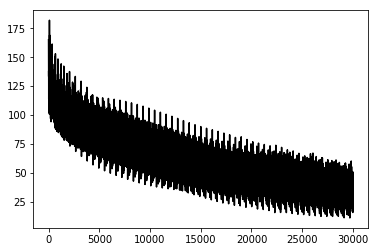

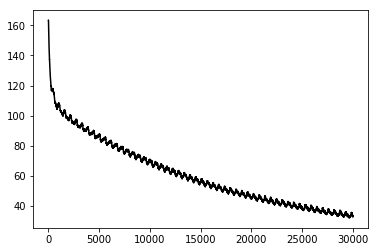

In [4]:
x_t = np.arange(1, max_iteration, 1)

plt.figure(1)
plt.plot(x_t, loss_list[1:max_iteration], 'k')

plt.figure(2)
plt.plot(x_t, lowpass_filtered_loss_list[1:max_iteration], 'k')

plt.show()


In [40]:
h_prev = np.zeros((hidden_dim, 1))
sample_ix = rnn.sample(h_prev, char_to_num[data[200]], 200)
txt = ''.join(num_to_char[ix] for ix in sample_ix)
print(txt)

가 이미지는 모습다. 이 있어야 머신러닝 기술도 빼 놓을 수 없고 말이다.
이러한 변화는 기존 보험사 보다는 IT 기업에 의해 주도되고 있다. 위에 열거한 새로운 상품들도 IT 기업 또는 start-up에 의한 것이었다. 기존의 보험에 대한 인식은 금융이 뒷받침되는 덩치 큰 보험사들의 전유물이라는 인식이 이제 서서히 무너지고 있는 것이다. 규모적인 면에서 
